In [11]:
#origin code

# -*- coding: utf-8 -*-
"""
Created on Thu Sep 29 01:42:29 2022

@author: ASUS

исходный файл: эксель со столбцами: 
    PDBid	chain	start*	end*
*-по PDB файлу

аут файл:


Описание функций:
    def Start - указываем путь к файлу xlsx, на выходе считанный датафрейм. [Вход: путь к экселю. Выход: считанный датафрейм]
    def Change_df - (!!! меняет исходный датафрейм) преобразует датафрейм к виду PDBid_chain PDBid chain start end length [Вход: датафрейм. Выход: преобразованный датафрейм. Сохраняет: эксель с преобразованным датафреймом]
    def Hist_maker - строит гистограмму по длинам подборки [Вход: подборка с длинами. Сохраняет: картинку гистограмму распределения длин молекул подборки]
    def Alpha_helix - добывает координаты альфа-спиралей [Вход: подборка наша. Вызывает: list_struc_maker (выход: датафрейм со спиралями их координатами)]
    def list_struc_maker - создаёт список длиной скоько а.о. и заполняет 1 там где есть структура [Вход: датафрейм со спиралями Helixes, длина белка l, начало белка start_domain. Вызывается в Alpha_helix]
    
"""

import numpy as np
import pandas as pd
import time
#import seaborn as sns
#import matplotlib.pyplot as plt
#from tempfile import gettempdir
#import biotite
#import biotite.structure as struc
#import biotite.structure.io.mmtf as mmtf
#import biotite.structure.io.pdb as pdb
import biotite.structure.io.pdbx as pdbx
#import biotite.sequence as seq
#import biotite.sequence.graphics as graphics
import biotite.database.rcsb as rcsb
#import biotite.application.dssp as dssp

#_______________________________________________________

def Start ():
    #-----Формируем первый датафрейм {PDBid chain start end}
    #print('Введите путь к файлу excel с его наименованием и .xlsx')
    #way = str(input())
    #'D:/Оля/курсовая/1_Обработка/1 Работа/проверяю расширенную обработку/pdbID.txt'
    path = 'book.xlsx'
    #path = 'example.xlsx'
    print("Вы ввели", path) 
    Podborka = pd.read_excel(path) #читвем датафрейм в переменную Podborka
    #print("Original Podborka\n", Podborka.head())
    #print('Типы:', Podborka.dtypes)
    #print('Колонки', Podborka.columns)
    #Podborka['PDBid']=str(Podborka['PDBid'])#преобразуем в строку
    #Podborka['chain']=Podborka['chain'].astype(str)#преобразуем в строку
    #Podborka['PDBid'].astype(str)
    #print('Типы:', Podborka.dtypes)
    print('--------------------')
    return Podborka
    
def Change_df (Podborka):
    #-----Модифицируем датафрейм, добавляя length и PDBid_chain {PDBid_chain PDBid chain start end length}
    Podborka.insert(4, 'length', Podborka['end']-Podborka['start']+1) #считаем длину в а.о. каждого домена/цепи
    Podborka.insert(0, 'PDBid_Chain', Podborka['PDBid']+'_'+Podborka['chain'])#добавим идетификатор PDBid_Chain
    #print("Changed Podborka\n", Podborka.head())
    #Выведем саммари по этому датафрейму
    print('Саммари\n', Podborka.describe())  
    #Podborka.describe().to_csv("Podborka_describe.csv")
    Podborka.describe().to_excel("Podborka_describe.xlsx")#запишем себе данные дискрайба
    #и на всякий случай сохраним датафрейм
    Podborka.to_excel("Podborka.xlsx")
    #Заготовки для результатов по стурктурам
    Podborka["Alpha-helixes"] = np.nan
    Podborka["Beta-sheets"] = np.nan
    Podborka["ThreeTen-helixes"] = np.nan
    Podborka["Count_AlphaH"] = np.nan
    Podborka["Count_BetaS"] = np.nan
    Podborka["Count_ThreeTenH"] = np.nan
    return Podborka
    print('--------------------')

def Hist_maker(Podborka):
    #Сразу распечатаем гистограмму (распределение длин белков подборки)
    ax = Podborka.hist(column='length', bins=25, grid=True, figsize=(12,8), color='royalblue', rwidth=0.9)  
    ax = ax[0]
    for x in ax:
        # Remove title
        x.set_title("Распределение длин белков подборки", size=20)
        # Set x-axis label
        x.set_xlabel("Длина, а.о.", labelpad=20, weight='bold', size=16)
        # Set y-axis label
        x.set_ylabel("Количество, структур", labelpad=20, weight='bold', size=16)
    fig = ax[0].get_figure()
    fig.savefig('Length distribution.jpg')#сохраним гистограмму
    print('--------------------')

def Alpha_helix(Podborka):
    g = 0
    for i, row in Podborka.iterrows():
        #input()
        #print("ALPHA")
        #print(f"Index: {i}")
        #print(f"{row}\n")
        PDBid = Podborka.iloc[i, 1]#выясняем актуальный PDBid 
        l = Podborka.iloc[i, 5]#выясняем актуальную длину
        chain_tut = Podborka.iloc[i, 2]#выясняем актуальную цепь
        start_domain = int(Podborka.iloc[i, 3])#выясняем актуальную координату начала домена/белка
        stop_domain = int(Podborka.iloc[i, 4])#выясняем актуальную координату конца домена/белка
        print("Данные: ", PDBid, l, chain_tut, start_domain, stop_domain, "g=", g)
        g=g+1
        #читаем PDBx из инета
        pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(PDBid, "pdbx"))
        #Получаем данные из файла вообще есть они там или нет
        P=pdbx_file [PDBid, "struct_conf"]#инфа о листах
        #print(pdbx_file["struct_sheet_order"])
        #input()
        #тут проверяем есть ли вообще данные о листах
        if P is not None:
            Id_hel=pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_id"]#id спиралей внутри файла в список
            #print(Id_hel)
            Beg_str = pdbx_file [PDBid, "struct_conf"]["beg_label_seq_id"]#начала спиралей а.о. для PDB обычного
            #Beg_str = pdbx_file [PDBid, "struct_conf"]["beg_auth_seq_id"]#начала спиралей а.о. для CATH
            #print("Beg_str=", Beg_str, "type=", type(Beg_str))
            if isinstance(Beg_str, str):
                Beg_str=np.array([int(Beg_str)]) 
            else:
                Beg_str = Beg_str.astype("int")
            #Beg_str = Beg_str.astype("int")
            #print(Beg_str)
            End_str = pdbx_file [PDBid, "struct_conf"]["end_label_seq_id"]#концы спиралей а.о.
            #End_str = pdbx_file [PDBid, "struct_conf"]["end_auth_seq_id"]#концы спиралей а.о.
            if isinstance(End_str, str):
                End_str=np.array([int(End_str)])
            else:
                End_str = End_str.astype("int")
            Class_hel = pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_class"]#классы спирали
            Length_hel = pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_length"]#длины спирали
            #Chain_hel = pdbx_file [PDBid, "struct_conf"]["beg_label_asym_id"]#цепи белка по буквам, каким принадлежат эти спирали
            Chain_hel = pdbx_file [PDBid, "struct_conf"]["beg_auth_asym_id"]#цепи белка по буквам, каким принадлежат эти спирали
            #print(Chain_hel)
            #ещё одна проверка если вдруг будет тупняк
            if Id_hel is not None:
                #сформируем локальный датафрейм альфа-спиралей, если эти альфа-спирали есть
                Helixes = pd.DataFrame({'Id_hel' : Id_hel,'Beg_str' : Beg_str, 'End_str': End_str, 'Class_hel': Class_hel, 'Length_hel': Length_hel, 'Chain_hel': Chain_hel})
                #print('Helixes\n', Helixes)
                #print('type', type(Helixes))
                #Удалим ненужные нам колонки (по названию цепи смотрим)
                Helixes = Helixes[Helixes.Class_hel == "1"]#тип спирали == альфа
                Helixes = Helixes[Helixes.Chain_hel == chain_tut]#цепь нужная по Podborka
                Helixes = Helixes[Helixes.Beg_str >= start_domain] #входит в домен
                Helixes = Helixes[Helixes.End_str <= stop_domain] #входит в домен
                Helixes.index = np.arange(len(Helixes))#обновляем индексы (чтобы стали от 0 до ..., а не как были в Helixes до того как удалим ненужные нам цепи)
                #print(" Helixes.index",  Helixes.index)
                #print("Helix которые подходят нам\n", Helixes)
                Podborka.loc[i, "Count_AlphaH"] = Helixes.shape[0]
                #input()
                #если пусто по листам (их нет нужных), то тоже будем писать NaN или нули. тут повторная штука такая т.к. листов может не быть изначально (выше) или их не будет лишь в нужных нам цепях белка (тут)
                isempty = Helixes.empty#если нет альфа-спиралей, то мы можем выбрать как заполнить данные
                if isempty:
                    print("В белке ", PDBid, "альфа-спиралей не обнаружено")
                    Res=[0]*100
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "Alpha-helixes"] = vse100
                    #print("Podborka", Podborka)
                else:
                    Res=[]
                    Res=list_struc_maker(Helixes, l, start_domain)#Получаем 100% данные структур
                    #print("Res", Res)
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "Alpha-helixes"] = vse100
                #print("Podborka", Podborka)
            else:
                print("Какие-то проблемы с Id_hel")
        else:
            print("В белке ", PDBid, "альфа-спиралей не обнаружено")
            Podborka.loc[i, "Count_AlphaH"] = 0
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            Podborka.loc[i, "Alpha-helixes"] = vse100
            #print("Podborka", Podborka
        print('--------------------')
    
def ThreeTen_helix(Podborka):
    g=0
    for i, row in Podborka.iterrows():
        #input()
        #print("ALPHA")
        #print(f"Index: {i}")
        #print(f"{row}\n")
        PDBid = Podborka.iloc[i, 1]#выясняем актуальный PDBid 
        l = Podborka.iloc[i, 5]#выясняем актуальную длину
        chain_tut = Podborka.iloc[i, 2]#выясняем актуальную цепь
        start_domain = int(Podborka.iloc[i, 3])#выясняем актуальную координату начала домена/белка
        stop_domain = int(Podborka.iloc[i, 4])#выясняем актуальную координату конца домена/белка
        print("Данные: ", PDBid, l, chain_tut, start_domain, stop_domain, "g=", g)
        g=g+1
        #читаем PDBx из инета
        pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(PDBid, "pdbx"))
        #Получаем данные из файла вообще есть они там или нет
        P=pdbx_file [PDBid, "struct_conf"]#инфа о листах
        #print(pdbx_file["struct_sheet_order"])
        #input()
        #тут проверяем есть ли вообще данные о листах
        if P is not None:
            Id_hel=pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_id"]#id спиралей внутри файла в список
            #print(Id_hel)
            #Beg_str = pdbx_file [PDBid, "struct_conf"]["beg_auth_seq_id"]#начала спиралей а.о.
            Beg_str = pdbx_file [PDBid, "struct_conf"]["beg_label_seq_id"]#начала спиралей а.о.
            if isinstance(Beg_str, str):
                Beg_str=np.array([int(Beg_str)]) 
            else:
                Beg_str = Beg_str.astype("int")
            #print(Beg_str)
            End_str = pdbx_file [PDBid, "struct_conf"]["end_label_seq_id"]#концы спиралей а.о. ЕСЛИ КАК В БД брать нумерацию
            #End_str = pdbx_file [PDBid, "struct_conf"]["end_auth_seq_id"]#концы спиралей а.о.
            if isinstance(End_str, str):
                End_str=np.array([int(End_str)])
            else:
                End_str = End_str.astype("int")
            Class_hel = pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_class"]#классы спирали
            Length_hel = pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_length"]#длины спирали
            #Chain_hel = pdbx_file [PDBid, "struct_conf"]["beg_label_asym_id"]#цепи белка по буквам, каким принадлежат эти спирали
            Chain_hel = pdbx_file [PDBid, "struct_conf"]["beg_auth_asym_id"]#цепи белка по буквам, каким принадлежат эти спирали
            #print(Chain_hel)
            #ещё одна проверка если вдруг будет тупняк
            if Id_hel is not None:
                #сформируем локальный датафрейм альфа-спиралей, если эти альфа-спирали есть
                Helixes = pd.DataFrame({'Id_hel' : Id_hel,'Beg_str' : Beg_str, 'End_str': End_str, 'Class_hel': Class_hel, 'Length_hel': Length_hel, 'Chain_hel': Chain_hel})
                #print('Helixes\n', Helixes)
                #print('type', type(Helixes))
                #Удалим ненужные нам колонки (по названию цепи смотрим)
                Helixes = Helixes[Helixes.Class_hel == "5"]#тип спирали == альфа
                Helixes = Helixes[Helixes.Chain_hel == chain_tut]#цепь нужная по Podborka
                Helixes = Helixes[Helixes.Beg_str >= start_domain] #входит в домен
                Helixes = Helixes[Helixes.End_str <= stop_domain] #входит в домен
                Helixes.index = np.arange(len(Helixes))#обновляем индексы (чтобы стали от 0 до ..., а не как были в Helixes до того как удалим ненужные нам цепи)
                #print(" Helixes.index",  Helixes.index)
                #print("Helix которые подходят нам\n", Helixes)
                Podborka.loc[i, "Count_ThreeTenH"] = Helixes.shape[0]
                #если пусто по листам (их нет нужных), то тоже будем писать NaN или нули. тут повторная штука такая т.к. листов может не быть изначально (выше) или их не будет лишь в нужных нам цепях белка (тут)
                isempty = Helixes.empty#если нет 310-спиралей, то мы можем выбрать как заполнить данные
                if isempty:
                    print("В белке ", PDBid, "3_10-спиралей не обнаружено")
                    Res=[0]*100
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "ThreeTen-helixes"] = vse100
                    #print("Podborka", Podborka)
                else:
                    Res=[]
                    Res=list_struc_maker(Helixes, l, start_domain)#Получаем 100% данные структур
                    #print("Res", Res)
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "ThreeTen-helixes"] = vse100
                    #print("Podborka", Podborka)
            else:
                print("Какие-то проблемы с Id_hel")
        else:
            print("В белке ", PDBid, "3_10-спиралей не обнаружено")
            Podborka.loc[i, "Count_ThreeTenH"] = 0
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            Podborka.loc[i, "ThreeTen-helixes"] = vse100
            #print("Podborka", Podborka)
    print('--------------------')        

def Beta_sheet(Podborka):
    g=0
    for i, row in Podborka.iterrows():
        #input()
        #print(f"Index: {i}")
        #print(f"{row}\n")
        PDBid = Podborka.iloc[i, 1]#выясняем актуальный PDBid 
        l = Podborka.iloc[i, 5]#выясняем актуальную длину
        chain_tut = Podborka.iloc[i, 2]#выясняем актуальную цепь
        start_domain = int(Podborka.iloc[i, 3])#выясняем актуальную координату начала домена/белка
        stop_domain = int(Podborka.iloc[i, 4])#выясняем актуальную координату конца домена/белка
        print("Данные: ", PDBid, l, chain_tut, start_domain, stop_domain, "g=", g)
        g=g+1
        #читаем PDBx из инета
        pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(PDBid, "pdbx"))
        #Получаем данные из файла вообще есть они там или нет
        P=pdbx_file [PDBid, "struct_sheet_range"]#инфа о листах
        #print(pdbx_file["struct_sheet_order"])
        #input()
        #тут проверяем есть ли вообще данные о листах
        if P is not None:
            Id_sht=pdbx_file [PDBid, "struct_sheet_range"]["sheet_id"]#id листа
            #print(Id_sht)
            Beg_str = pdbx_file [PDBid, "struct_sheet_range"]["beg_label_seq_id"]#начало листа а.о.
            #Beg_str = pdbx_file [PDBid, "struct_sheet_range"]["beg_auth_seq_id"]#начало листа а.о.
            if isinstance(Beg_str, str):
                Beg_str=np.array([int(Beg_str)]) 
            else:
                Beg_str = Beg_str.astype("int")
            End_str = pdbx_file [PDBid, "struct_sheet_range"]["end_label_seq_id"]#конец листа а.о.
            #End_str = pdbx_file [PDBid, "struct_sheet_range"]["end_auth_seq_id"]#конец листа а.о.
            if isinstance(End_str, str):
                End_str=np.array([int(End_str)])
            else:
                End_str = End_str.astype("int")
            Chain_sht = pdbx_file [PDBid, "struct_sheet_range"]["beg_auth_asym_id"]#цепь https://www.biotite-python.org/examples/gallery/structure/sheet_arrangement.html
            #print("chain_sht", Chain_sht)
            #input()
            #ещё одна проверка если вдруг будет тупняк
            if Id_sht is not None:
                #сформируем локальный датафрейм альфа-спиралей, если эти альфа-спирали есть
                Sheeets = pd.DataFrame({'Id_sht' : Id_sht,'Beg_str' : Beg_str, 'End_str': End_str, 'Chain_sht': Chain_sht})
                #print('Sheeets\n', Sheeets)
                #print('type', type(Sheeets))
                #Удалим ненужные нам колонки (по названию цепи смотрим)
                Sheeets = Sheeets[Sheeets.Chain_sht == chain_tut]#цепь нужная по Podborka
                Sheeets = Sheeets[Sheeets.Beg_str >= start_domain] #входит в домен
                Sheeets = Sheeets[Sheeets.End_str <= stop_domain] #входит в домен
                Sheeets.index = np.arange(len(Sheeets))#обновляем индексы (чтобы стали от 0 до ..., а не как были в Helixes до того как удалим ненужные нам цепи)
                #print(" Sheeets.index",  Sheeets.index)
                #print("Sheeets которые подходят нам\n", Sheeets)
                Podborka.loc[i, "Count_BetaS"] = Sheeets.shape[0]
                #если пусто по листам (их нет нужных), то тоже будем писать NaN или нули. тут повторная штука такая т.к. листов может не быть изначально (выше) или их не будет лишь в нужных нам цепях белка (тут)
                isempty = Sheeets.empty#если нет 310-спиралей, то мы можем выбрать как заполнить данные
                if isempty:
                    print("В белке ", PDBid, "бета-листов не обнаружено")
                    Res=[0]*100
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "Beta-sheets"] = vse100
                    #print("Podborka", Podborka)
                else:
                    Res=[]
                    Res=list_struc_maker(Sheeets, l, start_domain)#Получаем 100% данные структур
                    #print("Res", Res)
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "Beta-sheets"] = vse100
                    #print("Podborka", Podborka)
            else:
                print("Какие-то проблемы с Id_sht")
        else:
            print("В белке ", PDBid, "бета-листов не обнаружено")
            Podborka.loc[i, "Count_BetaS"] = 0
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            Podborka.loc[i, "Beta-sheets"] = vse100
            #print("Podborka", Podborka)
    print('--------------------')        


def Irregular(Podborka):
    for i, row in Podborka.iterrows():
        PDBid = Podborka.iloc[i, 1]#выясняем актуальный PDBid просто для отслеживания
        #l = Podborka.iloc[i, 5]#выясняем актуальную длину
        #print("l=", l)
        #print("Podborka.iloc[i, 6]", Podborka.iloc[i, 6])
        list_alpha = Podborka.iloc[i, 6].split(";")#делаем список с данными об альфа
        list_beta = Podborka.iloc[i, 7].split(";")#делаем список с данными о бета-листах
        list_threeten = Podborka.iloc[i, 8].split(";")#делаем список с данными о 310-спиралях
        print("Данные: ", PDBid)
        #print("list_alpha=",list_alpha)
        proba = [0]*100#пустой для наших нерегулярных структур        
        for index in range(len(proba)):
            #print("index=", index, ", list_alpha[index]=", list_alpha[index])
            #print(type(l),"   ", type(float(list_alpha[index])))
            proba[index]=1-float(list_alpha[index])-float(list_beta[index])-float(list_threeten[index])
            proba[index] = round(proba[index], 2)
            if proba[index] < 0:
                print("значение в нерегулярных стурктурах <0!")
                print(PDBid, "index=", index, "proba=", proba)
                #input()
            #print("proba=", proba)
            #vse100 = ';'.join(str(proba))
            vse100 = (";".join(map(str,proba)))
            #print("vse100=", vse100)
            #vse100 = (";", join(map(str, proba)))
            Podborka.loc[i, "Irregular"] = vse100   
    print('--------------------') 
    
            
def list_struc_maker(Helixes, l, start_domain):
    #Считываем нужные альфа-спирали в список 
    list_hel_original=[0] * l#список, где будем выставлять наличие альфа-спиралей
    #заполняем его (это тот, что в аминокислотных остатках)
    for i in range(0,len(Helixes)):
        start = int(Helixes.iloc[i]["Beg_str"])
        stop = int(Helixes.iloc[i]["End_str"])
        #print("СТАРТ=", start, " СТОП=", stop)
        #ставим относительно начала и конца домена с учётом, что в списке начало с 0, а не 1 и учёт домена
        start = start-start_domain
        stop = stop - start_domain
        #print("start=", start, " stop=", stop)
        #вносим в нашу цепь данные
        for c in range (start, stop+1):
            list_hel_original[c]=1
            #print("list_hel_original", list_hel_original[c])
    #print("Итого по цепи")
    #for i in range(0, len(list_hel_original)):
        #print("list_hel_original[",i,"]=", list_hel_original[i])
    
    Itog = translater(list_hel_original, l)
    #print("itog",Itog)

    print('=================_______________=============')
    print(f"struc_distr = {list_hel_original}")
    print()
    print(f"struc_distr_scaled = {Itog}")
    return Itog
    print('--------------------')

def translater(list_hel_original, l):
    #делаем список из 100 ячеек (наши координаты, т.е. %)
    proba = [0]*100
    T=l/100#Сколько приходится аминокислот на 1 ячейку
    print("T=", T)
    #if T>1:
    if T!=1:
        k=1
        t=T
        #print("t=", t)
        i=1
        j=1
        while i<l and j<100:
            a=min(k, t)
            proba[j]=round(proba[j]+a*list_hel_original[i],2)
            k=round(k-a,2)
            t=round(t-a,2)
            #print("a=",a," значение[",i,"]=", list_hel_original[i]," proba[", j,"]=", proba[j], " k=",k," t=",t, " i=", i, " j=",j)
            if k==0:
                i=i+1
                k=1
            if t==0:
                j=j+1
                t=T
            #print("k=",k, " t=", t)
        proba = [round(x/T, 2) for x in proba]
        #print("proba\n", proba)
    if T==1:
        proba=list_hel_original#просто копируем
    #if T<1:  
    #print("proba\n", proba)
    print("proba\n", proba)
    return proba
    print('--------------------')



print('Добро пожаловать!')
start_time = time.perf_counter() #счётчик времени выполнения проги
        
df = Start()
Change_df (df)
#Hist_maker(df)


print("Выберите какие структуры Вы хотели бы просмотреть: 1-альфа-спирали, 2-спирали 3_10, 3-бета-листы, 0-все приведённые и нерегулярные структуры.")
v = input()
print("Вы ввели: ", v)
if (v == "1"):
    print("Начинаю просматривать альфа-спирали")
    Alpha_helix(df)
else:
    if (v == "2"):
        print("Начинаю просматривать спирали 3-10") 
        ThreeTen_helix(df)
    else:
        if (v == "3"):
            print("Начинаю просматривать бета-листы")
            Beta_sheet(df)
        else: 
            if (v == "0"):
                print("Начинаю просматривать альфа-спирали")
                Alpha_helix(df)
                print("Начинаю просматривать спирали 3-10") 
                ThreeTen_helix(df)
                print("Начинаю просматривать бета-листы")
                Beta_sheet(df)
                print("Начинаю просматривать нерегулярные структуры")
                Irregular(df)
            else: print("Вы ввели неверное значение v. Попробуйте ещё раз")

#input()
#print(df.head)

df.to_excel("Result.xlsx")         
                   
print('Время работы скрипта: ',time.perf_counter()-start_time, 'сек')
#Время работы скрипта:  1739.8240654 сек // ~29минут

Добро пожаловать!
Вы ввели book.xlsx
--------------------
Саммари
             start         end      length
count    6.000000    6.000000    6.000000
mean    34.333333  177.666667  144.333333
std     81.652108   82.502525    2.658320
min      0.000000  141.000000  141.000000
25%      1.000000  142.250000  142.000000
50%      1.000000  146.000000  145.500000
75%      1.750000  146.000000  146.000000
max    201.000000  346.000000  147.000000
Выберите какие структуры Вы хотели бы просмотреть: 1-альфа-спирали, 2-спирали 3_10, 3-бета-листы, 0-все приведённые и нерегулярные структуры.


 0


Вы ввели:  0
Начинаю просматривать альфа-спирали
Данные:  1A3N 141 A 1 141 g= 0
T= 1.41
proba
 [0.0, 0.0, 0.58, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.65, 0.0, 0.0, 0.52, 1.0, 1.0, 0.32, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 0.41, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.45, 0.0, 0.0]
=================_______________=============
struc_distr = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/tmp/ipykernel_11050/2918533968.py:171: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.11;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.83;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.65;0.0;0.0;0.52;1.0;1.0;0.32;0.97;1.0;1.0;1.0;1.0;1.0;0.41;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.02;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.45;0.0;0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Podborka.loc[i, "Alpha-helixes"] = vse100


T= 1.45
proba
 [0.0, 0.0, 0.62, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.34, 0.28, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 1.0, 1.0, 1.0, 0.31, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.72, 0.0, 0.21, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.55, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.55, 0.0, 0.0]
=================_______________=============
struc_distr = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/tmp/ipykernel_11050/2918533968.py:254: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.18;1.0;1.0;1.0;1.0;0.08;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.04;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.72;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Podborka.loc[i, "ThreeTen-helixes"] = vse100


T= 1.45
proba
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24, 1.0, 1.0, 1.0, 0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
=================_______________=============
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/tmp/ipykernel_11050/2918533968.py:341: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Podborka.loc[i, "Beta-sheets"] = vse100


В белке  1A3N бета-листов не обнаружено
Данные:  1A4F 141 A 1 141 g= 2
В белке  1A4F бета-листов не обнаружено
Данные:  1A4F 146 B 1 146 g= 3
В белке  1A4F бета-листов не обнаружено
Данные:  1ASH 147 A 0 146 g= 4
В белке  1ASH бета-листов не обнаружено
Данные:  1IT2 146 B 201 346 g= 5
В белке  1IT2 бета-листов не обнаружено
--------------------
Начинаю просматривать нерегулярные структуры
Данные:  1A3N
Данные:  1A3N
Данные:  1A4F
Данные:  1A4F
Данные:  1ASH
Данные:  1IT2
--------------------
Время работы скрипта:  20.11937509999916 сек


In [ ]:
"""
@author: ASUS

исходный файл: эксель со столбцами: 
    PDBid	chain	start*	end*
*-по PDB файлу

аут файл:


Описание функций:
    def Start - указываем путь к файлу xlsx, на выходе считанный датафрейм. [Вход: путь к экселю. Выход: считанный датафрейм]
    def Change_df - (!!! меняет исходный датафрейм) преобразует датафрейм к виду PDBid_chain PDBid chain start end length [Вход: датафрейм. Выход: преобразованный датафрейм. Сохраняет: эксель с преобразованным датафреймом]
    def Hist_maker - строит гистограмму по длинам подборки [Вход: подборка с длинами. Сохраняет: картинку гистограмму распределения длин молекул подборки]
    def Alpha_helix - добывает координаты альфа-спиралей [Вход: подборка наша. Вызывает: list_struc_maker (выход: датафрейм со спиралями их координатами)]
    def list_struc_maker - создаёт список длиной скоько а.о. и заполняет 1 там где есть структура [Вход: датафрейм со спиралями Helixes, длина белка l, начало белка start_domain. Вызывается в Alpha_helix]
    
"""

# Original code

In [1]:
import numpy as np
import pandas as pd
import time
import biotite.structure.io.pdbx as pdbx
import biotite.database.rcsb as rcsb

## Start

In [2]:
#_______________________________________________________

def Start ():
    print('-----START----')
    #-----Формируем первый датафрейм {PDBid chain start end}
    #print('Введите путь к файлу excel с его наименованием и .xlsx')
    #way = str(input())
    #'D:/Оля/курсовая/1_Обработка/1 Работа/проверяю расширенную обработку/pdbID.txt'
    path = 'book.xlsx'
    print("Вы ввели", path) 
    Podborka = pd.read_excel(path) #читвем датафрейм в переменную Podborka
    #print("Original Podborka\n", Podborka.head())
    #print('Типы:', Podborka.dtypes)
    #print('Колонки', Podborka.columns)
    #Podborka['PDBid']=str(Podborka['PDBid'])#преобразуем в строку
    #Podborka['chain']=Podborka['chain'].astype(str)#преобразуем в строку
    #Podborka['PDBid'].astype(str)
    #print('Типы:', Podborka.dtypes)
    display(Podborka.head(3))
    print('--------------------')
    return Podborka



# READY

## Change_df

In [3]:
def Change_df (Podborka):
    print('-----Change_df----')
    #-----Модифицируем датафрейм, добавляя length и PDBid_chain {PDBid_chain PDBid chain start end length}
    Podborka.insert(4, 'length', Podborka['end']-Podborka['start']+1) #считаем длину в а.о. каждого домена/цепи
    Podborka.insert(0, 'PDBid_Chain', Podborka['PDBid']+'_'+Podborka['chain'])#добавим идетификатор PDBid_Chain
    #print("Changed Podborka\n", Podborka.head())
    #Выведем саммари по этому датафрейму
    print('Саммари\n', Podborka.describe())  
    #Podborka.describe().to_csv("Podborka_describe.csv")
    Podborka.describe().to_excel("Podborka_describe.xlsx")#запишем себе данные дискрайба
    #и на всякий случай сохраним датафрейм
    Podborka.to_excel("Podborka.xlsx")
    #Заготовки для результатов по стурктурам
    Podborka["Alpha-helixes"] = np.nan
    Podborka["Beta-sheets"] = np.nan
    Podborka["ThreeTen-helixes"] = np.nan
    Podborka["Count_AlphaH"] = np.nan
    Podborka["Count_BetaS"] = np.nan
    Podborka["Count_ThreeTenH"] = np.nan
    display(Podborka.head(3))
    return Podborka
    print('--------------------')

## Hist_maker

In [4]:
def Hist_maker(Podborka):
    print('-----Hist_maker----')
    #Сразу распечатаем гистограмму (распределение длин белков подборки)
    ax = Podborka.hist(column='length', bins=25, grid=True, figsize=(12,8), color='royalblue', rwidth=0.9)  
    ax = ax[0]
    for x in ax:
        # Remove title
        x.set_title("Распределение длин белков подборки", size=20)
        # Set x-axis label
        x.set_xlabel("Длина, а.о.", labelpad=20, weight='bold', size=16)
        # Set y-axis label
        x.set_ylabel("Количество, структур", labelpad=20, weight='bold', size=16)
    fig = ax[0].get_figure()
    fig.savefig('Length distribution.jpg')#сохраним гистограмму
    print('--------------------')

## Alpha_helix

In [5]:
def Alpha_helix(Podborka):
    print('-----Alpha_helix----')
    g = 0
    for i, row in Podborka.iterrows():
        #input()
        #print("ALPHA")
        #print(f"Index: {i}")
        #print(f"{row}\n")
        PDBid = Podborka.iloc[i, 1]#выясняем актуальный PDBid 
        l = Podborka.iloc[i, 5]#выясняем актуальную длину
        chain_tut = Podborka.iloc[i, 2]#выясняем актуальную цепь
        start_domain = int(Podborka.iloc[i, 3])#выясняем актуальную координату начала домена/белка
        stop_domain = int(Podborka.iloc[i, 4])#выясняем актуальную координату конца домена/белка
        print("Данные: ", PDBid, l, chain_tut, start_domain, stop_domain, "g=", g)
        g=g+1
        #читаем PDBx из инета
        pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(PDBid, "pdbx"))
        #Получаем данные из файла вообще есть они там или нет
        P=pdbx_file [PDBid, "struct_conf"]#инфа о листах
        #print(pdbx_file["struct_sheet_order"])
        #input()
        #тут проверяем есть ли вообще данные о листах
        if P is not None:
            Id_hel=pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_id"]#id спиралей внутри файла в список
            #print(Id_hel)
            Beg_str = pdbx_file [PDBid, "struct_conf"]["beg_label_seq_id"]#начала спиралей а.о. для PDB обычного
            #Beg_str = pdbx_file [PDBid, "struct_conf"]["beg_auth_seq_id"]#начала спиралей а.о. для CATH
            #print("Beg_str=", Beg_str, "type=", type(Beg_str))
            if isinstance(Beg_str, str):
                Beg_str=np.array([int(Beg_str)]) 
            else:
                Beg_str = Beg_str.astype("int")
            #Beg_str = Beg_str.astype("int")
            #print(Beg_str)
            End_str = pdbx_file [PDBid, "struct_conf"]["end_label_seq_id"]#концы спиралей а.о.
            #End_str = pdbx_file [PDBid, "struct_conf"]["end_auth_seq_id"]#концы спиралей а.о.
            if isinstance(End_str, str):
                End_str=np.array([int(End_str)])
            else:
                End_str = End_str.astype("int")
            Class_hel = pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_class"]#классы спирали
            Length_hel = pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_length"]#длины спирали
            #Chain_hel = pdbx_file [PDBid, "struct_conf"]["beg_label_asym_id"]#цепи белка по буквам, каким принадлежат эти спирали
            Chain_hel = pdbx_file [PDBid, "struct_conf"]["beg_auth_asym_id"]#цепи белка по буквам, каким принадлежат эти спирали
            #print(Chain_hel)
            #ещё одна проверка если вдруг будет тупняк
            if Id_hel is not None:
                #сформируем локальный датафрейм альфа-спиралей, если эти альфа-спирали есть
                Helixes = pd.DataFrame({'Id_hel' : Id_hel,'Beg_str' : Beg_str, 'End_str': End_str, 'Class_hel': Class_hel, 'Length_hel': Length_hel, 'Chain_hel': Chain_hel})
                #print('Helixes\n', Helixes)
                #print('type', type(Helixes))
                #Удалим ненужные нам колонки (по названию цепи смотрим)
                Helixes = Helixes[Helixes.Class_hel == "1"]#тип спирали == альфа
                Helixes = Helixes[Helixes.Chain_hel == chain_tut]#цепь нужная по Podborka
                Helixes = Helixes[Helixes.Beg_str >= start_domain] #входит в домен
                Helixes = Helixes[Helixes.End_str <= stop_domain] #входит в домен
                Helixes.index = np.arange(len(Helixes))#обновляем индексы (чтобы стали от 0 до ..., а не как были в Helixes до того как удалим ненужные нам цепи)
                #print(" Helixes.index",  Helixes.index)
                #print("Helix которые подходят нам\n", Helixes)
                Podborka.loc[i, "Count_AlphaH"] = Helixes.shape[0]
                #input()
                #если пусто по листам (их нет нужных), то тоже будем писать NaN или нули. тут повторная штука такая т.к. листов может не быть изначально (выше) или их не будет лишь в нужных нам цепях белка (тут)
                isempty = Helixes.empty#если нет альфа-спиралей, то мы можем выбрать как заполнить данные
                if isempty:
                    print("В белке ", PDBid, "альфа-спиралей не обнаружено")
                    Res=[0]*100
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "Alpha-helixes"] = vse100
                    #print("Podborka", Podborka)
                else:
                    Res=[]
                    Res=list_struc_maker(Helixes, l, start_domain)#Получаем 100% данные структур
                    #print("Res", Res)
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "Alpha-helixes"] = vse100
                #print("Podborka", Podborka)
            else:
                print("Какие-то проблемы с Id_hel")
        else:
            print("В белке ", PDBid, "альфа-спиралей не обнаружено")
            Podborka.loc[i, "Count_AlphaH"] = 0
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            Podborka.loc[i, "Alpha-helixes"] = vse100
            #print("Podborka", Podborka
        display(Podborka.head(3))
        print('--------------------')

## ThreeTen_helix

In [6]:
def ThreeTen_helix(Podborka):
    print('-----ThreeTen_helix----')
    g=0
    for i, row in Podborka.iterrows():
        #input()
        #print("ALPHA")
        #print(f"Index: {i}")
        #print(f"{row}\n")
        PDBid = Podborka.iloc[i, 1]#выясняем актуальный PDBid 
        l = Podborka.iloc[i, 5]#выясняем актуальную длину
        chain_tut = Podborka.iloc[i, 2]#выясняем актуальную цепь
        start_domain = int(Podborka.iloc[i, 3])#выясняем актуальную координату начала домена/белка
        stop_domain = int(Podborka.iloc[i, 4])#выясняем актуальную координату конца домена/белка
        print("Данные: ", PDBid, l, chain_tut, start_domain, stop_domain, "g=", g)
        g=g+1
        #читаем PDBx из инета
        pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(PDBid, "pdbx"))
        #Получаем данные из файла вообще есть они там или нет
        P=pdbx_file [PDBid, "struct_conf"]#инфа о листах
        #print(pdbx_file["struct_sheet_order"])
        #input()
        #тут проверяем есть ли вообще данные о листах
        if P is not None:
            Id_hel=pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_id"]#id спиралей внутри файла в список
            #print(Id_hel)
            #Beg_str = pdbx_file [PDBid, "struct_conf"]["beg_auth_seq_id"]#начала спиралей а.о.
            Beg_str = pdbx_file [PDBid, "struct_conf"]["beg_label_seq_id"]#начала спиралей а.о.
            if isinstance(Beg_str, str):
                Beg_str=np.array([int(Beg_str)]) 
            else:
                Beg_str = Beg_str.astype("int")
            #print(Beg_str)
            End_str = pdbx_file [PDBid, "struct_conf"]["end_label_seq_id"]#концы спиралей а.о. ЕСЛИ КАК В БД брать нумерацию
            #End_str = pdbx_file [PDBid, "struct_conf"]["end_auth_seq_id"]#концы спиралей а.о.
            if isinstance(End_str, str):
                End_str=np.array([int(End_str)])
            else:
                End_str = End_str.astype("int")
            Class_hel = pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_class"]#классы спирали
            Length_hel = pdbx_file [PDBid, "struct_conf"]["pdbx_PDB_helix_length"]#длины спирали
            #Chain_hel = pdbx_file [PDBid, "struct_conf"]["beg_label_asym_id"]#цепи белка по буквам, каким принадлежат эти спирали
            Chain_hel = pdbx_file [PDBid, "struct_conf"]["beg_auth_asym_id"]#цепи белка по буквам, каким принадлежат эти спирали
            #print(Chain_hel)
            #ещё одна проверка если вдруг будет тупняк
            if Id_hel is not None:
                #сформируем локальный датафрейм альфа-спиралей, если эти альфа-спирали есть
                Helixes = pd.DataFrame({'Id_hel' : Id_hel,'Beg_str' : Beg_str, 'End_str': End_str, 'Class_hel': Class_hel, 'Length_hel': Length_hel, 'Chain_hel': Chain_hel})
                #print('Helixes\n', Helixes)
                #print('type', type(Helixes))
                #Удалим ненужные нам колонки (по названию цепи смотрим)
                Helixes = Helixes[Helixes.Class_hel == "5"]#тип спирали == альфа
                Helixes = Helixes[Helixes.Chain_hel == chain_tut]#цепь нужная по Podborka
                Helixes = Helixes[Helixes.Beg_str >= start_domain] #входит в домен
                Helixes = Helixes[Helixes.End_str <= stop_domain] #входит в домен
                Helixes.index = np.arange(len(Helixes))#обновляем индексы (чтобы стали от 0 до ..., а не как были в Helixes до того как удалим ненужные нам цепи)
                #print(" Helixes.index",  Helixes.index)
                #print("Helix которые подходят нам\n", Helixes)
                Podborka.loc[i, "Count_ThreeTenH"] = Helixes.shape[0]
                #если пусто по листам (их нет нужных), то тоже будем писать NaN или нули. тут повторная штука такая т.к. листов может не быть изначально (выше) или их не будет лишь в нужных нам цепях белка (тут)
                isempty = Helixes.empty#если нет 310-спиралей, то мы можем выбрать как заполнить данные
                if isempty:
                    print("В белке ", PDBid, "3_10-спиралей не обнаружено")
                    Res=[0]*100
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "ThreeTen-helixes"] = vse100
                    #print("Podborka", Podborka)
                else:
                    Res=[]
                    Res=list_struc_maker(Helixes, l, start_domain)#Получаем 100% данные структур
                    #print("Res", Res)
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "ThreeTen-helixes"] = vse100
                    #print("Podborka", Podborka)
            else:
                print("Какие-то проблемы с Id_hel")
        else:
            print("В белке ", PDBid, "3_10-спиралей не обнаружено")
            Podborka.loc[i, "Count_ThreeTenH"] = 0
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            Podborka.loc[i, "ThreeTen-helixes"] = vse100
            #print("Podborka", Podborka)
    print('--------------------')    

## Beta_sheet

In [18]:
def Beta_sheet(Podborka):
    print('-----Beta_sheet----')
    g=0
    for i, row in Podborka.iterrows():
        #input()
        #print(f"Index: {i}")
        #print(f"{row}\n")
        PDBid = Podborka.iloc[i, 1]#выясняем актуальный PDBid 
        l = Podborka.iloc[i, 5]#выясняем актуальную длину
        chain_tut = Podborka.iloc[i, 2]#выясняем актуальную цепь
        start_domain = int(Podborka.iloc[i, 3])#выясняем актуальную координату начала домена/белка
        stop_domain = int(Podborka.iloc[i, 4])#выясняем актуальную координату конца домена/белка
        print("Данные: ", PDBid, l, chain_tut, start_domain, stop_domain, "g=", g)
        g=g+1
        #читаем PDBx из инета
        pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(PDBid, "pdbx"))
        #Получаем данные из файла вообще есть они там или нет
        P=pdbx_file [PDBid, "struct_sheet_range"]#инфа о листах
        #print(pdbx_file["struct_sheet_order"])
        #input()
        #тут проверяем есть ли вообще данные о листах
        if P is not None:
            Id_sht=pdbx_file [PDBid, "struct_sheet_range"]["sheet_id"]#id листа
            #print(Id_sht)
            Beg_str = pdbx_file [PDBid, "struct_sheet_range"]["beg_label_seq_id"]#начало листа а.о.
            #Beg_str = pdbx_file [PDBid, "struct_sheet_range"]["beg_auth_seq_id"]#начало листа а.о.
            if isinstance(Beg_str, str):
                Beg_str=np.array([int(Beg_str)]) 
            else:
                Beg_str = Beg_str.astype("int")
            End_str = pdbx_file [PDBid, "struct_sheet_range"]["end_label_seq_id"]#конец листа а.о.
            #End_str = pdbx_file [PDBid, "struct_sheet_range"]["end_auth_seq_id"]#конец листа а.о.
            if isinstance(End_str, str):
                End_str=np.array([int(End_str)])
            else:
                End_str = End_str.astype("int")
            Chain_sht = pdbx_file [PDBid, "struct_sheet_range"]["beg_auth_asym_id"]#цепь https://www.biotite-python.org/examples/gallery/structure/sheet_arrangement.html
            #print("chain_sht", Chain_sht)
            #input()
            #ещё одна проверка если вдруг будет тупняк
            if Id_sht is not None:
                #сформируем локальный датафрейм альфа-спиралей, если эти альфа-спирали есть
                Sheeets = pd.DataFrame({'Id_sht' : Id_sht,'Beg_str' : Beg_str, 'End_str': End_str, 'Chain_sht': Chain_sht})
                #print('Sheeets\n', Sheeets)
                #print('type', type(Sheeets))
                #Удалим ненужные нам колонки (по названию цепи смотрим)
                Sheeets = Sheeets[Sheeets.Chain_sht == chain_tut]#цепь нужная по Podborka
                Sheeets = Sheeets[Sheeets.Beg_str >= start_domain] #входит в домен
                Sheeets = Sheeets[Sheeets.End_str <= stop_domain] #входит в домен
                Sheeets.index = np.arange(len(Sheeets))#обновляем индексы (чтобы стали от 0 до ..., а не как были в Helixes до того как удалим ненужные нам цепи)
                #print(" Sheeets.index",  Sheeets.index)
                #print("Sheeets которые подходят нам\n", Sheeets)
                Podborka.loc[i, "Count_BetaS"] = Sheeets.shape[0]
                #если пусто по листам (их нет нужных), то тоже будем писать NaN или нули. тут повторная штука такая т.к. листов может не быть изначально (выше) или их не будет лишь в нужных нам цепях белка (тут)
                isempty = Sheeets.empty#если нет 310-спиралей, то мы можем выбрать как заполнить данные
                if isempty:
                    print("В белке ", PDBid, "бета-листов не обнаружено")
                    Res=[0]*100
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "Beta-sheets"] = vse100
                    #print("Podborka", Podborka)
                else:
                    Res=[]
                    Res=list_struc_maker(Sheeets, l, start_domain)#Получаем 100% данные структур
                    #print("Res", Res)
                    vse100 = (";".join(map(str,Res)))
                    Podborka.loc[i, "Beta-sheets"] = vse100
                    #print("Podborka", Podborka)
            else:
                print("Какие-то проблемы с Id_sht")
        else:
            print("В белке ", PDBid, "бета-листов не обнаружено")
            Podborka.loc[i, "Count_BetaS"] = 0
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            Podborka.loc[i, "Beta-sheets"] = vse100
            #print("Podborka", Podborka)
    display(Podborka.head(3))
    print('--------------------')        


## Irregular

In [19]:
def Irregular(Podborka):
    print('-----Irregular----')
    for i, row in Podborka.iterrows():
        PDBid = Podborka.iloc[i, 1]#выясняем актуальный PDBid просто для отслеживания
        #l = Podborka.iloc[i, 5]#выясняем актуальную длину
        #print("l=", l)
        #print("Podborka.iloc[i, 6]", Podborka.iloc[i, 6])
        list_alpha = Podborka.iloc[i, 6].split(";")#делаем список с данными об альфа
        list_beta = Podborka.iloc[i, 7].split(";")#делаем список с данными о бета-листах
        list_threeten = Podborka.iloc[i, 8].split(";")#делаем список с данными о 310-спиралях
        print("Данные: ", PDBid)
        #print("list_alpha=",list_alpha)
        proba = [0]*100#пустой для наших нерегулярных структур        
        for index in range(len(proba)):
            #print("index=", index, ", list_alpha[index]=", list_alpha[index])
            #print(type(l),"   ", type(float(list_alpha[index])))
            proba[index]=1-float(list_alpha[index])-float(list_beta[index])-float(list_threeten[index])
            proba[index] = round(proba[index], 2)
            if proba[index] < 0:
                print("значение в нерегулярных стурктурах <0!")
                print(PDBid, "index=", index, "proba=", proba)
                #input()
            #print("proba=", proba)
            #vse100 = ';'.join(str(proba))
            vse100 = (";".join(map(str,proba)))
            #print("vse100=", vse100)
            #vse100 = (";", join(map(str, proba)))
            Podborka.loc[i, "Irregular"] = vse100   
    print('--------------------') 

## list_struc_maker

In [11]:
def list_struc_maker(Helixes, l, start_domain):
    '''создаёт список длиной скоько а.о. и заполняет 1 там где есть структура 
    [Вход: датафрейм со спиралями Helixes, длина белка l, начало белка start_domain. 
    Вызывается в Alpha_helix ThreeTen_helix и Beta_sheets'''
    print('-----list_struc_maker----')
    #Считываем нужные альфа-спирали в список 
    list_hel_original=[0] * l#список, где будем выставлять наличие альфа-спиралей
    #заполняем его (это тот, что в аминокислотных остатках)
    for i in range(0,len(Helixes)):#
        start = int(Helixes.iloc[i]["Beg_str"])
        stop = int(Helixes.iloc[i]["End_str"])
        #print("СТАРТ=", start, " СТОП=", stop)
        #ставим относительно начала и конца домена с учётом, что в списке начало с 0, а не 1 и учёт домена
        start = start-start_domain
        stop = stop - start_domain
        #print("start=", start, " stop=", stop)
        #вносим в нашу цепь данные
        for c in range (start, stop+1):
            list_hel_original[c]=1
            #print("list_hel_original", list_hel_original[c])
    #print("Итого по цепи")
    #for i in range(0, len(list_hel_original)):
        #print("list_hel_original[",i,"]=", list_hel_original[i])
    Itog = translater(list_hel_original, l)
    print("itog",Itog)
    return Itog
    print('--------------------')

## translater

In [14]:
def translater(list_hel_original, l):
    print('-----translater----')
    #делаем список из 100 ячеек (наши координаты, т.е. %)
    proba = [0]*100
    T=l/100#Сколько приходится аминокислот на 1 ячейку
    print("T=", T)
    #if T>1:
    if T!=1:
        k=1
        t=T
        #print("t=", t)
        i=1
        j=1
        while i<l and j<100:
            a=min(k, t)
            proba[j]=round(proba[j]+a*list_hel_original[i],2)
            k=round(k-a,2)
            t=round(t-a,2)
            #print("a=",a," значение[",i,"]=", list_hel_original[i]," proba[", j,"]=", proba[j], " k=",k," t=",t, " i=", i, " j=",j)
            if k==0:
                i=i+1
                k=1
            if t==0:
                j=j+1
                t=T
            #print("k=",k, " t=", t)
        proba = [round(x/T, 2) for x in proba]
        #print("proba\n", proba)
    if T==1:
        proba=list_hel_original#просто копируем
    #if T<1:  
    #print("proba\n", proba)
    print("proba\n", proba)
    return proba
    print('--------------------')


## Main

In [23]:
print('Добро пожаловать!')
start_time = time.perf_counter() #счётчик времени выполнения проги
        
df = Start()
Change_df (df)
#Hist_maker(df)

Добро пожаловать!
-----START----
Вы ввели book.xlsx


,PDBid,chain,start,end
0,1A3N,A,1,141
1,1A3N,B,2,146
2,1A4F,A,1,141


--------------------
-----Change_df----
Саммари
             start         end      length
count    6.000000    6.000000    6.000000
mean    34.333333  177.666667  144.333333
std     81.652108   82.502525    2.658320
min      0.000000  141.000000  141.000000
25%      1.000000  142.250000  142.000000
50%      1.000000  146.000000  145.500000
75%      1.750000  146.000000  146.000000
max    201.000000  346.000000  147.000000


,PDBid_Chain,PDBid,chain,start,end,length,Alpha-helixes,Beta-sheets,ThreeTen-helixes,Count_AlphaH,Count_BetaS,Count_ThreeTenH
0,1A3N_A,1A3N,A,1,141,141,NaN,NaN,NaN,NaN,NaN,NaN
1,1A3N_B,1A3N,B,2,146,145,NaN,NaN,NaN,NaN,NaN,NaN
2,1A4F_A,1A4F,A,1,141,141,NaN,NaN,NaN,NaN,NaN,NaN


,PDBid_Chain,PDBid,chain,start,end,length,Alpha-helixes,Beta-sheets,ThreeTen-helixes,Count_AlphaH,Count_BetaS,Count_ThreeTenH
0,1A3N_A,1A3N,A,1,141,141,NaN,NaN,NaN,NaN,NaN,NaN
1,1A3N_B,1A3N,B,2,146,145,NaN,NaN,NaN,NaN,NaN,NaN
2,1A4F_A,1A4F,A,1,141,141,NaN,NaN,NaN,NaN,NaN,NaN
3,1A4F_B,1A4F,B,1,146,146,NaN,NaN,NaN,NaN,NaN,NaN
4,1ASH_A,1ASH,A,0,146,147,NaN,NaN,NaN,NaN,NaN,NaN
5,1IT2_B,1IT2,B,201,346,146,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
print("Выберите какие структуры Вы хотели бы просмотреть: 1-альфа-спирали, 2-спирали 3_10, 3-бета-листы, 0-все приведённые и нерегулярные структуры.")
v = input()
print("Вы ввели: ", v)
if (v == "1"):
    print("Начинаю просматривать альфа-спирали")
    Alpha_helix(df)
else:
    if (v == "2"):
        print("Начинаю просматривать спирали 3-10") 
        ThreeTen_helix(df)
    else:
        if (v == "3"):
            print("Начинаю просматривать бета-листы")
            Beta_sheet(df)
        else: 
            if (v == "0"):
                print("Начинаю просматривать альфа-спирали")
                Alpha_helix(df)
                print("Начинаю просматривать спирали 3-10") 
                ThreeTen_helix(df)
                print("Начинаю просматривать бета-листы")
                Beta_sheet(df)
                print("Начинаю просматривать нерегулярные структуры")
                Irregular(df)
            else: print("Вы ввели неверное значение v. Попробуйте ещё раз")


Выберите какие структуры Вы хотели бы просмотреть: 1-альфа-спирали, 2-спирали 3_10, 3-бета-листы, 0-все приведённые и нерегулярные структуры.


 1


Вы ввели:  1
Начинаю просматривать альфа-спирали
-----Alpha_helix----
Данные:  1A3N 141 A 1 141 g= 0
-----list_struc_maker----
-----translater----
T= 1.41
proba
 [0.0, 0.0, 0.58, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.65, 0.0, 0.0, 0.52, 1.0, 1.0, 0.32, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 0.41, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.45, 0.0, 0.0]
itog [0.0, 0.0, 0.58, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.65, 0.0, 0.0, 0.52, 1.0, 1.0, 0.32, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0,

/tmp/ipykernel_79/3399659204.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.11;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.83;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.65;0.0;0.0;0.52;1.0;1.0;0.32;0.97;1.0;1.0;1.0;1.0;1.0;0.41;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.02;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.45;0.0;0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Podborka.loc[i, "Alpha-helixes"] = vse100


,PDBid_Chain,PDBid,chain,start,end,length,Alpha-helixes,Beta-sheets,ThreeTen-helixes,Count_AlphaH,Count_BetaS,Count_ThreeTenH
0,1A3N_A,1A3N,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN
1,1A3N_B,1A3N,B,2,146,145,NaN,NaN,NaN,NaN,NaN,NaN
2,1A4F_A,1A4F,A,1,141,141,NaN,NaN,NaN,NaN,NaN,NaN


--------------------
Данные:  1A3N 145 B 2 146 g= 1
-----list_struc_maker----
-----translater----
T= 1.45
proba
 [0.0, 0.0, 0.62, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.34, 0.28, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 1.0, 1.0, 1.0, 0.31, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.72, 0.0, 0.21, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.55, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.55, 0.0, 0.0]
itog [0.0, 0.0, 0.62, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.34, 0.28, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 1.0, 1.0, 1.0, 0.31, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.72, 0.0, 0.21, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

,PDBid_Chain,PDBid,chain,start,end,length,Alpha-helixes,Beta-sheets,ThreeTen-helixes,Count_AlphaH,Count_BetaS,Count_ThreeTenH
0,1A3N_A,1A3N,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN
1,1A3N_B,1A3N,B,2,146,145,0.0;0.0;0.62;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...,NaN,NaN,6.0,NaN,NaN
2,1A4F_A,1A4F,A,1,141,141,NaN,NaN,NaN,NaN,NaN,NaN


--------------------
Данные:  1A4F 141 A 1 141 g= 2
-----list_struc_maker----
-----translater----
T= 1.41
proba
 [0.0, 0.0, 0.58, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.35, 0.0, 0.52, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94, 0.0, 0.0, 0.0, 0.52, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.04, 0.0, 0.0, 0.0]
itog [0.0, 0.0, 0.58, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.35, 0.0, 0.52, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94, 0.0, 0.0, 0.0, 0.52, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

,PDBid_Chain,PDBid,chain,start,end,length,Alpha-helixes,Beta-sheets,ThreeTen-helixes,Count_AlphaH,Count_BetaS,Count_ThreeTenH
0,1A3N_A,1A3N,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN
1,1A3N_B,1A3N,B,2,146,145,0.0;0.0;0.62;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...,NaN,NaN,6.0,NaN,NaN
2,1A4F_A,1A4F,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN


--------------------
Данные:  1A4F 146 B 1 146 g= 3
-----list_struc_maker----
-----translater----
T= 1.46
proba
 [0.0, 0.0, 0.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.0, 0.67, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44, 1.0, 1.0, 0.99, 0.0, 0.64, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.37, 0.0, 0.0, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 0.0, 0.0, 0.0, 0.88, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.19, 0.44, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.58, 0.0, 0.0]
itog [0.0, 0.0, 0.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.0, 0.67, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44, 1.0, 1.0, 0.99, 0.0, 0.64, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.37, 0.0, 0.0, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 0.0, 0.0, 0.0, 0.88, 1.0, 1.0, 1.0,

,PDBid_Chain,PDBid,chain,start,end,length,Alpha-helixes,Beta-sheets,ThreeTen-helixes,Count_AlphaH,Count_BetaS,Count_ThreeTenH
0,1A3N_A,1A3N,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN
1,1A3N_B,1A3N,B,2,146,145,0.0;0.0;0.62;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...,NaN,NaN,6.0,NaN,NaN
2,1A4F_A,1A4F,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN


--------------------
Данные:  1ASH 147 A 0 146 g= 4
-----list_struc_maker----
-----translater----
T= 1.47
proba
 [0.0, 0.32, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.52, 0.0, 0.0, 0.0, 0.39, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.63, 1.0, 1.0, 1.0, 0.46, 0.86, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.06, 0.0, 0.22, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.03, 0.0, 0.0, 0.57, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.67, 0.0, 0.0, 0.61, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.64]
itog [0.0, 0.32, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.52, 0.0, 0.0, 0.0, 0.39, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.63, 1.0, 1.0, 1.0, 0.46, 0.86, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.06, 0.0, 0.22, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.03, 0.0, 0

,PDBid_Chain,PDBid,chain,start,end,length,Alpha-helixes,Beta-sheets,ThreeTen-helixes,Count_AlphaH,Count_BetaS,Count_ThreeTenH
0,1A3N_A,1A3N,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN
1,1A3N_B,1A3N,B,2,146,145,0.0;0.0;0.62;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...,NaN,NaN,6.0,NaN,NaN
2,1A4F_A,1A4F,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN


--------------------
Данные:  1IT2 146 B 201 346 g= 5
В белке  1IT2 альфа-спиралей не обнаружено


,PDBid_Chain,PDBid,chain,start,end,length,Alpha-helixes,Beta-sheets,ThreeTen-helixes,Count_AlphaH,Count_BetaS,Count_ThreeTenH
0,1A3N_A,1A3N,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN
1,1A3N_B,1A3N,B,2,146,145,0.0;0.0;0.62;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...,NaN,NaN,6.0,NaN,NaN
2,1A4F_A,1A4F,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN


--------------------


In [25]:


#input()
#print(df.head)

#df.to_excel("Result.xlsx")         
                   
print('Время работы скрипта: ',time.perf_counter()-start_time, 'сек')
#Время работы скрипта:  1739.8240654 сек // ~29минут

Время работы скрипта:  107.17769930000009 сек


In [26]:
df

,PDBid_Chain,PDBid,chain,start,end,length,Alpha-helixes,Beta-sheets,ThreeTen-helixes,Count_AlphaH,Count_BetaS,Count_ThreeTenH
0,1A3N_A,1A3N,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN
1,1A3N_B,1A3N,B,2,146,145,0.0;0.0;0.62;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...,NaN,NaN,6.0,NaN,NaN
2,1A4F_A,1A4F,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...,NaN,NaN,5.0,NaN,NaN
3,1A4F_B,1A4F,B,1,146,146,0.0;0.0;0.0;0.95;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...,NaN,NaN,7.0,NaN,NaN
4,1ASH_A,1ASH,A,0,146,147,0.0;0.32;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.52;...,NaN,NaN,7.0,NaN,NaN
5,1IT2_B,1IT2,B,201,346,146,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,NaN,NaN,0.0,NaN,NaN


# polish code

In [29]:
import numpy as np
import pandas as pd
import biotite.structure.io.pdbx as pdbx
import biotite.database.rcsb as rcsb

## Start --> read_prot_set --> ∅

In [2]:
#TODO: check up the mode asserts?
# is exist the path/file

#START in previous life

def read_prot_set(path: str, mode: str = 'xlsx'):
    """
    Read protein set data from file through the path and return a pandas dataframe. The following data structure is required: PDBid, chain, start, end. Header is needed.
    arguments:
        - path (str): path to the file for reading
        - mode (str): file format to read. Only xlsx, csv and tsv formats are allowed
    return:
        - prot_set_df (pandas.DataFrame): dataframe of the protein set
    """
    print('----read_prot_set----')

    match mode:
        case 'xlsx':
            prot_set_df = pd.read_excel(path)
        case 'csv':
            prot_set_df = pd.read_csv(path)
        case 'tsv':
            prot_set_df = pd.read_csv(path, sep='\t')

    #prot_set_df.insert(0, 'PDBid_Chain', prot_set_df['PDBid']+'_'+prot_set_df['chain'])#add unique identificator for each chain -> PDBid_Chain
    prot_set_df['length'] = prot_set_df['end'] - prot_set_df['start'] + 1 #из calculate_length

    return prot_set_df

In [3]:
df = read_prot_set('book.xlsx')
df

----read_prot_set----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


In [4]:
read_prot_set('book.csv', mode='csv')

----read_prot_set----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


In [5]:
read_prot_set('book.tsv', mode='tsv')

----read_prot_set----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


## Change_df --> count_length --> ∅

In [30]:
#TODO: is it necessary to save this step. Or maiby only with special mode

#Change_df in previous life


def calculate_length_(prot_set_df):
    """
    Calculate lengths for each chain in amino acids. Add an additional column to dataframe of the protein set.
    arguments:
        - prot_set_df (pandas.DataFrame): dataframe of the protein set
    """
    print('----calculate_length----')

    prot_set_df['length'] = prot_set_df['end'] - prot_set_df['start'] + 1

    #is it n=necessary?
    #print('Саммари\n', prot_set_df.describe())
    #prot_set_df.describe().to_excel("Podborka_describe.xlsx")#запишем себе данные дискрайба
    #prot_set_df.to_excel("Podborka.xlsx")

    return prot_set_df#это надо?

In [31]:
calculate_length(df)

----calculate_length----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


## Hist_maker --> ∅

## list_struc_maker --> calculate_distribution

In [80]:
def calculate_distribution(structures_df, length_dom, start_dom, structure_obj):
    '''создаёт список длиной скоkько а.о. и заполняет 1 там где есть структура 
    [Вход: датафрейм со спиралями structures_df, длина белка l, начало белка start_dom. 
    Вызывается в Alpha_helix ThreeTen_helix и Beta_sheets'''
    print('-----calculate_distribution----')
    #print(f'length_dom={length_dom}, start_dom={start_dom}')
    
    #Считываем нужные альфа-спирали в список 
    struc_distr = [0] * length_dom#список, где будем выставлять наличие альфа-спиралей
    
    #заполняем его (это тот, что в аминокислотных остатках)
    for i in range(0, len(structures_df)):#
        start = int(structures_df.iloc[i]["start_hel"])
        stop = int(structures_df.iloc[i]["stop_hel"])
        #print("СТАРТ=", start, " СТОП=", stop)
        #ставим относительно начала и конца домена с учётом, что в списке начало с 0, а не 1 и учёт домена
        start = start - structure_obj.start_dom
        stop = stop - structure_obj.start_dom
        #print("start=", start, " stop=", stop)
        
        #вносим в нашу цепь данные
        for aa in range (start, stop+1):#stop+1):
            #print(f'aa={aa}')
            struc_distr[aa] = 1
            #print("struc_distr", struc_distr[c])
    
    struc_distr_scaled = scaler(struc_distr, length_dom)
    
    print(f"struc_distr = {struc_distr}")
    print()
    print(f"struc_distr_scaled = {struc_distr_scaled}")
    
    return struc_distr_scaled

## translater --> scaler

In [81]:
def scaler(struc_distr, length_dom):
    print('-----scaler----')
    
    #делаем список из 100 ячеек (наши координаты, т.е. %)
    scaled_distr = [0] * 100
    weight = length_dom / 100#Сколько приходится аминокислот на 1 ячейку
    print("T=", weight)
    
    if weight != 1:
        k, t = 1, weight
        #print("t=", t)
        i,j  = 1, 1
        while i < length_dom and j < 100:
            a = min(k, t)
            scaled_distr[j] = round(scaled_distr[j] + a * struc_distr[i], 2)
            k, t = round(k - a, 2), round(t - a, 2)
            #print("a=",a," значение[",i,"]=", struc_distr[i]," scaled_distr[", j,"]=", scaled_distr[j], " k=",k," t=",t, " i=", i, " j=",j)
            if k == 0:
                i += 1
                k = 1
            if t == 0:
                j = j + 1
                t = weight
            #print("k=",k, " t=", t)
        scaled_distr = [round(x / weight, 2) for x in scaled_distr]
    
    else:#if weight == 1:
        scaled_distr = struc_distr#просто копируем
    #print("scaled_distr\n", scaled_distr)
    return scaled_distr


## Alpha_helix | ThreeTen_helix | Beta_sheet | Irregular --> OOP

## Alpha-helix

In [57]:
#dataclass SecondaryStructure
#Helix(SecondaryStructure)
#AlphaHelix(Helix)
#ThreeTenHelix(Helix)
#BetaSheet(SecondaryStructure)
#Irregular(SecondaryStructure)

#let it be node for which structure schould be processed 
#let it be mode for separate or full result for each type of secondary structure (but if full then join it on the last step)

#TO DO: загрузочная линия
#TO DO: проблемные структуры в отдельный файл и выводить сколько структур было отработано чисто

In [58]:
class Proteins:
    def __init__(self, structures_df = pd.DataFrame()):
        print('-----Proteins-----')
        self.prot_set_df = None
        self.structures_df = structures_df#pd.DataFrame()

    def read_prot_set(self, path, mode = 'xlsx'):
        """
        Read protein set data from file through the path and return a pandas dataframe. The following data structure is required: PDBid, chain, start, end. Header is needed.
        arguments:
            - path (str): path to the file for reading
            - mode (str): file format to read. Only xlsx, csv and tsv formats are allowed
        return:
            - prot_set_df (pandas.DataFrame): dataframe of the protein set
        """
        print('----Proteins.read_prot_set()----')
        #print(f'path={path}, mode={mode}')
        match mode:
            case 'xlsx':
                #print('XLSX')
                self.prot_set_df = pd.read_excel(path)
            case 'csv':
                #print('CSV')
                self.prot_set_df = pd.read_csv(path)
            case 'tsv':
                #print('TSV')
                self.prot_set_df = pd.read_csv(path, sep='\t')
        #display(self.prot_set_df.head(3))
    
        self.prot_set_df['length'] = self.prot_set_df['end'] - self.prot_set_df['start'] + 1 #из calculate_length
    
        return self.prot_set_df

    def save_strutures_df_(self, path='result.xlsx', mode='xlsx'):
        match mode:
            case 'xlsx':
                self.structures_df.to_excel(path)
            case 'csv':
                self.structures_df.to_csv(path)
            case 'tsv':
                self.structures_df.to_csv(path, sep='\t')
    

In [59]:
pr = Proteins()
#df = read_prot_set('book.xlsx')

df = pr.read_prot_set('book.xlsx')
df

-----Proteins-----
----Proteins.read_prot_set()----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


In [60]:
pr.structures_df

""


In [61]:
class Domain(Proteins):#вообше это не домен, если мы пихаем фулл инфу о подборке
    '''Class for storing information about whole protein'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):# НАКИНУТЬ self.prot_set_df self.structures_df
        print('------Domain------')
        #self.c = prot_set_df#Убрать это от сюда в какой-нибудь фор 
        self.PDBid = PDBid
        self.length_dom = length_dom
        self.chain_dom = chain_dom
        self.start_dom = start_dom
        self.stop_dom = stop_dom
        super().__init__()
        
        
        #ПЕРЕПИСАТЬ ЧТОБЫ ИНСЁРТ БЫЛ НОВЫХ ЦЕПЕЙ
        self.structures_df = pd.concat([self.structures_df, pd.DataFrame({'PDBid': [self.PDBid], 'chain': [self.chain_dom], 
                                                                          'start': [start_dom], 'end': [self.stop_dom], 
                                                                          'length': [self.length_dom]})])#потом мб изменить как-то типо структуры
        #print('!!!!! structures_df')
        #display(self.structures_df)
        #self.structures_df = pd.DataFrame({'PDBid': [self.PDBid], 'chain': [self.chain_dom], 'start': [start_dom], 
                                           #'end': [self.stop_dom], 'length': [self.length_dom]})#потом мб изменить как-то типо структуры



        
        self.pdbx_file = None
        #print("Данные: ", PDBid, length_dom, chain_dom, start_dom, stop_dom)
        

    def read_pdbxPfile(self):
        '''Read pdbx file for current domain (PDBid, chain)'''
        print('------Domain.read_pdbxPfile()------')
        self.pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(self.PDBid, "pdbx"))
        #print(self.pdbx_file)  

    def save_strutures_df_(self, path='result.xlsx', mode='xlsx'):#УДАЛИТЬ ПОТОМ !
        match mode:
            case 'xlsx':
                self.structures_df.to_excel(path)
            case 'csv':
                self.structures_df.to_csv(path)
            case 'tsv':
                self.structures_df.to_csv(path, sep='\t')
    

In [62]:
d = Domain(PDBid='1A3N', length_dom=141, chain_dom='A', start_dom=1, stop_dom=131)
print(f'pdbx befor is not exist: {d.pdbx_file}')
d.read_pdbxPfile()
d.pdbx_file

------Domain------
-----Proteins-----
pdbx befor is not exist: None
------Domain.read_pdbxPfile()------


In [63]:
d.structures_df

,PDBid,chain,start,end,length
0,1A3N,A,1,131,141


In [64]:
class Helix(Domain):
    '''Class for storage helices' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------Helix------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        self.id_hel = None
        self.start_hel = None
        self.stop_hel = None
        self.class_hel = None
        self.length_hel = None
        self.chain_hel = None
        self.helices_df = None
        #мб датакласс выше?


    def get_helices(self):
        print('------Helix.get_helices------')
        self.id_hel = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_id"]
        self.start_hel = self.pdbx_file[self.PDBid, "struct_conf"]["beg_label_seq_id"]
        self.stop_hel = self.pdbx_file [self.PDBid, "struct_conf"]["end_label_seq_id"]#концы спиралей а.о.
        self.class_hel = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_class"]#классы спирали
        self.length_hel = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_length"]#длины спирали
        self.chain_hel = self.pdbx_file [self.PDBid, "struct_conf"]["beg_auth_asym_id"]#цепи белка по буквам, каким принадлежат эти спирали

        self.start_hel = np.array([int(self.start_hel)] if isinstance(self.start_hel, str) else [int(t) for t in self.start_hel])
        self.stop_hel = np.array([int(self.stop_hel)] if isinstance(self.stop_hel, str) else [int(t) for t in self.stop_hel])

        #print(f'id_hel = {self.id_hel}')
        #print(f'start_hel = {self.start_hel} {type(self.start_hel)}')
        #print(f'stop_hel = {self.stop_hel} {type(self.stop_hel)}')
        #print(f'class_hel = {self.class_hel}')
        #print(f'length_hel = {self.length_hel}')
        #print(f'chain_hel = {self.chain_hel}')

        self.helices_df = pd.DataFrame({'id_hel' : self.id_hel,'start_hel' : self.start_hel, 'stop_hel': self.stop_hel, 'class_hel': self.class_hel, 
                                     'length_hel': self.length_hel, 'chain_hel': self.chain_hel})
        print('helices_df\n')
        display(self.helices_df)


    def count_helices(self):
        print('------Helix.count_helices------')
        self.structures_df.loc[len(structures_df) - 1, "Count_AlphaH"] = helices_df.shape[0]#кол-во альфа-спиралей
        #ПЕРЕПИСАТЬ: ЧТО-ТО С ДАТАФРЕЙМАМИ СДЕЛАТЬ
        
        

In [65]:
h = Helix(PDBid='1A3N', length_dom=141, chain_dom='A', start_dom=1, stop_dom=131)
#print(h.pdbx_file)
h.read_pdbxPfile()
#print(h.pdbx_file)
h.get_helices()

------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,35,1,32,A
1,2,37,42,5,6,A
2,3,53,71,1,19,A
3,4,76,79,1,4,A
4,5,81,89,1,9,A
5,6,95,112,5,18,A
6,7,119,137,1,19,A
7,8,5,17,1,13,B
8,9,20,34,1,15,B
9,10,36,41,5,6,B


In [66]:
class AlphaHelix(Helix):
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        
    #НУЖНО ЭТО ВСУНУТЬ В ПРОСТО ХЕЛИКС, А ПОДАВАТЬ КЛАСС СООТВЕТСТВУЮЩИЙ И ФИЛЬТРОВАТЬ ЧЕРЕЗ НЕГО
    def get_alpha_helices(self):
        print('--------AlphaHelix.get_alpha_helices()--------')
        self.helices_df = self.helices_df[self.helices_df.class_hel == "1"]#тип спирали == альфа
        self.helices_df = self.helices_df[self.helices_df.chain_hel == self.chain_dom]#цепь нужная по Podborka
        self.helices_df = self.helices_df[self.helices_df.start_hel >= self.start_dom] #входит в домен
        self.helices_df = self.helices_df[self.helices_df.stop_hel <= self.stop_dom] #входит в домен
        self.helices_df.index = np.arange(len(self.helices_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в helices_df до того как удалим ненужные нам цепи)
        print('self.helices_df')
        display(self.helices_df)

    def calculate_distr(self):
        print('--------AlphaHelix.calculate_distr()--------')
        if self.helices_df.empty:
            print("В белке ", self.PDBid, "альфа-спиралей не обнаружено")
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "Alpha-helixes"] = vse100
            #print("self.structures_df", self.structures_df)
        else:
            #тут основной расчёт
            Res=[]
            #print(f'Before calculate_distribution: {self.length_dom} {self.start_dom}')
            display(self.helices_df)
            Res=calculate_distribution(self.helices_df, self.length_dom, self.start_dom, self)#Получаем 100% данные структур
            #print("Res", Res)
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "Alpha-helixes"] = vse100
        #print("self.structures_df", self.structures_df)
    #else:
        #print("Какие-то проблемы с id_hel")
    #else:
        #print("В белке ", PDBid, "альфа-спиралей не обнаружено")
    #self.structures_df.loc[i, "Count_AlphaH"] = 0
    #Res=[0]*100
    #vse100 = (";".join(map(str,Res)))
    #self.structures_df.loc[i, "Alpha-helixes"] = vse100
        print('self.structures_df.head(3)')
        display(self.structures_df.head(3))
        return self.structures_df

    

In [67]:
ah = AlphaHelix(PDBid='1A3N', length_dom=141, chain_dom='A', start_dom=1, stop_dom=131)

------Helix------
------Domain------
-----Proteins-----


In [68]:
ah.read_pdbxPfile()

------Domain.read_pdbxPfile()------


In [69]:
ah.get_helices()

------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,35,1,32,A
1,2,37,42,5,6,A
2,3,53,71,1,19,A
3,4,76,79,1,4,A
4,5,81,89,1,9,A
5,6,95,112,5,18,A
6,7,119,137,1,19,A
7,8,5,17,1,13,B
8,9,20,34,1,15,B
9,10,36,41,5,6,B


In [70]:
ah.get_alpha_helices()

--------AlphaHelix.get_alpha_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,35,1,32,A
1,3,53,71,1,19,A
2,4,76,79,1,4,A
3,5,81,89,1,9,A


In [71]:
ah.calculate_distr()

--------AlphaHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,35,1,32,A
1,3,53,71,1,19,A
2,4,76,79,1,4,A
3,5,81,89,1,9,A


-----calculate_distribution----
-----scaler----
T= 1.41
struc_distr = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

struc_distr_scaled = [0.0, 0.0, 0.58, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.65, 0.0, 0.0, 0.52, 1.0, 1.0, 0.32, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 0.41, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

,PDBid,chain,start,end,length,Alpha-helixes
0,1A3N,A,1,131,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...


,PDBid,chain,start,end,length,Alpha-helixes
0,1A3N,A,1,131,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...


In [72]:
ah.structures_df

,PDBid,chain,start,end,length,Alpha-helixes
0,1A3N,A,1,131,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...


In [73]:
ah.save_strutures_df('res.xlsx')

AttributeError: 'AlphaHelix' object has no attribute 'save_strutures_df'

# как должно быть в мейне

In [74]:
pr = Proteins()
df_set = pr.read_prot_set('book.xlsx')#изменить на функцию!
df_set

-----Proteins-----
----Proteins.read_prot_set()----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


In [75]:
dir(ah)

['PDBid',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'calculate_distr',
 'chain_dom',
 'chain_hel',
 'class_hel',
 'count_helices',
 'get_alpha_helices',
 'get_helices',
 'helices_df',
 'id_hel',
 'length_dom',
 'length_hel',
 'pdbx_file',
 'prot_set_df',
 'read_pdbxPfile',
 'read_prot_set',
 'save_strutures_df_',
 'start_dom',
 'start_hel',
 'stop_dom',
 'stop_hel',
 'structures_df']

In [76]:
for i, row in df.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    ah = AlphaHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    #print(row)
    ah.read_pdbxPfile()
    ah.get_helices()
    ah.get_alpha_helices()
    ah.calculate_distr()
    df_res = ah.structures_df if i == 0 else pd.concat([df_res, ah.structures_df])

1A3N A
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,35,1,32,A
1,2,37,42,5,6,A
2,3,53,71,1,19,A
3,4,76,79,1,4,A
4,5,81,89,1,9,A
5,6,95,112,5,18,A
6,7,119,137,1,19,A
7,8,5,17,1,13,B
8,9,20,34,1,15,B
9,10,36,41,5,6,B


--------AlphaHelix.get_alpha_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,35,1,32,A
1,3,53,71,1,19,A
2,4,76,79,1,4,A
3,5,81,89,1,9,A
4,7,119,137,1,19,A


--------AlphaHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,35,1,32,A
1,3,53,71,1,19,A
2,4,76,79,1,4,A
3,5,81,89,1,9,A
4,7,119,137,1,19,A


-----calculate_distribution----
-----scaler----
T= 1.41
struc_distr = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

struc_distr_scaled = [0.0, 0.0, 0.58, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.65, 0.0, 0.0, 0.52, 1.0, 1.0, 0.32, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 0.41, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

,PDBid,chain,start,end,length,Alpha-helixes
0,1A3N,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...


1A3N B
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,35,1,32,A
1,2,37,42,5,6,A
2,3,53,71,1,19,A
3,4,76,79,1,4,A
4,5,81,89,1,9,A
5,6,95,112,5,18,A
6,7,119,137,1,19,A
7,8,5,17,1,13,B
8,9,20,34,1,15,B
9,10,36,41,5,6,B


--------AlphaHelix.get_alpha_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,8,5,17,1,13,B
1,9,20,34,1,15,B
2,11,51,56,1,6,B
3,12,58,77,1,20,B
4,13,81,94,1,14,B
5,15,124,142,1,19,B


--------AlphaHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,8,5,17,1,13,B
1,9,20,34,1,15,B
2,11,51,56,1,6,B
3,12,58,77,1,20,B
4,13,81,94,1,14,B
5,15,124,142,1,19,B


-----calculate_distribution----
-----scaler----
T= 1.45
struc_distr = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

struc_distr_scaled = [0.0, 0.0, 0.62, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.34, 0.28, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 1.0, 1.0, 1.0, 0.31, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.72, 0.0, 0.21, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.55, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

,PDBid,chain,start,end,length,Alpha-helixes
0,1A3N,B,2,146,145,0.0;0.0;0.62;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...


1A4F A
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,17,1,14,A
1,2,21,35,1,15,A
2,3,37,42,5,6,A
3,4,53,70,1,18,A
4,5,76,88,1,13,A
5,6,95,112,5,18,A
6,7,119,135,1,17,A
7,8,5,17,1,13,B
8,9,20,34,1,15,B
9,10,36,45,5,10,B


--------AlphaHelix.get_alpha_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,17,1,14,A
1,2,21,35,1,15,A
2,4,53,70,1,18,A
3,5,76,88,1,13,A
4,7,119,135,1,17,A


--------AlphaHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,17,1,14,A
1,2,21,35,1,15,A
2,4,53,70,1,18,A
3,5,76,88,1,13,A
4,7,119,135,1,17,A


-----calculate_distribution----
-----scaler----
T= 1.41
struc_distr = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

struc_distr_scaled = [0.0, 0.0, 0.58, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.35, 0.0, 0.52, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94, 0.0, 0.0, 0.0, 0.52, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

,PDBid,chain,start,end,length,Alpha-helixes
0,1A4F,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...


1A4F B
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,4,17,1,14,A
1,2,21,35,1,15,A
2,3,37,42,5,6,A
3,4,53,70,1,18,A
4,5,76,88,1,13,A
5,6,95,112,5,18,A
6,7,119,135,1,17,A
7,8,5,17,1,13,B
8,9,20,34,1,15,B
9,10,36,45,5,10,B


--------AlphaHelix.get_alpha_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,8,5,17,1,13,B
1,9,20,34,1,15,B
2,11,51,55,1,5,B
3,12,58,76,1,19,B
4,13,81,94,1,14,B
5,14,100,121,1,22,B
6,15,124,142,1,19,B


--------AlphaHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,8,5,17,1,13,B
1,9,20,34,1,15,B
2,11,51,55,1,5,B
3,12,58,76,1,19,B
4,13,81,94,1,14,B
5,14,100,121,1,22,B
6,15,124,142,1,19,B


-----calculate_distribution----
-----scaler----
T= 1.46
struc_distr = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

struc_distr_scaled = [0.0, 0.0, 0.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.0, 0.67, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44, 1.0, 1.0, 0.99, 0.0, 0.64, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.37, 0.0, 0.0, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 0.0, 0.0, 0.0, 0.88, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.19, 0.44, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

,PDBid,chain,start,end,length,Alpha-helixes
0,1A4F,B,1,146,146,0.0;0.0;0.0;0.95;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...


1ASH A
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,2,14,1,13,A
1,2,21,37,1,17,A
2,3,39,44,5,6,A
3,4,53,58,1,6,A
4,5,60,78,1,19,A
5,6,83,100,1,18,A
6,7,106,123,1,18,A
7,8,128,145,1,18,A


--------AlphaHelix.get_alpha_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,2,14,1,13,A
1,2,21,37,1,17,A
2,4,53,58,1,6,A
3,5,60,78,1,19,A
4,6,83,100,1,18,A
5,7,106,123,1,18,A
6,8,128,145,1,18,A


--------AlphaHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,2,14,1,13,A
1,2,21,37,1,17,A
2,4,53,58,1,6,A
3,5,60,78,1,19,A
4,6,83,100,1,18,A
5,7,106,123,1,18,A
6,8,128,145,1,18,A


-----calculate_distribution----
-----scaler----
T= 1.47
struc_distr = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

struc_distr_scaled = [0.0, 0.32, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.52, 0.0, 0.0, 0.0, 0.39, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.63, 1.0, 1.0, 1.0, 0.46, 0.86, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.06, 0.0, 0.22, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.03, 0.0, 0.0, 0.57, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.67, 0.0, 0.0, 0.61, 1.0, 1.0, 1.

,PDBid,chain,start,end,length,Alpha-helixes
0,1ASH,A,0,146,147,0.0;0.32;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.52;...


1IT2 B
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,12,28,1,17,A
1,2,29,45,1,17,A
2,3,46,52,5,7,A
3,4,61,64,5,4,A
4,5,65,84,1,20,A
5,6,88,106,1,19,A
6,7,112,125,1,14,A
7,8,128,144,1,17,A
8,9,12,28,1,17,B
9,10,29,45,1,17,B


--------AlphaHelix.get_alpha_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel


--------AlphaHelix.calculate_distr()--------
В белке  1IT2 альфа-спиралей не обнаружено
self.structures_df.head(3)


,PDBid,chain,start,end,length,Alpha-helixes
0,1IT2,B,201,346,146,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...


In [77]:
df_res

,PDBid,chain,start,end,length,Alpha-helixes
0,1A3N,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...
0,1A3N,B,2,146,145,0.0;0.0;0.62;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...
0,1A4F,A,1,141,141,0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...
0,1A4F,B,1,146,146,0.0;0.0;0.0;0.95;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...
0,1ASH,A,0,146,147,0.0;0.32;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.52;...
0,1IT2,B,201,346,146,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...


In [78]:
df_res['Alpha-helixes']

0    0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...
0    0.0;0.0;0.62;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...
0    0.0;0.0;0.58;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...
0    0.0;0.0;0.0;0.95;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0...
0    0.0;0.32;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.52;...
0    0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...
Name: Alpha-helixes, dtype: object

In [79]:
df_res.to_excel("Result_new.xlsx") 

# clean up code

In [83]:
import numpy as np
import pandas as pd
import biotite.structure.io.pdbx as pdbx
import biotite.database.rcsb as rcsb

In [84]:
#TODO: check up the mode asserts?
# is exist the path/file

#START in previous life

def read_prot_set(path: str, mode: str = 'xlsx'):
    """
    Read protein set data from file through the path and return a pandas dataframe. The following data structure is required: PDBid, chain, start, end. Header is needed.
    arguments:
        - path (str): path to the file for reading
        - mode (str): file format to read. Only xlsx, csv and tsv formats are allowed
    return:
        - prot_set_df (pandas.DataFrame): dataframe of the protein set
    """
    print('----read_prot_set----')

    match mode:
        case 'xlsx':
            prot_set_df = pd.read_excel(path)
        case 'csv':
            prot_set_df = pd.read_csv(path)
        case 'tsv':
            prot_set_df = pd.read_csv(path, sep='\t')

    #prot_set_df.insert(0, 'PDBid_Chain', prot_set_df['PDBid']+'_'+prot_set_df['chain'])#add unique identificator for each chain -> PDBid_Chain
    prot_set_df['length'] = prot_set_df['end'] - prot_set_df['start'] + 1 #из calculate_length

    return prot_set_df

In [85]:
df = read_prot_set('book.xlsx')
df

----read_prot_set----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


In [86]:
read_prot_set('book.csv', mode='csv')

----read_prot_set----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


In [87]:
read_prot_set('book.tsv', mode='tsv')

----read_prot_set----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


In [30]:
#TODO: is it necessary to save this step. Or maiby only with special mode

#Change_df in previous life


def calculate_length_(prot_set_df):
    """
    Calculate lengths for each chain in amino acids. Add an additional column to dataframe of the protein set.
    arguments:
        - prot_set_df (pandas.DataFrame): dataframe of the protein set
    """
    print('----calculate_length----')

    prot_set_df['length'] = prot_set_df['end'] - prot_set_df['start'] + 1

    #is it n=necessary?
    #print('Саммари\n', prot_set_df.describe())
    #prot_set_df.describe().to_excel("Podborka_describe.xlsx")#запишем себе данные дискрайба
    #prot_set_df.to_excel("Podborka.xlsx")

    return prot_set_df#это надо?

In [31]:
calculate_length(df)

----calculate_length----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


## calculate_distribution

In [114]:
def calculate_distribution(structures_df, length_dom, start_dom, structure_obj):
    '''создаёт список длиной скоkько а.о. и заполняет 1 там где есть структура 
    [Вход: датафрейм со спиралями structures_df, длина белка l, начало белка start_dom. 
    Вызывается в Alpha_helix ThreeTen_helix и Beta_sheets'''
    print('-----calculate_distribution----')
    #print(f'length_dom={length_dom}, start_dom={start_dom}')
    
    #Считываем нужные альфа-спирали в список 
    struc_distr = [0] * length_dom#список, где будем выставлять наличие альфа-спиралей
    
    #заполняем его (это тот, что в аминокислотных остатках)
    for i in range(0, len(structures_df)):#
        start = int(structures_df.iloc[i]["start_sht"])#["start_hel"])
        stop = int(structures_df.iloc[i]["stop_sht"])#["stop_hel"])
        #print("СТАРТ=", start, " СТОП=", stop)
        #ставим относительно начала и конца домена с учётом, что в списке начало с 0, а не 1 и учёт домена
        start = start - structure_obj.start_dom
        stop = stop - structure_obj.start_dom
        #print("start=", start, " stop=", stop)
        
        #вносим в нашу цепь данные
        for aa in range (start, stop+1):#stop+1):
            #print(f'aa={aa}')
            struc_distr[aa] = 1
            #print("struc_distr", struc_distr[c])
    
    struc_distr_scaled = scaler(struc_distr, length_dom)
    
    print(f"struc_distr = {struc_distr}")
    print()
    print(f"struc_distr_scaled = {struc_distr_scaled}")
    
    return struc_distr_scaled

## scaler

In [115]:
def scaler(struc_distr, length_dom):
    print('-----scaler----')
    
    #делаем список из 100 ячеек (наши координаты, т.е. %)
    scaled_distr = [0] * 100
    weight = length_dom / 100#Сколько приходится аминокислот на 1 ячейку
    print("T=", weight)
    
    if weight != 1:
        k, t = 1, weight
        #print("t=", t)
        i,j  = 1, 1
        while i < length_dom and j < 100:
            a = min(k, t)
            scaled_distr[j] = round(scaled_distr[j] + a * struc_distr[i], 2)
            k, t = round(k - a, 2), round(t - a, 2)
            #print("a=",a," значение[",i,"]=", struc_distr[i]," scaled_distr[", j,"]=", scaled_distr[j], " k=",k," t=",t, " i=", i, " j=",j)
            if k == 0:
                i += 1
                k = 1
            if t == 0:
                j = j + 1
                t = weight
            #print("k=",k, " t=", t)
        scaled_distr = [round(x / weight, 2) for x in scaled_distr]
    
    else:#if weight == 1:
        scaled_distr = struc_distr#просто копируем
    #print("scaled_distr\n", scaled_distr)
    return scaled_distr


## Alpha_helix | ThreeTen_helix | 
Beta_sheet | Irregular --> OOP

In [8]:
#BetaSheet(SecondaryStructure)
#Irregular(SecondaryStructure)

#let it be node for which structure schould be processed 
#let it be mode for separate or full result for each type of secondary structure (but if full then join it on the last step)

#TO DO: загрузочная линия
#TO DO: проблемные структуры в отдельный файл и выводить сколько структур было отработано чисто

## Proteins

In [116]:
class Proteins:
    def __init__(self, structures_df = pd.DataFrame()):
        print('-----Proteins-----')
        self.prot_set_df = None
        self.structures_df = structures_df#pd.DataFrame()#

    def read_prot_set(self, path, mode = 'xlsx'):
        """
        Read protein set data from file through the path and return a pandas dataframe. The following data structure is required: PDBid, chain, start, end. Header is needed.
        arguments:
            - path (str): path to the file for reading
            - mode (str): file format to read. Only xlsx, csv and tsv formats are allowed
        return:
            - prot_set_df (pandas.DataFrame): dataframe of the protein set
        """
        print('----Proteins.read_prot_set()----')
        #print(f'path={path}, mode={mode}')
        match mode:
            case 'xlsx':
                #print('XLSX')
                self.prot_set_df = pd.read_excel(path)
            case 'csv':
                #print('CSV')
                self.prot_set_df = pd.read_csv(path)
            case 'tsv':
                #print('TSV')
                self.prot_set_df = pd.read_csv(path, sep='\t')
        #display(self.prot_set_df.head(3))
    
        self.prot_set_df['length'] = self.prot_set_df['end'] - self.prot_set_df['start'] + 1 #из calculate_length
    
        return self.prot_set_df

    def save_strutures_df_(self, path='result.xlsx', mode='xlsx'):
        match mode:
            case 'xlsx':
                self.structures_df.to_excel(path)
            case 'csv':
                self.structures_df.to_csv(path)
            case 'tsv':
                self.structures_df.to_csv(path, sep='\t')
    

## Domain

In [117]:
class Domain(Proteins):#вообше это не домен, если мы пихаем фулл инфу о подборке
    '''Class for storing information about whole protein'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):# НАКИНУТЬ self.prot_set_df self.structures_df
        print('------Domain------')
        #self.c = prot_set_df#Убрать это от сюда в какой-нибудь фор 
        self.PDBid = PDBid
        self.length_dom = length_dom
        self.chain_dom = chain_dom
        self.start_dom = start_dom
        self.stop_dom = stop_dom
        super().__init__()
        
        
        #ПЕРЕПИСАТЬ ЧТОБЫ ИНСЁРТ БЫЛ НОВЫХ ЦЕПЕЙ
        self.structures_df = pd.concat([self.structures_df, pd.DataFrame({'PDBid': [self.PDBid], 'chain': [self.chain_dom], 
                                                                          'start': [start_dom], 'end': [self.stop_dom], 
                                                                          'length': [self.length_dom]})])#потом мб изменить как-то типо структуры
        #print('!!!!! structures_df')
        #display(self.structures_df)
        #self.structures_df = pd.DataFrame({'PDBid': [self.PDBid], 'chain': [self.chain_dom], 'start': [start_dom], 
                                           #'end': [self.stop_dom], 'length': [self.length_dom]})#потом мб изменить как-то типо структуры


        
        self.pdbx_file = None
        #print("Данные: ", PDBid, length_dom, chain_dom, start_dom, stop_dom)
        

    def read_pdbxPfile(self):
        '''Read pdbx file for current domain (PDBid, chain)'''
        print('------Domain.read_pdbxPfile()------')
        self.pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(self.PDBid, "pdbx"))
        print(self.pdbx_file)  

    def save_strutures_df_(self, path='result.xlsx', mode='xlsx'):#УДАЛИТЬ ПОТОМ !
        match mode:
            case 'xlsx':
                self.structures_df.to_excel(path)
            case 'csv':
                self.structures_df.to_csv(path)
            case 'tsv':
                self.structures_df.to_csv(path, sep='\t')
    

## Helix

In [37]:
class Helix(Domain):
    '''Class for storage helices' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------Helix------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        self.id_hel = None
        self.start_hel = None
        self.stop_hel = None
        self.class_hel = None
        self.length_hel = None
        self.chain_hel = None
        self.helices_df = None
        #мб датакласс выше?


    def get_helices(self):
        print('------Helix.get_helices------')
        self.id_hel = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_id"]
        self.start_hel = self.pdbx_file[self.PDBid, "struct_conf"]["beg_label_seq_id"]
        self.stop_hel = self.pdbx_file [self.PDBid, "struct_conf"]["end_label_seq_id"]#концы спиралей а.о.
        self.class_hel = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_class"]#классы спирали
        self.length_hel = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_length"]#длины спирали
        self.chain_hel = self.pdbx_file [self.PDBid, "struct_conf"]["beg_auth_asym_id"]#цепи белка по буквам, каким принадлежат эти спирали

        self.start_hel = np.array([int(self.start_hel)] if isinstance(self.start_hel, str) else [int(t) for t in self.start_hel])
        self.stop_hel = np.array([int(self.stop_hel)] if isinstance(self.stop_hel, str) else [int(t) for t in self.stop_hel])

        #print(f'id_hel = {self.id_hel}')
        #print(f'start_hel = {self.start_hel} {type(self.start_hel)}')
        #print(f'stop_hel = {self.stop_hel} {type(self.stop_hel)}')
        #print(f'class_hel = {self.class_hel}')
        #print(f'length_hel = {self.length_hel}')
        #print(f'chain_hel = {self.chain_hel}')

        self.helices_df = pd.DataFrame({'id_hel' : self.id_hel,'start_hel' : self.start_hel, 'stop_hel': self.stop_hel, 'class_hel': self.class_hel, 
                                     'length_hel': self.length_hel, 'chain_hel': self.chain_hel})
        print('helices_df\n')
        display(self.helices_df)

    def get_suitable_helices(self, class_hel = '1'):
        print('--------Helix.get_suitable_helices()--------')
        self.helices_df = self.helices_df[self.helices_df.class_hel == str(class_hel)]#тип спирали == альфа 1 310 5
        self.helices_df = self.helices_df[self.helices_df.chain_hel == self.chain_dom]#цепь нужная по Podborka
        self.helices_df = self.helices_df[self.helices_df.start_hel >= self.start_dom] #входит в домен
        self.helices_df = self.helices_df[self.helices_df.stop_hel <= self.stop_dom] #входит в домен
        self.helices_df.index = np.arange(len(self.helices_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в helices_df до того как удалим ненужные нам цепи)
        print('self.helices_df')
        display(self.helices_df)


    def count_helices(self):
        print('------Helix.count_helices------')
        self.structures_df.loc[len(structures_df) - 1, "Count_AlphaH"] = helices_df.shape[0]#кол-во альфа-спиралей
        #ПЕРЕПИСАТЬ: ЧТО-ТО С ДАТАФРЕЙМАМИ СДЕЛАТЬ
        
        

## Alpha-helix

In [38]:
class AlphaHelix(Helix):
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        
    #НУЖНО ЭТО ВСУНУТЬ В ПРОСТО ХЕЛИКС, А ПОДАВАТЬ КЛАСС СООТВЕТСТВУЮЩИЙ И ФИЛЬТРОВАТЬ ЧЕРЕЗ НЕГО
    def get_alpha_helices(self):
        print('--------AlphaHelix.get_alpha_helices()--------')
        self.get_suitable_helices("1")
        #self.helices_df = self.helices_df[self.helices_df.class_hel == "1"]#тип спирали == альфа
        #self.helices_df = self.helices_df[self.helices_df.chain_hel == self.chain_dom]#цепь нужная по Podborka
        #self.helices_df = self.helices_df[self.helices_df.start_hel >= self.start_dom] #входит в домен
        #self.helices_df = self.helices_df[self.helices_df.stop_hel <= self.stop_dom] #входит в домен
        #self.helices_df.index = np.arange(len(self.helices_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в helices_df до того как удалим ненужные нам цепи)
        print('self.helices_df')
        display(self.helices_df)

    def calculate_distr(self):
        print('--------AlphaHelix.calculate_distr()--------')
        if self.helices_df.empty:
            print("В белке ", self.PDBid, "альфа-спиралей не обнаружено")
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "Alpha_helix_distr"] = vse100
            #print("self.structures_df", self.structures_df)
        else:
            #тут основной расчёт
            Res=[]
            #print(f'Before calculate_distribution: {self.length_dom} {self.start_dom}')
            display(self.helices_df)
            Res=calculate_distribution(self.helices_df, self.length_dom, self.start_dom, self)#Получаем 100% данные структур
            #print("Res", Res)
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "Alpha_helix_distr"] = vse100
        #print("self.structures_df", self.structures_df)
    #else:
        #print("Какие-то проблемы с id_hel")
    #else:
        #print("В белке ", PDBid, "альфа-спиралей не обнаружено")
    #self.structures_df.loc[i, "Count_AlphaH"] = 0
    #Res=[0]*100
    #vse100 = (";".join(map(str,Res)))
    #self.structures_df.loc[i, "Alpha_helix_distr"] = vse100
        print('self.structures_df.head(3)')
        display(self.structures_df.head(3))
        return self.structures_df

    

## 310-helix

In [39]:
class ThreeTenHelix(Helix):
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        
    #НУЖНО ЭТО ВСУНУТЬ В ПРОСТО ХЕЛИКС, А ПОДАВАТЬ КЛАСС СООТВЕТСТВУЮЩИЙ И ФИЛЬТРОВАТЬ ЧЕРЕЗ НЕГО
    def get_threeten_helices(self):# ПЕРЕИМЕНОВАТЬ!!!!
        print('--------ThreeTenHelix.get_threeten_helices()--------')
        self.get_suitable_helices("5")
        #self.helices_df = self.helices_df[self.helices_df.class_hel == "1"]#тип спирали == альфа
        #self.helices_df = self.helices_df[self.helices_df.chain_hel == self.chain_dom]#цепь нужная по Podborka
        #self.helices_df = self.helices_df[self.helices_df.start_hel >= self.start_dom] #входит в домен
        #self.helices_df = self.helices_df[self.helices_df.stop_hel <= self.stop_dom] #входит в домен
        #self.helices_df.index = np.arange(len(self.helices_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в helices_df до того как удалим ненужные нам цепи)
        print('self.helices_df')
        display(self.helices_df)

    def calculate_distr(self):
        print('--------ThreeTenHelix.calculate_distr()--------')
        if self.helices_df.empty:
            print("В белке ", self.PDBid, "310-спиралей не обнаружено")
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "ThreeTen_helix_distr"] = vse100
            #print("self.structures_df", self.structures_df)
        else:
            #тут основной расчёт
            Res=[]
            #print(f'Before calculate_distribution: {self.length_dom} {self.start_dom}')
            display(self.helices_df)
            Res=calculate_distribution(self.helices_df, self.length_dom, self.start_dom, self)#Получаем 100% данные структур
            #print("Res", Res)
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "ThreeTen_helix_distr"] = vse100
        #print("self.structures_df", self.structures_df)
    #else:
        #print("Какие-то проблемы с id_hel")
    #else:
        #print("В белке ", PDBid, "альфа-спиралей не обнаружено")
    #self.structures_df.loc[i, "Count_ThreeTenH"] = 0
    #Res=[0]*100
    #vse100 = (";".join(map(str,Res)))
    #self.structures_df.loc[i, "ThreeTen_helix_distr"] = vse100
        print('self.structures_df.head(3)')
        display(self.structures_df.head(3))
        return self.structures_df

    

## BetaSheet

In [122]:
class BetaSheet(Domain):
    '''Class for storage beta sheets' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------BetaSheet------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        self.id_sht = None
        self.start_sht = None
        self.stop_sht = None
        self.class_sht = None
        self.length_sht = None
        self.chain_sht = None
        self.sheets_df = None
        #мб датакласс выше?


    def get_sheets(self):# ПЕРЕИМЕНОВАТЬ
        print('------BetaSheet.get_sheets------')
        #pdbx_file [PDBid, "struct_sheet_range"]
        #print(f'!!!! {self.pdbx_file[self.PDBid, "struct_sheet_range"]}')
        #if (self.pdbx_file[self.PDBid, "struct_sheet_range"]) is None:
            #return None
        self.id_sht = self.pdbx_file[self.PDBid, "struct_sheet_range"]["sheet_id"]#id листа
        self.start_sht = self.pdbx_file[self.PDBid, "struct_sheet_range"]["beg_label_seq_id"]#начало листа а.о.
        self.stop_sht = self.pdbx_file [self.PDBid, "struct_sheet_range"]["end_label_seq_id"]#конец листа а.о.
        self.chain_sht = self.pdbx_file [self.PDBid, "struct_sheet_range"]["beg_auth_asym_id"]#цепь https://www.biotite-python.org/examples/gallery/structure/sheet_arrangement.html
        #self.class_sht = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_sheet_class"]#классы спирали
        #self.length_sht = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_sheet_length"]#длины спирали
        
        self.start_sht = np.array([int(self.start_sht)] if isinstance(self.start_sht, str) else [int(t) for t in self.start_sht])
        self.stop_sht = np.array([int(self.stop_sht)] if isinstance(self.stop_sht, str) else [int(t) for t in self.stop_sht])

        #print(f'id_sht = {self.id_sht}')
        #print(f'start_sht = {self.start_sht} {type(self.start_sht)}')
        #print(f'stop_sht = {self.stop_sht} {type(self.stop_sht)}')
        #print(f'class_sht = {self.class_sht}')
        #print(f'length_sht = {self.length_sht}')
        #print(f'chain_sht = {self.chain_sht}')

        #self.sheets_df = pd.DataFrame({'id_sht' : self.id_sht,'start_sht' : self.start_sht, 'stop_sht': self.stop_sht, 'class_sht': self.class_sht, 
                                     #'length_sht': self.length_sht, 'chain_sht': self.chain_sht})
        self.sheets_df = pd.DataFrame({'id_sht' : self.id_sht,'start_sht' : self.start_sht, 'stop_sht': self.stop_sht, 'chain_sht': self.chain_sht})
        
        print('sheets_df\n')
        display(self.sheets_df)

    def get_suitable_sheets(self):
        print('--------BetaSheet.get_suitable_sheets()--------')
        self.sheets_df = self.sheets_df[self.sheets_df.chain_sht == self.chain_dom]#цепь нужная по Podborka
        self.sheets_df = self.sheets_df[self.sheets_df.start_sht >= self.start_dom] #входит в домен
        self.sheets_df = self.sheets_df[self.sheets_df.stop_sht <= self.stop_dom] #входит в домен
        self.sheets_df.index = np.arange(len(self.sheets_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в sheets_df до того как удалим ненужные нам цепи)        
        print('self.sheets_df')
        display(self.sheets_df)


    def count_sheets(self):
        print('------BetaSheet.count_sheets------')
        self.structures_df.loc[len(structures_df) - 1, "Count_AlphaH"] = sheets_df.shape[0]#кол-во альфа-спиралей
        #ПЕРЕПИСАТЬ: ЧТО-ТО С ДАТАФРЕЙМАМИ СДЕЛАТЬ


    def get_alpha_sheets_(self):
        print('--------BetaSheet.get_alpha_sheets()--------')
        self.get_suitable_sheets_("1")
        #self.sheets_df = self.sheets_df[self.sheets_df.class_sht == "1"]#тип спирали == альфа
        #self.sheets_df = self.sheets_df[self.sheets_df.chain_sht == self.chain_dom]#цепь нужная по Podborka
        #self.sheets_df = self.sheets_df[self.sheets_df.start_sht >= self.start_dom] #входит в домен
        #self.sheets_df = self.sheets_df[self.sheets_df.stop_sht <= self.stop_dom] #входит в домен
        #self.sheets_df.index = np.arange(len(self.sheets_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в sheets_df до того как удалим ненужные нам цепи)
        print('self.sheets_df')
        display(self.sheets_df)

    def calculate_distr(self):
        print('--------BetaSheet.calculate_distr()--------')
        if self.sheets_df.empty:
            print("В белке ", self.PDBid, "альфа-спиралей не обнаружено")
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "Alpha_helix_distr"] = vse100
            #print("self.structures_df", self.structures_df)
        else:
            #тут основной расчёт
            Res=[]
            #print(f'Before calculate_distribution: {self.length_dom} {self.start_dom}')
            display(self.sheets_df)
            Res=calculate_distribution(self.sheets_df, self.length_dom, self.start_dom, self)#Получаем 100% данные структур
            #print("Res", Res)
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "Beta_sheet_distr"] = vse100
        #print("self.structures_df", self.structures_df)
    #else:
        #print("Какие-то проблемы с id_sht")
    #else:
        #print("В белке ", PDBid, "альфа-спиралей не обнаружено")
    #self.structures_df.loc[i, "Count_AlphaH"] = 0
    #Res=[0]*100
    #vse100 = (";".join(map(str,Res)))
    #self.structures_df.loc[i, "Alpha_helix_distr"] = vse100
        print('self.structures_df.head(3)')
        display(self.structures_df.head(3))
        return self.structures_df
        


# как должно быть в мейне

In [102]:
#read protein set
pr = Proteins()
df_set = pr.read_prot_set('book.xlsx')#изменить на функцию!
df_set = pr.read_prot_set('example.xlsx')#изменить на функцию!
df_set

-----Proteins-----
----Proteins.read_prot_set()----
----Proteins.read_prot_set()----


,PDBid,chain,start,end,length
0,1CQX,A,1,400,400
1,1CQX,B,5,380,376


In [103]:
#alpha-helix processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    ah = AlphaHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    #print(row)
    ah.read_pdbxPfile()
    ah.get_helices()
    ah.get_alpha_helices()
    ah.calculate_distr()
    df_res = ah.structures_df if i == 0 else pd.concat([df_res, ah.structures_df])

1CQX A
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------AlphaHelix.get_alpha_helices()--------
--------Helix.get_suitable_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,5,49,68,1,20,A
4,6,70,89,1,20,A
5,8,94,111,1,18,A
6,10,115,146,1,32,A
7,11,234,244,1,11,A
8,12,277,289,1,13,A
9,13,308,321,1,14,A


self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,5,49,68,1,20,A
4,6,70,89,1,20,A
5,8,94,111,1,18,A
6,10,115,146,1,32,A
7,11,234,244,1,11,A
8,12,277,289,1,13,A
9,13,308,321,1,14,A


--------AlphaHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,5,49,68,1,20,A
4,6,70,89,1,20,A
5,8,94,111,1,18,A
6,10,115,146,1,32,A
7,11,234,244,1,11,A
8,12,277,289,1,13,A
9,13,308,321,1,14,A


-----calculate_distribution----
-----scaler----
T= 4.0
struc_distr = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.75;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.75;0.0;...


1CQX B
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------AlphaHelix.get_alpha_helices()--------
--------Helix.get_suitable_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,19,13,20,1,8,B
1,20,20,36,1,17,B
2,22,49,68,1,20,B
3,23,70,89,1,20,B
4,25,94,111,1,18,B
5,27,115,147,1,33,B
6,28,234,244,1,11,B
7,29,277,289,1,13,B
8,30,308,321,1,14,B
9,31,354,359,1,6,B


self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,19,13,20,1,8,B
1,20,20,36,1,17,B
2,22,49,68,1,20,B
3,23,70,89,1,20,B
4,25,94,111,1,18,B
5,27,115,147,1,33,B
6,28,234,244,1,11,B
7,29,277,289,1,13,B
8,30,308,321,1,14,B
9,31,354,359,1,6,B


--------AlphaHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,19,13,20,1,8,B
1,20,20,36,1,17,B
2,22,49,68,1,20,B
3,23,70,89,1,20,B
4,25,94,111,1,18,B
5,27,115,147,1,33,B
6,28,234,244,1,11,B
7,29,277,289,1,13,B
8,30,308,321,1,14,B
9,31,354,359,1,6,B


-----calculate_distribution----
-----scaler----
T= 3.76
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,B,5,380,376,0.0;0.0;0.14;1.0;1.0;1.0;1.0;1.0;1.0;0.24;0.0;...


In [104]:
df_res

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.75;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.75;0.0;...
0,1CQX,B,5,380,376,0.0;0.0;0.14;1.0;1.0;1.0;1.0;1.0;1.0;0.24;0.0;...


In [91]:
df_res.to_excel("Result_new_ah.xlsx") 

In [105]:
#310-helix processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    tth = ThreeTenHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    #print(row)
    tth.read_pdbxPfile()
    tth.get_helices()
    tth.get_threeten_helices()
    tth.calculate_distr()
    df_res = tth.structures_df if i == 0 else pd.concat([df_res, tth.structures_df])

1CQX A
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------ThreeTenHelix.get_threeten_helices()--------
--------Helix.get_suitable_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,4,37,42,5,6,A
1,7,91,93,5,3,A
2,9,112,114,5,3,A
3,14,350,353,5,4,A
4,17,387,389,5,3,A


self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,4,37,42,5,6,A
1,7,91,93,5,3,A
2,9,112,114,5,3,A
3,14,350,353,5,4,A
4,17,387,389,5,3,A


--------ThreeTenHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,4,37,42,5,6,A
1,7,91,93,5,3,A
2,9,112,114,5,3,A
3,14,350,353,5,4,A
4,17,387,389,5,3,A


-----calculate_distribution----
-----scaler----
T= 4.0
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

,PDBid,chain,start,end,length,ThreeTen_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...


1CQX B
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------ThreeTenHelix.get_threeten_helices()--------
--------Helix.get_suitable_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,21,37,42,5,6,B
1,24,91,93,5,3,B
2,26,112,114,5,3,B


self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,21,37,42,5,6,B
1,24,91,93,5,3,B
2,26,112,114,5,3,B


--------ThreeTenHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,21,37,42,5,6,B
1,24,91,93,5,3,B
2,26,112,114,5,3,B


-----calculate_distribution----
-----scaler----
T= 3.76
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,PDBid,chain,start,end,length,ThreeTen_helix_distr
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...


In [106]:
df_res

,PDBid,chain,start,end,length,ThreeTen_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...


In [75]:
df_res.to_excel("Result_new_tth.xlsx") 

In [120]:
#beta-sheet processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    bs = BetaSheet(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    #print(row)
    bs.read_pdbxPfile()
    bs.get_sheets()
    bs.get_suitable_sheets()
    bs.calculate_distr()
    df_res = bs.structures_df if i == 0 else pd.concat([df_res, bs.structures_df])

1CQX A
------BetaSheet------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------BetaSheet.get_sheets------
sheets_df



,id_sht,start_sht,stop_sht,chain_sht
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------BetaSheet.get_suitable_sheets()--------
self.sheets_df


,id_sht,start_sht,stop_sht,chain_sht
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------BetaSheet.calculate_distr()--------


,id_sht,start_sht,stop_sht,chain_sht
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


-----calculate_distribution----
-----scaler----
T= 4.0
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


1CQX B
------BetaSheet------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------BetaSheet.get_sheets------
sheets_df



,id_sht,start_sht,stop_sht,chain_sht
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------BetaSheet.get_suitable_sheets()--------
self.sheets_df


,id_sht,start_sht,stop_sht,chain_sht
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


--------BetaSheet.calculate_distr()--------


,id_sht,start_sht,stop_sht,chain_sht
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


-----calculate_distribution----
-----scaler----
T= 3.76
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [121]:
df_res

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [18]:
df_res.to_excel("Result_new_ah.xlsx") 

In [ ]:
class BetaSheet():
    pass

In [7]:
import numpy as np
import pandas as pd
import biotite.structure.io.pdbx as pdbx
import biotite.database.rcsb as rcsb

In [8]:
#TODO: check up the mode asserts?
# is exist the path/file


def read_prot_set(path: str, mode: str = 'xlsx'):
    """
    Read protein set data from file through the path and return a pandas dataframe. The following data structure is required: PDBid, chain, start, end. Header is needed.
    arguments:
        - path (str): path to the file for reading
        - mode (str): file format to read. Only xlsx, csv and tsv formats are allowed
    return:
        - prot_set_df (pandas.DataFrame): dataframe of the protein set
    """
    print('----read_prot_set----')

    match mode:
        case 'xlsx':
            prot_set_df = pd.read_excel(path)
        case 'csv':
            prot_set_df = pd.read_csv(path)
        case 'tsv':
            prot_set_df = pd.read_csv(path, sep='\t')

    prot_set_df['length'] = prot_set_df['end'] - prot_set_df['start'] + 1 #из calculate_length

    return prot_set_df

In [9]:
df = read_prot_set('book.xlsx')
df

----read_prot_set----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


In [86]:
read_prot_set('book.csv', mode='csv')

----read_prot_set----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


In [87]:
read_prot_set('book.tsv', mode='tsv')

----read_prot_set----


,PDBid,chain,start,end,length
0,1A3N,A,1,141,141
1,1A3N,B,2,146,145
2,1A4F,A,1,141,141
3,1A4F,B,1,146,146
4,1ASH,A,0,146,147
5,1IT2,B,201,346,146


## calculate_distribution

In [5]:
def calculate_distribution(structures_df, length_dom, start_dom, structure_obj):
    '''создаёт список длиной скоkько а.о. и заполняет 1 там где есть структура 
    [Вход: датафрейм со спиралями structures_df, длина белка l, начало белка start_dom. 
    Вызывается в Alpha_helix ThreeTen_helix и Beta_sheets'''
    print('-----calculate_distribution----')
    #print(f'length_dom={length_dom}, start_dom={start_dom}')
    
    #Считываем нужные альфа-спирали в список 
    struc_distr = [0] * length_dom#список, где будем выставлять наличие альфа-спиралей
    
    #заполняем его (это тот, что в аминокислотных остатках)
    for i in range(0, len(structures_df)):#
        start = int(structures_df.iloc[i]["start_str"])#["start_hel"])
        stop = int(structures_df.iloc[i]["stop_str"])#["stop_hel"])
        #print("СТАРТ=", start, " СТОП=", stop)
        #ставим относительно начала и конца домена с учётом, что в списке начало с 0, а не 1 и учёт домена
        start = start - structure_obj.start_dom
        stop = stop - structure_obj.start_dom
        #print("start=", start, " stop=", stop)
        
        #вносим в нашу цепь данные
        for aa in range (start, stop+1):
            #print(f'aa={aa}')
            struc_distr[aa] = 1
            #print("struc_distr", struc_distr[c])
    
    struc_distr_scaled = scaler(struc_distr, length_dom)
    
    print(f"struc_distr = {struc_distr}")
    print()
    print(f"struc_distr_scaled = {struc_distr_scaled}")
    
    return struc_distr_scaled

## scaler

In [6]:
def scaler(struc_distr, length_dom):
    print('-----scaler----')
    
    #делаем список из 100 ячеек (наши координаты, т.е. %)
    scaled_distr = [0] * 100
    weight = length_dom / 100#Сколько приходится аминокислот на 1 ячейку
    print("T=", weight)
    
    if weight != 1:
        k, t = 1, weight
        #print("t=", t)
        i,j  = 1, 1
        while i < length_dom and j < 100:
            a = min(k, t)
            scaled_distr[j] = round(scaled_distr[j] + a * struc_distr[i], 2)
            k, t = round(k - a, 2), round(t - a, 2)
            #print("a=",a," значение[",i,"]=", struc_distr[i]," scaled_distr[", j,"]=", scaled_distr[j], " k=",k," t=",t, " i=", i, " j=",j)
            if k == 0:
                i += 1
                k = 1
            if t == 0:
                j += 1
                t = weight
            #print("k=",k, " t=", t)
        scaled_distr = [round(x / weight, 2) for x in scaled_distr]
    
    else:#if weight == 1:
        scaled_distr = struc_distr#просто копируем
    #print("scaled_distr\n", scaled_distr)
    return scaled_distr


## Alpha_helix | ThreeTen_helix | 
Beta_sheet | Irregular --> OOP

In [4]:
#BetaSheet(SecondaryStructure)
#Irregular(SecondaryStructure)

#let it be node for which structure schould be processed 
#let it be mode for separate or full result for each type of secondary structure (but if full then join it on the last step)

#TO DO: загрузочная линия
#TO DO: проблемные структуры в отдельный файл и выводить сколько структур было отработано чисто

## Domain

In [6]:
class Domain():#вообше это не домен, если мы пихаем фулл инфу о подборке
    '''Class for storing information about whole protein'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom, struc_distr_df=pd.DataFrame()):# НАКИНУТЬ self.prot_set_df self.structures_df
        print('------Domain------')
        
        self.PDBid = PDBid
        self.length_dom = length_dom
        self.chain_dom = chain_dom
        self.start_dom = start_dom
        self.stop_dom = stop_dom
        
        #self.struc_distr_df = pd.concat([self.structures_df, pd.DataFrame({'PDBid': [self.PDBid], 'chain': [self.chain_dom], 
                                                                          #'start': [start_dom], 'end': [self.stop_dom], 
                                                                          #'length': [self.length_dom]})])
        self.structures_df = pd.DataFrame({'PDBid': [self.PDBid], 'chain': [self.chain_dom], 
                                                                          'start': [start_dom], 'end': [self.stop_dom], 
                                                                          'length': [self.length_dom]})
        #print('!!!!! structures_df')
        #display(self.structures_df)

        self.pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(self.PDBid, "pdbx"))
        #print("Данные: ", PDBid, length_dom, chain_dom, start_dom, stop_dom)  

## SecondaryStructure (dataclass)

In [10]:
from dataclasses import dataclass

In [11]:
@dataclass
class SecondaryStructure():
    print('-----SecondaryStructure-----')
    id_str: list
    start_str: list
    stop_str: list
    class_str: list
    length_str: list
    chain_str: list
    #secondary_structure_obj: pd.DataFrame = None
    #secondary_structure_df: pd.DataFrame = None
    #quantity_on_hand: int = 0
    
    def get_suitable_structures_(self, class_hel = '1'):
        print('--------Helix.get_suitable_helices()--------')
        self.helices_df = self.helices_df[self.helices_df.class_hel == str(class_hel)]#тип спирали == альфа 1 310 5
        self.helices_df = self.helices_df[self.helices_df.chain_hel == self.chain_dom]#цепь нужная по Podborka
        self.helices_df = self.helices_df[self.helices_df.start_hel >= self.start_dom] #входит в домен
        self.helices_df = self.helices_df[self.helices_df.stop_hel <= self.stop_dom] #входит в домен
        self.helices_df.index = np.arange(len(self.helices_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в helices_df до того как удалим ненужные нам цепи)
        print('self.helices_df')

-----SecondaryStructure-----


## Helix

In [12]:
class Helix(Domain):
    '''Class for storage helices' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------Helix------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        self.helices_obj = None
        self.helices_df = None


    def get_helices(self):
        print('------Helix.get_helices------')
        
        self.helices_obj = SecondaryStructure(id_str=self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_id"], 
                                                       start_str=self.pdbx_file[self.PDBid, "struct_conf"]["beg_label_seq_id"], 
                                                       stop_str=self.pdbx_file [self.PDBid, "struct_conf"]["end_label_seq_id"],#концы спиралей а.о., 
                                                       class_str=self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_class"],#классы спирали, 
                                                       length_str=self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_length"],#длины спирали, 
                                                       chain_str=self.pdbx_file [self.PDBid, "struct_conf"]["beg_auth_asym_id"],#цепи белка по буквам, каким принадлежат эти спирали
                                                       #helices_df=pd.DataFrame({'id_hel' : self.id_str,'start_hel' : self.start_hel, 'stop_hel': self.stop_hel, 'class_hel': self.class_hel, 
                                                                                       #'length_hel': self.length_hel, 'chain_hel': self.chain_hel})
                                                      )
        self.helices_df=pd.DataFrame({'id_str' : self.helices_obj.id_str,
                                                  'start_str' : self.helices_obj.start_str, 
                                                  'stop_str': self.helices_obj.stop_str, 
                                                  'class_str': self.helices_obj.class_str,
                                                  'length_str': self.helices_obj.length_str, 
                                                  'chain_str': self.helices_obj.chain_str}
                                                )
        print('Helices (self.helices_df)\n')
        display(self.helices_df)

    def get_suitable_helices(self, class_hel = '1'):
        print('--------Helix.get_suitable_helices()--------')
        print(f'!!!! {type(self.helices_df.start_str)} {type(self.start_dom)}')
        
        self.helices_df = self.helices_df[self.helices_df.class_str == str(class_hel)]#тип спирали == альфа 1 310 5
        self.helices_df = self.helices_df[self.helices_df.chain_str == self.chain_dom]#цепь нужная по Podborka
        self.helices_df = self.helices_df[self.helices_df.start_str >= self.start_dom] #входит в домен
        self.helices_df = self.helices_df[self.helices_df.stop_str <= self.stop_dom] #входит в домен
        self.helices_df.index = np.arange(len(self.helices_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в helices_df до того как удалим ненужные нам цепи)
        
        print('self.helices_df')
        display(self.helices_df)


    def count_helices(self):
        print('------Helix.count_helices------')
        self.structures_df.loc[len(structures_df) - 1, "Count_AlphaH"] = helices_df.shape[0]#кол-во альфа-спиралей
        #ПЕРЕПИСАТЬ: ЧТО-ТО С ДАТАФРЕЙМАМИ СДЕЛАТЬ
        
        

In [13]:

h = Helix(PDBid='1A3N', length_dom=141, chain_dom='A', start_dom=1, stop_dom=131)
h.read_pdbxPfile()

#h.get_helices()

------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------


In [14]:
h.get_helices()

------Helix.get_helices------
Helices (self.helices_df)



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,4,35,1,32,A
1,2,37,42,5,6,A
2,3,53,71,1,19,A
3,4,76,79,1,4,A
4,5,81,89,1,9,A
5,6,95,112,5,18,A
6,7,119,137,1,19,A
7,8,5,17,1,13,B
8,9,20,34,1,15,B
9,10,36,41,5,6,B


In [15]:
h.helices_obj

SecondaryStructure(id_str=array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U2'), start_str=array(['4', '37', '53', '76', '81', '95', '119', '5', '20', '36', '51',
       '58', '81', '100', '124', '4', '37', '53', '73', '81', '95', '119',
       '5', '20', '36', '43', '51', '58', '78', '100', '124'], dtype='<U3'), stop_str=array(['35', '42', '71', '79', '89', '112', '137', '17', '34', '41', '56',
       '77', '94', '121', '142', '35', '42', '71', '79', '89', '112',
       '137', '17', '34', '41', '45', '56', '76', '94', '121', '142'],
      dtype='<U3'), class_str=array(['1', '5', '1', '1', '1', '5', '1', '1', '1', '5', '1', '1', '1',
       '5', '1', '1', '5', '1', '5', '1', '5', '1', '1', '1', '5', '5',
       '1', '1', '5', '5', '1'], dtype='<U1'), length_str=array(['32', '6', '19', '4', '9', '18', '19', '13', '15', '6', '6', '2

In [16]:
dir(h)

['PDBid',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'chain_dom',
 'count_helices',
 'get_helices',
 'get_suitable_helices',
 'helices_df',
 'helices_obj',
 'length_dom',
 'pdbx_file',
 'prot_set_df',
 'read_pdbxPfile',
 'read_prot_set',
 'save_strutures_df_',
 'start_dom',
 'stop_dom',
 'structures_df']

## Alpha-helix

In [16]:
class AlphaHelix(Helix):
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        
    def get_alpha_helices(self):
        print('--------AlphaHelix.get_alpha_helices()--------')
        self.get_suitable_helices("1")
        
        print('self.helices_df')
        display(self.helices_df)

    def calculate_distr(self):
        print('--------AlphaHelix.calculate_distr()--------')
        if self.helices_df.empty:
            print("В белке ", self.PDBid, "альфа-спиралей не обнаружено")
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "Alpha_helix_distr"] = vse100
            #print("self.structures_df", self.structures_df)
        else:
            #тут основной расчёт
            Res=[]
            #print(f'Before calculate_distribution: {self.length_dom} {self.start_dom}')
            display(self.helices_df)
            Res=calculate_distribution(self.helices_df, self.length_dom, self.start_dom, self)#Получаем 100% данные структур
            #print("Res", Res)
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "Alpha_helix_distr"] = vse100
            
        print('self.structures_df.head(3)')
        display(self.structures_df.head(3))
        return self.structures_df

    

## 310-helix

In [21]:
class ThreeTenHelix(Helix):
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        
    #НУЖНО ЭТО ВСУНУТЬ В ПРОСТО ХЕЛИКС, А ПОДАВАТЬ КЛАСС СООТВЕТСТВУЮЩИЙ И ФИЛЬТРОВАТЬ ЧЕРЕЗ НЕГО
    def get_threeten_helices(self):# ПЕРЕИМЕНОВАТЬ!!!!
        print('--------ThreeTenHelix.get_threeten_helices()--------')
        self.get_suitable_helices("5")
        #self.helices_df = self.helices_df[self.helices_df.class_hel == "1"]#тип спирали == альфа
        #self.helices_df = self.helices_df[self.helices_df.chain_hel == self.chain_dom]#цепь нужная по Podborka
        #self.helices_df = self.helices_df[self.helices_df.start_hel >= self.start_dom] #входит в домен
        #self.helices_df = self.helices_df[self.helices_df.stop_hel <= self.stop_dom] #входит в домен
        #self.helices_df.index = np.arange(len(self.helices_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в helices_df до того как удалим ненужные нам цепи)
        print('self.helices_df')
        display(self.helices_df)

    def calculate_distr(self):
        print('--------ThreeTenHelix.calculate_distr()--------')
        if self.helices_df.empty:
            print("В белке ", self.PDBid, "310-спиралей не обнаружено")
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "ThreeTen_helix_distr"] = vse100
            #print("self.structures_df", self.structures_df)
        else:
            #тут основной расчёт
            Res=[]
            #print(f'Before calculate_distribution: {self.length_dom} {self.start_dom}')
            display(self.helices_df)
            Res=calculate_distribution(self.helices_df, self.length_dom, self.start_dom, self)#Получаем 100% данные структур
            #print("Res", Res)
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "ThreeTen_helix_distr"] = vse100
        #print("self.structures_df", self.structures_df)
    #else:
        #print("Какие-то проблемы с id_hel")
    #else:
        #print("В белке ", PDBid, "альфа-спиралей не обнаружено")
    #self.structures_df.loc[i, "Count_ThreeTenH"] = 0
    #Res=[0]*100
    #vse100 = (";".join(map(str,Res)))
    #self.structures_df.loc[i, "ThreeTen_helix_distr"] = vse100
        print('self.structures_df.head(3)')
        display(self.structures_df.head(3))
        return self.structures_df

    

## BetaSheet

In [22]:
class BetaSheet(Domain):
    '''Class for storage beta sheets' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------BetaSheet------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        self.id_sht = None
        self.start_sht = None
        self.stop_sht = None
        self.class_sht = None
        self.length_sht = None
        self.chain_sht = None
        self.sheets_df = None
        #мб датакласс выше?


    def get_sheets(self):# ПЕРЕИМЕНОВАТЬ
        print('------BetaSheet.get_sheets------')
        #pdbx_file [PDBid, "struct_sheet_range"]
        #print(f'!!!! {self.pdbx_file[self.PDBid, "struct_sheet_range"]}')
        #if (self.pdbx_file[self.PDBid, "struct_sheet_range"]) is None:
            #return None
        self.id_sht = self.pdbx_file[self.PDBid, "struct_sheet_range"]["sheet_id"]#id листа
        self.start_sht = self.pdbx_file[self.PDBid, "struct_sheet_range"]["beg_label_seq_id"]#начало листа а.о.
        self.stop_sht = self.pdbx_file [self.PDBid, "struct_sheet_range"]["end_label_seq_id"]#конец листа а.о.
        self.chain_sht = self.pdbx_file [self.PDBid, "struct_sheet_range"]["beg_auth_asym_id"]#цепь https://www.biotite-python.org/examples/gallery/structure/sheet_arrangement.html
        #self.class_sht = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_sheet_class"]#классы спирали
        #self.length_sht = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_sheet_length"]#длины спирали
        
        self.start_sht = np.array([int(self.start_sht)] if isinstance(self.start_sht, str) else [int(t) for t in self.start_sht])
        self.stop_sht = np.array([int(self.stop_sht)] if isinstance(self.stop_sht, str) else [int(t) for t in self.stop_sht])

        #print(f'id_sht = {self.id_sht}')
        #print(f'start_sht = {self.start_sht} {type(self.start_sht)}')
        #print(f'stop_sht = {self.stop_sht} {type(self.stop_sht)}')
        #print(f'class_sht = {self.class_sht}')
        #print(f'length_sht = {self.length_sht}')
        #print(f'chain_sht = {self.chain_sht}')

        #self.sheets_df = pd.DataFrame({'id_sht' : self.id_sht,'start_sht' : self.start_sht, 'stop_sht': self.stop_sht, 'class_sht': self.class_sht, 
                                     #'length_sht': self.length_sht, 'chain_sht': self.chain_sht})
        self.sheets_df = pd.DataFrame({'id_sht' : self.id_sht,'start_sht' : self.start_sht, 'stop_sht': self.stop_sht, 'chain_sht': self.chain_sht})
        
        print('sheets_df\n')
        display(self.sheets_df)

    def get_suitable_sheets(self):
        print('--------BetaSheet.get_suitable_sheets()--------')
        self.sheets_df = self.sheets_df[self.sheets_df.chain_sht == self.chain_dom]#цепь нужная по Podborka
        self.sheets_df = self.sheets_df[self.sheets_df.start_sht >= self.start_dom] #входит в домен
        self.sheets_df = self.sheets_df[self.sheets_df.stop_sht <= self.stop_dom] #входит в домен
        self.sheets_df.index = np.arange(len(self.sheets_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в sheets_df до того как удалим ненужные нам цепи)        
        print('self.sheets_df')
        display(self.sheets_df)


    def count_sheets(self):
        print('------BetaSheet.count_sheets------')
        self.structures_df.loc[len(structures_df) - 1, "Count_AlphaH"] = sheets_df.shape[0]#кол-во альфа-спиралей
        #ПЕРЕПИСАТЬ: ЧТО-ТО С ДАТАФРЕЙМАМИ СДЕЛАТЬ


    def get_alpha_sheets_(self):
        print('--------BetaSheet.get_alpha_sheets()--------')
        self.get_suitable_sheets_("1")
        #self.sheets_df = self.sheets_df[self.sheets_df.class_sht == "1"]#тип спирали == альфа
        #self.sheets_df = self.sheets_df[self.sheets_df.chain_sht == self.chain_dom]#цепь нужная по Podborka
        #self.sheets_df = self.sheets_df[self.sheets_df.start_sht >= self.start_dom] #входит в домен
        #self.sheets_df = self.sheets_df[self.sheets_df.stop_sht <= self.stop_dom] #входит в домен
        #self.sheets_df.index = np.arange(len(self.sheets_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в sheets_df до того как удалим ненужные нам цепи)
        print('self.sheets_df')
        display(self.sheets_df)

    def calculate_distr(self):
        print('--------BetaSheet.calculate_distr()--------')
        if self.sheets_df.empty:
            print("В белке ", self.PDBid, "альфа-спиралей не обнаружено")
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "Alpha_helix_distr"] = vse100
            #print("self.structures_df", self.structures_df)
        else:
            #тут основной расчёт
            Res=[]
            #print(f'Before calculate_distribution: {self.length_dom} {self.start_dom}')
            display(self.sheets_df)
            Res=calculate_distribution(self.sheets_df, self.length_dom, self.start_dom, self)#Получаем 100% данные структур
            #print("Res", Res)
            vse100 = (";".join(map(str,Res)))
            self.structures_df.loc[len(self.structures_df) - 1, "Beta_sheet_distr"] = vse100
        #print("self.structures_df", self.structures_df)
    #else:
        #print("Какие-то проблемы с id_sht")
    #else:
        #print("В белке ", PDBid, "альфа-спиралей не обнаружено")
    #self.structures_df.loc[i, "Count_AlphaH"] = 0
    #Res=[0]*100
    #vse100 = (";".join(map(str,Res)))
    #self.structures_df.loc[i, "Alpha_helix_distr"] = vse100
        print('self.structures_df.head(3)')
        display(self.structures_df.head(3))
        return self.structures_df
        


In [5]:
#0. rEAD THE PROTEIN SET TO DF
df_set = read_prot_set('example.xlsx')
df_set

----read_prot_set----


,PDBid,chain,start,end,length
0,1CQX,A,1,400,400
1,1CQX,B,5,380,376


In [ ]:
#1. Itter and read pdbx file in Domain


In [18]:
#alpha-helix processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    ah = AlphaHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    #print(row)
    ah.read_pdbxPfile()
    ah.get_helices()
    ah.get_alpha_helices()
    ah.calculate_distr()
    df_res = ah.structures_df if i == 0 else pd.concat([df_res, ah.structures_df])

1CQX A
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
Helices (self.helices_df)



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------AlphaHelix.get_alpha_helices()--------
--------Helix.get_suitable_helices()--------
!!!! <class 'pandas.core.series.Series'> <class 'int'>


TypeError: '>=' not supported between instances of 'str' and 'int'

In [ ]:
df_res

In [91]:
df_res.to_excel("Result_new_ah.xlsx") 

In [105]:
#310-helix processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    tth = ThreeTenHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    #print(row)
    tth.read_pdbxPfile()
    tth.get_helices()
    tth.get_threeten_helices()
    tth.calculate_distr()
    df_res = tth.structures_df if i == 0 else pd.concat([df_res, tth.structures_df])

1CQX A
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------ThreeTenHelix.get_threeten_helices()--------
--------Helix.get_suitable_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,4,37,42,5,6,A
1,7,91,93,5,3,A
2,9,112,114,5,3,A
3,14,350,353,5,4,A
4,17,387,389,5,3,A


self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,4,37,42,5,6,A
1,7,91,93,5,3,A
2,9,112,114,5,3,A
3,14,350,353,5,4,A
4,17,387,389,5,3,A


--------ThreeTenHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,4,37,42,5,6,A
1,7,91,93,5,3,A
2,9,112,114,5,3,A
3,14,350,353,5,4,A
4,17,387,389,5,3,A


-----calculate_distribution----
-----scaler----
T= 4.0
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

,PDBid,chain,start,end,length,ThreeTen_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...


1CQX B
------Helix------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------Helix.get_helices------
helices_df



,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------ThreeTenHelix.get_threeten_helices()--------
--------Helix.get_suitable_helices()--------
self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,21,37,42,5,6,B
1,24,91,93,5,3,B
2,26,112,114,5,3,B


self.helices_df


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,21,37,42,5,6,B
1,24,91,93,5,3,B
2,26,112,114,5,3,B


--------ThreeTenHelix.calculate_distr()--------


,id_hel,start_hel,stop_hel,class_hel,length_hel,chain_hel
0,21,37,42,5,6,B
1,24,91,93,5,3,B
2,26,112,114,5,3,B


-----calculate_distribution----
-----scaler----
T= 3.76
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,PDBid,chain,start,end,length,ThreeTen_helix_distr
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...


In [106]:
df_res

,PDBid,chain,start,end,length,ThreeTen_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...


In [75]:
df_res.to_excel("Result_new_tth.xlsx") 

In [120]:
#beta-sheet processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    bs = BetaSheet(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    #print(row)
    bs.read_pdbxPfile()
    bs.get_sheets()
    bs.get_suitable_sheets()
    bs.calculate_distr()
    df_res = bs.structures_df if i == 0 else pd.concat([df_res, bs.structures_df])

1CQX A
------BetaSheet------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------BetaSheet.get_sheets------
sheets_df



,id_sht,start_sht,stop_sht,chain_sht
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------BetaSheet.get_suitable_sheets()--------
self.sheets_df


,id_sht,start_sht,stop_sht,chain_sht
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------BetaSheet.calculate_distr()--------


,id_sht,start_sht,stop_sht,chain_sht
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


-----calculate_distribution----
-----scaler----
T= 4.0
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


1CQX B
------BetaSheet------
------Domain------
-----Proteins-----
------Domain.read_pdbxPfile()------
------BetaSheet.get_sheets------
sheets_df



,id_sht,start_sht,stop_sht,chain_sht
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------BetaSheet.get_suitable_sheets()--------
self.sheets_df


,id_sht,start_sht,stop_sht,chain_sht
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


--------BetaSheet.calculate_distr()--------


,id_sht,start_sht,stop_sht,chain_sht
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


-----calculate_distribution----
-----scaler----
T= 3.76
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [121]:
df_res

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [18]:
df_res.to_excel("Result_new_ah.xlsx") 

# again from initial code

In [1]:
import numpy as np
import pandas as pd
import biotite.structure.io.pdbx as pdbx
import biotite.database.rcsb as rcsb

In [2]:
#TODO: check up the mode asserts?
# is exist the path/file

def read_prot_set(path: str, mode: str = 'xlsx'):
    """
    Read protein set data from file through the path and return a pandas dataframe. The following data structure is required: PDBid, chain, start, end. Header is needed.
    arguments:
        - path (str): path to the file for reading
        - mode (str): file format to read. Only xlsx, csv and tsv formats are allowed
    return:
        - prot_set_df (pandas.DataFrame): dataframe of the protein set
    """
    print('----read_prot_set----')

    match mode:
        case 'xlsx':
            prot_set_df = pd.read_excel(path)
        case 'csv':
            prot_set_df = pd.read_csv(path)
        case 'tsv':
            prot_set_df = pd.read_csv(path, sep='\t')

    prot_set_df['length'] = prot_set_df['end'] - prot_set_df['start'] + 1 #из calculate_length

    return prot_set_df

## calculate_distribution

In [3]:
def calculate_distribution(structures_df, length_dom, start_dom, structure_obj):
    '''создаёт список длиной скоkько а.о. и заполняет 1 там где есть структура 
    [Вход: датафрейм со спиралями structures_df, длина белка l, начало белка start_dom. 
    Вызывается в Alpha_helix ThreeTen_helix и Beta_sheets'''
    print('-----calculate_distribution----')
    
    #Считываем нужные альфа-спирали в список 
    struc_distr = [0] * length_dom#список, где будем выставлять наличие альфа-спиралей
    
    #заполняем его (это тот, что в аминокислотных остатках)
    for i in range(0, len(structures_df)):#
        start = int(structures_df.iloc[i]["start_str"])
        stop = int(structures_df.iloc[i]["stop_str"])
        
        #ставим относительно начала и конца домена с учётом, что в списке начало с 0, а не 1 и учёт домена
        start = start - structure_obj.start_dom
        stop = stop - structure_obj.start_dom
        
        #вносим в нашу цепь данные
        for aa in range (start, stop+1):
            struc_distr[aa] = 1
    
    struc_distr_scaled = scaler(struc_distr, length_dom)
    
    print(f"struc_distr = {struc_distr}")
    print()
    print(f"struc_distr_scaled = {struc_distr_scaled}")
    
    return struc_distr_scaled

## scaler

In [4]:
def scaler(struc_distr, length_dom):
    print('-----scaler----')
    
    #делаем список из 100 ячеек (наши координаты, т.е. %)
    scaled_distr = [0] * 100
    weight = length_dom / 100#Сколько приходится аминокислот на 1 ячейку
    print("T=", weight)
    
    if weight != 1:
        k, t = 1, weight
        i,j  = 1, 1
        while i < length_dom and j < 100:
            a = min(k, t)
            scaled_distr[j] = round(scaled_distr[j] + a * struc_distr[i], 2)
            k, t = round(k - a, 2), round(t - a, 2)
            #print("a=",a," значение[",i,"]=", struc_distr[i]," scaled_distr[", j,"]=", scaled_distr[j], " k=",k," t=",t, " i=", i, " j=",j)
            
            if k == 0:
                i += 1
                k = 1
            if t == 0:
                j = j + 1
                t = weight
            #print("k=",k, " t=", t)
        scaled_distr = [round(x / weight, 2) for x in scaled_distr]
    
    else:#if weight == 1:
        scaled_distr = struc_distr#просто копируем

    return scaled_distr


## Alpha_helix | ThreeTen_helix | Beta_sheet | 
Irregular --> OOP

In [5]:
#let it be node for which structure schould be processed 
#let it be mode for separate or full result for each type of secondary structure (but if full then join it on the last step)

#TO DO: загрузочная линия
#TO DO: проблемные структуры в отдельный файл и выводить сколько структур было отработано чисто

## Domain

In [6]:
class Domain():#вообше это не домен, если мы пихаем фулл инфу о подборке
    '''Class for storing information about whole protein'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):# НАКИНУТЬ self.prot_set_df self.struc_distr_df
        print('------Domain------')
        #print("Данные: ", PDBid, length_dom, chain_dom, start_dom, stop_dom)
        
        self.PDBid = PDBid
        self.length_dom = length_dom
        self.chain_dom = chain_dom
        self.start_dom = start_dom
        self.stop_dom = stop_dom
        
        self.struc_distr_df = pd.DataFrame({'PDBid': [self.PDBid], 'chain': [self.chain_dom], 
                                                                          'start': [start_dom], 'end': [self.stop_dom], 
                                                                          'length': [self.length_dom]})

        #display(self.struc_distr_df)
        
        self.pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(self.PDBid, "pdbx"))

    def get_suitable_structures(self):
        print('--------Domain.get_suitable_structures()--------')
        self.structures_df = self.structures_df[self.structures_df.chain_str == self.chain_dom]#цепь нужная по Podborka
        self.structures_df = self.structures_df[self.structures_df.start_str >= self.start_dom] #входит в домен
        self.structures_df = self.structures_df[self.structures_df.stop_str <= self.stop_dom] #входит в домен
        self.structures_df.index = np.arange(len(self.structures_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в structures_df до того как удалим ненужные нам цепи)
        print('self.structures_df')
        display(self.structures_df)

    def calculate_distr(self, column_name):
        print('--------.calculate_distr()--------')
        if self.structures_df.empty:
            print("В белке ", self.PDBid, "альфа-спиралей не обнаружено")
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            self.struc_distr_df.loc[len(self.struc_distr_df) - 1, column_name] = vse100
            #print("self.struc_distr_df", self.struc_distr_df)
        else:
            #тут основной расчёт
            Res=[]
            #print(f'Before calculate_distribution: {self.length_dom} {self.start_dom}')
            display(self.structures_df)
            Res=calculate_distribution(self.structures_df, self.length_dom, self.start_dom, self)#Получаем 100% данные структур
            #print("Res", Res)
            vse100 = (";".join(map(str,Res)))
            self.struc_distr_df.loc[len(self.struc_distr_df) - 1, column_name] = vse100
        #print("self.struc_distr_df", self.struc_distr_df)
    #else:
        #print("Какие-то проблемы с id_str")
    #else:
        #print("В белке ", PDBid, "альфа-спиралей не обнаружено")
    #self.struc_distr_df.loc[i, "Count_AlphaH"] = 0
    #Res=[0]*100
    #vse100 = (";".join(map(str,Res)))
    #self.struc_distr_df.loc[i, "Alpha_helix_distr"] = vse100
        print('self.struc_distr_df.head(3)')
        display(self.struc_distr_df.head(3))
        return self.struc_distr_df

## Helix

In [7]:
class Helix(Domain):
    '''Class for storage helices' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------Helix------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        self.id_str = None
        self.start_str = None
        self.stop_str = None
        self.class_str = None
        self.length_str = None
        self.chain_str = None
        self.structures_df = None
        #мб датакласс выше?


    def get_helices(self):
        print('------Helix.get_helices------')
        self.id_str = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_id"]
        self.start_str = self.pdbx_file[self.PDBid, "struct_conf"]["beg_label_seq_id"]
        self.stop_str = self.pdbx_file [self.PDBid, "struct_conf"]["end_label_seq_id"]#концы спиралей а.о.
        self.class_str = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_class"]#классы спирали
        self.length_str = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_length"]#длины спирали
        self.chain_str = self.pdbx_file [self.PDBid, "struct_conf"]["beg_auth_asym_id"]#цепи белка по буквам, каким принадлежат эти спирали

        self.start_str = np.array([int(self.start_str)] if isinstance(self.start_str, str) else [int(t) for t in self.start_str])
        self.stop_str = np.array([int(self.stop_str)] if isinstance(self.stop_str, str) else [int(t) for t in self.stop_str])

        #print(f'id_str = {self.id_str}')
        #print(f'start_str = {self.start_str} {type(self.start_str)}')
        #print(f'stop_str = {self.stop_str} {type(self.stop_str)}')
        #print(f'class_str = {self.class_str}')
        #print(f'length_str = {self.length_str}')
        #print(f'chain_str = {self.chain_str}')

        self.structures_df = pd.DataFrame({'id_str' : self.id_str,'start_str' : self.start_str, 'stop_str': self.stop_str, 'class_str': self.class_str, 
                                     'length_str': self.length_str, 'chain_str': self.chain_str})
        print('structures_df\n')
        display(self.structures_df)

    def get_suitable_helices(self, class_str = '1'):
        print('--------Helix.get_suitable_helices()--------')
        self.get_suitable_structures()
        self.structures_df = self.structures_df[self.structures_df.class_str == str(class_str)]#тип спирали == альфа 1 310 5
        print('self.structures_df')
        display(self.structures_df)

## Alpha-helix

In [8]:
class AlphaHelix(Helix):
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        
    #НУЖНО ЭТО ВСУНУТЬ В ПРОСТО ХЕЛИКС, А ПОДАВАТЬ КЛАСС СООТВЕТСТВУЮЩИЙ И ФИЛЬТРОВАТЬ ЧЕРЕЗ НЕГО
    def get_alpha_helices(self):
        print('--------AlphaHelix.get_alpha_helices()--------')
        self.get_suitable_helices("1")
        
        print('self.structures_df')
        display(self.structures_df)

## 310-helix

In [9]:
class ThreeTenHelix(Helix):
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        
    #НУЖНО ЭТО ВСУНУТЬ В ПРОСТО ХЕЛИКС, А ПОДАВАТЬ КЛАСС СООТВЕТСТВУЮЩИЙ И ФИЛЬТРОВАТЬ ЧЕРЕЗ НЕГО
    def get_threeten_helices(self):# ПЕРЕИМЕНОВАТЬ!!!!
        print('--------ThreeTenHelix.get_threeten_helices()--------')
        self.get_suitable_helices("5")
        
        print('self.structures_df')
        display(self.structures_df)

## Sheets

In [10]:
class Sheet(Domain):
    '''Class for storage helices' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------Helix------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        self.id_str = None
        self.start_str = None
        self.stop_str = None
        self.class_str = None
        self.length_str = None
        self.chain_str = None
        self.structures_df = None
        #мб датакласс выше?


    def get_sheets(self):
        print('------Helix.get_helices------')
        self.id_str = self.pdbx_file[self.PDBid, "struct_sheet_range"]["sheet_id"]#id листа
        self.start_str = self.pdbx_file[self.PDBid, "struct_sheet_range"]["beg_label_seq_id"]#начало листа а.о.
        self.stop_str = self.pdbx_file [self.PDBid, "struct_sheet_range"]["end_label_seq_id"]#конец листа а.о.        
        self.chain_str = self.pdbx_file [self.PDBid, "struct_sheet_range"]["beg_auth_asym_id"]

        self.start_str = np.array([int(self.start_str)] if isinstance(self.start_str, str) else [int(t) for t in self.start_str])
        self.stop_str = np.array([int(self.stop_str)] if isinstance(self.stop_str, str) else [int(t) for t in self.stop_str])

        self.structures_df = pd.DataFrame({'id_str' : self.id_str,'start_str' : self.start_str, 'stop_str': self.stop_str,
                                     'chain_str': self.chain_str})
        print('structures_df\n')
        display(self.structures_df)

    def get_suitable_sheets(self):
        print('--------Helix.get_suitable_helices()--------')
        self.get_suitable_structures()
        print('self.structures_df')
        display(self.structures_df)

## BetaSheet

In [11]:
class BetaSheet(Sheet):
    '''Class for storage beta sheets' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------BetaSheet------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)

# как должно быть в мейне

In [12]:
#read protein set
df_set = read_prot_set('example.xlsx')#изменить на функцию!
df_set

----read_prot_set----


,PDBid,chain,start,end,length
0,1CQX,A,1,400,400
1,1CQX,B,5,380,376


In [13]:
#alpha-helix processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    ah = AlphaHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    #print(row)
    ah.get_helices()
    ah.get_alpha_helices()
    ah.calculate_distr(column_name="Alpha_helix_distr")
    df_res = ah.struc_distr_df if i == 0 else pd.concat([df_res, ah.struc_distr_df])

1CQX A
------Helix------
------Domain------
------Helix.get_helices------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------AlphaHelix.get_alpha_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
7,8,94,111,1,18,A
9,10,115,146,1,32,A
10,11,234,244,1,11,A
11,12,277,289,1,13,A
12,13,308,321,1,14,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
7,8,94,111,1,18,A
9,10,115,146,1,32,A
10,11,234,244,1,11,A
11,12,277,289,1,13,A
12,13,308,321,1,14,A


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
7,8,94,111,1,18,A
9,10,115,146,1,32,A
10,11,234,244,1,11,A
11,12,277,289,1,13,A
12,13,308,321,1,14,A


-----calculate_distribution----
-----scaler----
T= 4.0
struc_distr = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.75;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.75;0.0;...


1CQX B
------Helix------
------Domain------
------Helix.get_helices------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------AlphaHelix.get_alpha_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
2,21,37,42,5,6,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
5,24,91,93,5,3,B
6,25,94,111,1,18,B
7,26,112,114,5,3,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
6,25,94,111,1,18,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B
10,29,277,289,1,13,B
11,30,308,321,1,14,B
12,31,354,359,1,6,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
6,25,94,111,1,18,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B
10,29,277,289,1,13,B
11,30,308,321,1,14,B
12,31,354,359,1,6,B


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
6,25,94,111,1,18,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B
10,29,277,289,1,13,B
11,30,308,321,1,14,B
12,31,354,359,1,6,B


-----calculate_distribution----
-----scaler----
T= 3.76
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,B,5,380,376,0.0;0.0;0.14;1.0;1.0;1.0;1.0;1.0;1.0;0.24;0.0;...


In [14]:
df_res

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.75;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.75;0.0;...
0,1CQX,B,5,380,376,0.0;0.0;0.14;1.0;1.0;1.0;1.0;1.0;1.0;0.24;0.0;...


In [15]:
df_res.to_excel("Result_new_ah.xlsx") 

In [16]:
#310-helix processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    tth = ThreeTenHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    #print(row)
    tth.get_helices()
    tth.get_threeten_helices()
    tth.calculate_distr(column_name="Three_ten_helix_distr")
    df_res = tth.struc_distr_df if i == 0 else pd.concat([df_res, tth.struc_distr_df])

1CQX A
------Helix------
------Domain------
------Helix.get_helices------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------ThreeTenHelix.get_threeten_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
3,4,37,42,5,6,A
6,7,91,93,5,3,A
8,9,112,114,5,3,A
13,14,350,353,5,4,A
16,17,387,389,5,3,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
3,4,37,42,5,6,A
6,7,91,93,5,3,A
8,9,112,114,5,3,A
13,14,350,353,5,4,A
16,17,387,389,5,3,A


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
3,4,37,42,5,6,A
6,7,91,93,5,3,A
8,9,112,114,5,3,A
13,14,350,353,5,4,A
16,17,387,389,5,3,A


-----calculate_distribution----
-----scaler----
T= 4.0
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

,PDBid,chain,start,end,length,Three_ten_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...


1CQX B
------Helix------
------Domain------
------Helix.get_helices------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------ThreeTenHelix.get_threeten_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
2,21,37,42,5,6,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
5,24,91,93,5,3,B
6,25,94,111,1,18,B
7,26,112,114,5,3,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
2,21,37,42,5,6,B
5,24,91,93,5,3,B
7,26,112,114,5,3,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
2,21,37,42,5,6,B
5,24,91,93,5,3,B
7,26,112,114,5,3,B


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
2,21,37,42,5,6,B
5,24,91,93,5,3,B
7,26,112,114,5,3,B


-----calculate_distribution----
-----scaler----
T= 3.76
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,PDBid,chain,start,end,length,Three_ten_helix_distr
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...


In [17]:
df_res

,PDBid,chain,start,end,length,Three_ten_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...


In [18]:
df_res.to_excel("Result_new_tth.xlsx") 

In [19]:
#beta-sheet processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    bs = BetaSheet(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    #print(row)
    bs.get_sheets()
    bs.get_suitable_sheets()
    bs.calculate_distr(column_name="Beta_sheet_distr")
    df_res = bs.struc_distr_df if i == 0 else pd.concat([df_res, bs.struc_distr_df])

1CQX A
------BetaSheet------
------Helix------
------Domain------
------Helix.get_helices------
structures_df



,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


self.structures_df


,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------.calculate_distr()--------


,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


-----calculate_distribution----
-----scaler----
T= 4.0
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

,PDBid,chain,start,end,length,Beta_sheet_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


1CQX B
------BetaSheet------
------Helix------
------Domain------
------Helix.get_helices------
structures_df



,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,chain_str
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


self.structures_df


,id_str,start_str,stop_str,chain_str
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


--------.calculate_distr()--------


,id_str,start_str,stop_str,chain_str
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


-----calculate_distribution----
-----scaler----
T= 3.76
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,PDBid,chain,start,end,length,Beta_sheet_distr
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [20]:
df_res

,PDBid,chain,start,end,length,Beta_sheet_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [21]:
df_res.to_excel("Result_new_ah.xlsx") 

# with dataclass

In [1]:
import numpy as np
import pandas as pd
import biotite.structure.io.pdbx as pdbx
import biotite.database.rcsb as rcsb

In [2]:
#TODO: check up the mode asserts?
# is exist the path/file

def read_prot_set(path: str, mode: str = 'xlsx'):
    """
    Read protein set data from file through the path and return a pandas dataframe. The following data structure is required: PDBid, chain, start, end. Header is needed.
    arguments:
        - path (str): path to the file for reading
        - mode (str): file format to read. Only xlsx, csv and tsv formats are allowed
    return:
        - prot_set_df (pandas.DataFrame): dataframe of the protein set
    """
    print('----read_prot_set----')

    match mode:
        case 'xlsx':
            prot_set_df = pd.read_excel(path)
        case 'csv':
            prot_set_df = pd.read_csv(path)
        case 'tsv':
            prot_set_df = pd.read_csv(path, sep='\t')

    prot_set_df['length'] = prot_set_df['end'] - prot_set_df['start'] + 1 #из calculate_length

    return prot_set_df

## calculate_distribution

In [3]:
def calculate_distribution(structures_df, length_dom, start_dom, structure_obj):
    '''создаёт список длиной скоkько а.о. и заполняет 1 там где есть структура 
    [Вход: датафрейм со спиралями structures_df, длина белка l, начало белка start_dom. 
    Вызывается в Alpha_helix ThreeTen_helix и Beta_sheets'''
    print('-----calculate_distribution----')
    
    #Считываем нужные альфа-спирали в список 
    struc_distr = [0] * length_dom#список, где будем выставлять наличие альфа-спиралей
    
    #заполняем его (это тот, что в аминокислотных остатках)
    for i in range(0, len(structures_df)):#
        start = int(structures_df.iloc[i]["start_str"])
        stop = int(structures_df.iloc[i]["stop_str"])
        
        #ставим относительно начала и конца домена с учётом, что в списке начало с 0, а не 1 и учёт домена
        start = start - structure_obj.start_dom
        stop = stop - structure_obj.start_dom
        
        #вносим в нашу цепь данные
        for aa in range (start, stop+1):
            struc_distr[aa] = 1
    
    struc_distr_scaled = scaler(struc_distr, length_dom)
    
    print(f"struc_distr = {struc_distr}")
    print()
    print(f"struc_distr_scaled = {struc_distr_scaled}")
    
    return struc_distr_scaled

## scaler

In [4]:
def scaler(struc_distr, length_dom):
    print('-----scaler----')
    
    #делаем список из 100 ячеек (наши координаты, т.е. %)
    scaled_distr = [0] * 100
    weight = length_dom / 100#Сколько приходится аминокислот на 1 ячейку
    print("T=", weight)
    
    if weight != 1:
        k, t = 1, weight
        i,j  = 1, 1
        while i < length_dom and j < 100:
            a = min(k, t)
            scaled_distr[j] = round(scaled_distr[j] + a * struc_distr[i], 2)
            k, t = round(k - a, 2), round(t - a, 2)
            #print("a=",a," значение[",i,"]=", struc_distr[i]," scaled_distr[", j,"]=", scaled_distr[j], " k=",k," t=",t, " i=", i, " j=",j)
            
            if k == 0:
                i += 1
                k = 1
            if t == 0:
                j = j + 1
                t = weight
            #print("k=",k, " t=", t)
        scaled_distr = [round(x / weight, 2) for x in scaled_distr]
    
    else:#if weight == 1:
        scaled_distr = struc_distr#просто копируем

    return scaled_distr


## Alpha_helix | ThreeTen_helix | Beta_sheet | 
Irregular --> OOP

In [5]:
#let it be node for which structure schould be processed 
#let it be mode for separate or full result for each type of secondary structure (but if full then join it on the last step)

#TO DO: загрузочная линия
#TO DO: проблемные структуры в отдельный файл и выводить сколько структур было отработано чисто

## Domain

In [6]:
class Domain():#вообше это не домен, если мы пихаем фулл инфу о подборке
    '''Class for storing information about whole protein'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):# НАКИНУТЬ self.prot_set_df self.struc_distr_df
        print('------Domain------')
        #print("Данные: ", PDBid, length_dom, chain_dom, start_dom, stop_dom)
        
        self.PDBid = PDBid
        self.length_dom = length_dom
        self.chain_dom = chain_dom
        self.start_dom = start_dom
        self.stop_dom = stop_dom
        
        self.struc_distr_df = pd.DataFrame({'PDBid': [self.PDBid], 'chain': [self.chain_dom], 
                                                                          'start': [start_dom], 'end': [self.stop_dom], 
                                                                          'length': [self.length_dom]})

        #display(self.struc_distr_df)
        
        self.pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(self.PDBid, "pdbx"))

    def get_suitable_structures(self):
        print('--------Domain.get_suitable_structures()--------')
        self.structures_df = self.structures_df[self.structures_df.chain_str == self.chain_dom]#цепь нужная по Podborka
        self.structures_df = self.structures_df[self.structures_df.start_str >= self.start_dom] #входит в домен
        self.structures_df = self.structures_df[self.structures_df.stop_str <= self.stop_dom] #входит в домен
        self.structures_df.index = np.arange(len(self.structures_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в structures_df до того как удалим ненужные нам цепи)
        print('self.structures_df')
        display(self.structures_df)

    def calculate_distr(self, column_name):
        print('--------.calculate_distr()--------')
        if self.structures_df.empty:
            print("В белке ", self.PDBid, "альфа-спиралей не обнаружено")
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            self.struc_distr_df.loc[len(self.struc_distr_df) - 1, column_name] = vse100
            #print("self.struc_distr_df", self.struc_distr_df)
        else:
            #тут основной расчёт
            Res=[]
            #print(f'Before calculate_distribution: {self.length_dom} {self.start_dom}')
            display(self.structures_df)
            Res=calculate_distribution(self.structures_df, self.length_dom, self.start_dom, self)#Получаем 100% данные структур
            #print("Res", Res)
            vse100 = (";".join(map(str,Res)))
            self.struc_distr_df.loc[len(self.struc_distr_df) - 1, column_name] = vse100
        #print("self.struc_distr_df", self.struc_distr_df)
    #else:
        #print("Какие-то проблемы с id_str")
    #else:
        #print("В белке ", PDBid, "альфа-спиралей не обнаружено")
    #self.struc_distr_df.loc[i, "Count_AlphaH"] = 0
    #Res=[0]*100
    #vse100 = (";".join(map(str,Res)))
    #self.struc_distr_df.loc[i, "Alpha_helix_distr"] = vse100
        print('self.struc_distr_df.head(3)')
        display(self.struc_distr_df.head(3))
        return self.struc_distr_df

## SecondaryStructure

In [7]:
from dataclasses import dataclass

In [8]:
@dataclass
class SecondaryStructure():
    print('-----SecondaryStructure-----')
    id_str: list
    start_str: list
    stop_str: list
    class_str: list
    length_str: list
    chain_str: list

-----SecondaryStructure-----


## Helix

In [9]:
class Helix(Domain):
    '''Class for storage helices' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------Helix------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)

        self.secondary_structure_obj = SecondaryStructure(id_str=self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_id"],
                                                          start_str = self.pdbx_file[self.PDBid, "struct_conf"]["beg_label_seq_id"],
                                                          stop_str = self.pdbx_file [self.PDBid, "struct_conf"]["end_label_seq_id"],
                                                          class_str = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_class"],
                                                          length_str = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_length"],
                                                          chain_str = self.pdbx_file [self.PDBid, "struct_conf"]["beg_auth_asym_id"])


        self.secondary_structure_obj.start_str = np.array([int(self.secondary_structure_obj.start_str)] if isinstance(self.secondary_structure_obj.start_str, str) else [int(t) for t in self.secondary_structure_obj.start_str])
        self.secondary_structure_obj.stop_str = np.array([int(self.secondary_structure_obj.stop_str)] if isinstance(self.secondary_structure_obj.stop_str, str) else [int(t) for t in self.secondary_structure_obj.stop_str])   
    
        self.structures_df = pd.DataFrame({'id_str' : self.secondary_structure_obj.id_str,
                                           'start_str' : self.secondary_structure_obj.start_str, 
                                           'stop_str': self.secondary_structure_obj.stop_str, 
                                           'class_str': self.secondary_structure_obj.class_str,
                                           'length_str': self.secondary_structure_obj.length_str, 
                                           'chain_str': self.secondary_structure_obj.chain_str})
        print('structures_df\n')
        display(self.structures_df)

    def get_suitable_helices(self, class_str = '1'):
        print('--------Helix.get_suitable_helices()--------')
        self.get_suitable_structures()
        self.structures_df = self.structures_df[self.structures_df.class_str == str(class_str)]#тип спирали == альфа 1 310 5
        print('self.structures_df')
        display(self.structures_df)

## Alpha-helix

In [10]:
class AlphaHelix(Helix):
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        
    #НУЖНО ЭТО ВСУНУТЬ В ПРОСТО ХЕЛИКС, А ПОДАВАТЬ КЛАСС СООТВЕТСТВУЮЩИЙ И ФИЛЬТРОВАТЬ ЧЕРЕЗ НЕГО
    def get_alpha_helices(self):
        print('--------AlphaHelix.get_alpha_helices()--------')
        self.get_suitable_helices("1")
        
        print('self.structures_df')
        display(self.structures_df)

## 310-helix

In [11]:
class ThreeTenHelix(Helix):
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        

    def get_threeten_helices(self):
        print('--------ThreeTenHelix.get_threeten_helices()--------')
        self.get_suitable_helices("5")
        
        print('self.structures_df')
        display(self.structures_df)

## Sheets

In [12]:
class Sheet(Domain):
    '''Class for storage helices' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------Helix------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        self.id_str = None
        self.start_str = None
        self.stop_str = None
        self.class_str = None
        self.length_str = None
        self.chain_str = None
        self.structures_df = None
        #мб датакласс выше?


    def get_sheets(self):
        print('------Helix.get_helices------')
        self.id_str = self.pdbx_file[self.PDBid, "struct_sheet_range"]["sheet_id"]#id листа
        self.start_str = self.pdbx_file[self.PDBid, "struct_sheet_range"]["beg_label_seq_id"]#начало листа а.о.
        self.stop_str = self.pdbx_file [self.PDBid, "struct_sheet_range"]["end_label_seq_id"]#конец листа а.о.        
        self.chain_str = self.pdbx_file [self.PDBid, "struct_sheet_range"]["beg_auth_asym_id"]

        self.start_str = np.array([int(self.start_str)] if isinstance(self.start_str, str) else [int(t) for t in self.start_str])
        self.stop_str = np.array([int(self.stop_str)] if isinstance(self.stop_str, str) else [int(t) for t in self.stop_str])

        self.structures_df = pd.DataFrame({'id_str' : self.id_str,'start_str' : self.start_str, 'stop_str': self.stop_str,
                                     'chain_str': self.chain_str})
        print('structures_df\n')
        display(self.structures_df)

    def get_suitable_sheets(self):
        print('--------Helix.get_suitable_helices()--------')
        self.get_suitable_structures()
        print('self.structures_df')
        display(self.structures_df)

In [12]:
class Sheet(Domain):
    '''Class for storage helices' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------Helix------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        #self.id_str = None
        #self.start_str = None
        #self.stop_str = None
        #self.class_str = None
        #self.length_str = None
        #self.chain_str = None
        #self.structures_df = None
        #мб датакласс выше?

        self.secondary_structure_obj = SecondaryStructure(id_str=self.pdbx_file[self.PDBid, "struct_sheet_range"]["sheet_id"],
                                                          start_str = self.pdbx_file[self.PDBid, "struct_sheet_range"]["beg_label_seq_id"],
                                                          stop_str = self.pdbx_file [self.PDBid, "struct_sheet_range"]["end_label_seq_id"],
                                                          class_str = None,
                                                          length_str = None,
                                                          chain_str = self.pdbx_file [self.PDBid, "struct_sheet_range"]["beg_auth_asym_id"])
        

        self.secondary_structure_obj.start_str = np.array([int(self.secondary_structure_obj.start_str)] if isinstance(self.secondary_structure_obj.start_str, str) else [int(t) for t in self.secondary_structure_obj.start_str])
        self.secondary_structure_obj.stop_str = np.array([int(self.secondary_structure_obj.stop_str)] if isinstance(self.secondary_structure_obj.stop_str, str) else [int(t) for t in self.secondary_structure_obj.stop_str])   
    
        self.structures_df = pd.DataFrame({'id_str' : self.secondary_structure_obj.id_str,
                                           'start_str' : self.secondary_structure_obj.start_str, 
                                           'stop_str': self.secondary_structure_obj.stop_str, 
                                           'chain_str': self.secondary_structure_obj.chain_str})

        print('structures_df\n')
        display(self.structures_df)

    def get_suitable_sheets(self):
        print('--------Helix.get_suitable_helices()--------')
        self.get_suitable_structures()
        print('self.structures_df')
        display(self.structures_df)

## BetaSheet

In [13]:
class BetaSheet(Sheet):
    '''Class for storage beta sheets' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------BetaSheet------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)

# как должно быть в мейне

In [14]:
#read protein set
df_set = read_prot_set('example.xlsx')#изменить на функцию!
df_set

----read_prot_set----


,PDBid,chain,start,end,length
0,1CQX,A,1,400,400
1,1CQX,B,5,380,376


In [15]:
#alpha-helix processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    ah = AlphaHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    ah.get_alpha_helices()
    ah.calculate_distr(column_name="Alpha_helix_distr")
    df_res = ah.struc_distr_df if i == 0 else pd.concat([df_res, ah.struc_distr_df])

1CQX A
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------AlphaHelix.get_alpha_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
7,8,94,111,1,18,A
9,10,115,146,1,32,A
10,11,234,244,1,11,A
11,12,277,289,1,13,A
12,13,308,321,1,14,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
7,8,94,111,1,18,A
9,10,115,146,1,32,A
10,11,234,244,1,11,A
11,12,277,289,1,13,A
12,13,308,321,1,14,A


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
7,8,94,111,1,18,A
9,10,115,146,1,32,A
10,11,234,244,1,11,A
11,12,277,289,1,13,A
12,13,308,321,1,14,A


-----calculate_distribution----
-----scaler----
T= 4.0
struc_distr = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.75;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.75;0.0;...


1CQX B
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------AlphaHelix.get_alpha_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
2,21,37,42,5,6,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
5,24,91,93,5,3,B
6,25,94,111,1,18,B
7,26,112,114,5,3,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
6,25,94,111,1,18,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B
10,29,277,289,1,13,B
11,30,308,321,1,14,B
12,31,354,359,1,6,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
6,25,94,111,1,18,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B
10,29,277,289,1,13,B
11,30,308,321,1,14,B
12,31,354,359,1,6,B


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
6,25,94,111,1,18,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B
10,29,277,289,1,13,B
11,30,308,321,1,14,B
12,31,354,359,1,6,B


-----calculate_distribution----
-----scaler----
T= 3.76
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,B,5,380,376,0.0;0.0;0.14;1.0;1.0;1.0;1.0;1.0;1.0;0.24;0.0;...


In [16]:
df_res

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.75;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.75;0.0;...
0,1CQX,B,5,380,376,0.0;0.0;0.14;1.0;1.0;1.0;1.0;1.0;1.0;0.24;0.0;...


In [17]:
df_res.to_excel("Result_new_ah.xlsx") 

In [18]:
#310-helix processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    tth = ThreeTenHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    tth.get_threeten_helices()
    tth.calculate_distr(column_name="Three_ten_helix_distr")
    df_res = tth.struc_distr_df if i == 0 else pd.concat([df_res, tth.struc_distr_df])

1CQX A
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------ThreeTenHelix.get_threeten_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
3,4,37,42,5,6,A
6,7,91,93,5,3,A
8,9,112,114,5,3,A
13,14,350,353,5,4,A
16,17,387,389,5,3,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
3,4,37,42,5,6,A
6,7,91,93,5,3,A
8,9,112,114,5,3,A
13,14,350,353,5,4,A
16,17,387,389,5,3,A


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
3,4,37,42,5,6,A
6,7,91,93,5,3,A
8,9,112,114,5,3,A
13,14,350,353,5,4,A
16,17,387,389,5,3,A


-----calculate_distribution----
-----scaler----
T= 4.0
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

,PDBid,chain,start,end,length,Three_ten_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...


1CQX B
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------ThreeTenHelix.get_threeten_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
2,21,37,42,5,6,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
5,24,91,93,5,3,B
6,25,94,111,1,18,B
7,26,112,114,5,3,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
2,21,37,42,5,6,B
5,24,91,93,5,3,B
7,26,112,114,5,3,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
2,21,37,42,5,6,B
5,24,91,93,5,3,B
7,26,112,114,5,3,B


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
2,21,37,42,5,6,B
5,24,91,93,5,3,B
7,26,112,114,5,3,B


-----calculate_distribution----
-----scaler----
T= 3.76
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,PDBid,chain,start,end,length,Three_ten_helix_distr
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...


In [19]:
df_res

,PDBid,chain,start,end,length,Three_ten_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...


In [20]:
df_res.to_excel("Result_new_tth.xlsx") 

In [22]:
#beta-sheet processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    bs = BetaSheet(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    bs.get_suitable_sheets()
    bs.calculate_distr(column_name="Beta_sheet_distr")
    df_res = bs.struc_distr_df if i == 0 else pd.concat([df_res, bs.struc_distr_df])

1CQX A
------BetaSheet------
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


self.structures_df


,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------.calculate_distr()--------


,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


-----calculate_distribution----
-----scaler----
T= 4.0
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

,PDBid,chain,start,end,length,Beta_sheet_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


1CQX B
------BetaSheet------
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,chain_str
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


self.structures_df


,id_str,start_str,stop_str,chain_str
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


--------.calculate_distr()--------


,id_str,start_str,stop_str,chain_str
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


-----calculate_distribution----
-----scaler----
T= 3.76
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,PDBid,chain,start,end,length,Beta_sheet_distr
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [23]:
df_res

,PDBid,chain,start,end,length,Beta_sheet_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [24]:
df_res.to_excel("Result_new_ah.xlsx") 

# Irregular

In [1]:
import numpy as np
import pandas as pd
import biotite.structure.io.pdbx as pdbx
import biotite.database.rcsb as rcsb

In [2]:
#TODO: check up the mode asserts?
# is exist the path/file

def read_prot_set(path: str, mode: str = 'xlsx'):
    """
    Read protein set data from file through the path and return a pandas dataframe. The following data structure is required: PDBid, chain, start, end. Header is needed.
    arguments:
        - path (str): path to the file for reading
        - mode (str): file format to read. Only xlsx, csv and tsv formats are allowed
    return:
        - prot_set_df (pandas.DataFrame): dataframe of the protein set
    """
    print('----read_prot_set----')

    match mode:
        case 'xlsx':
            prot_set_df = pd.read_excel(path)
        case 'csv':
            prot_set_df = pd.read_csv(path)
        case 'tsv':
            prot_set_df = pd.read_csv(path, sep='\t')

    prot_set_df['length'] = prot_set_df['end'] - prot_set_df['start'] + 1 #из calculate_length

    return prot_set_df

## calculate_distribution

In [3]:
def calculate_distribution(structures_df, length_dom, start_dom, structure_obj):
    '''создаёт список длиной скоkько а.о. и заполняет 1 там где есть структура 
    [Вход: датафрейм со спиралями structures_df, длина белка l, начало белка start_dom. 
    Вызывается в Alpha_helix ThreeTen_helix и Beta_sheets'''
    print('-----calculate_distribution----')
    
    #Считываем нужные альфа-спирали в список 
    struc_distr = [0] * length_dom#список, где будем выставлять наличие альфа-спиралей
    
    #заполняем его (это тот, что в аминокислотных остатках)
    for i in range(0, len(structures_df)):#
        start = int(structures_df.iloc[i]["start_str"])
        stop = int(structures_df.iloc[i]["stop_str"])
        
        #ставим относительно начала и конца домена с учётом, что в списке начало с 0, а не 1 и учёт домена
        start = start - structure_obj.start_dom
        stop = stop - structure_obj.start_dom
        
        #вносим в нашу цепь данные
        for aa in range (start, stop+1):
            struc_distr[aa] = 1
    
    struc_distr_scaled = scaler(struc_distr, length_dom)
    
    print('=================_______________=============')
    print(f"struc_distr = {struc_distr}")
    print()
    print(f"struc_distr_scaled = {struc_distr_scaled}")
    
    return struc_distr_scaled

## scaler

In [4]:
def scaler(struc_distr, length_dom):
    print('-----scaler----')
    
    #делаем список из 100 ячеек (наши координаты, т.е. %)
    scaled_distr = [0] * 100
    weight = length_dom / 100#Сколько приходится аминокислот на 1 ячейку
    print("T=", weight)
    
    if weight != 1:
        k, t = 1, weight
        i,j  = 1, 1
        while i < length_dom and j < 100:
            a = min(k, t)
            scaled_distr[j] = round(scaled_distr[j] + a * struc_distr[i], 2)
            k, t = round(k - a, 2), round(t - a, 2)
            #print("a=",a," значение[",i,"]=", struc_distr[i]," scaled_distr[", j,"]=", scaled_distr[j], " k=",k," t=",t, " i=", i, " j=",j)
            
            if k == 0:
                i += 1
                k = 1
            if t == 0:
                j = j + 1
                t = weight
            #print("k=",k, " t=", t)
        scaled_distr = [round(x / weight, 2) for x in scaled_distr]
    
    else:#if weight == 1:
        scaled_distr = struc_distr#просто копируем

    return scaled_distr


## Alpha_helix | ThreeTen_helix | Beta_sheet | 
Irregular --> OOP

In [5]:
#let it be node for which structure schould be processed 
#let it be mode for separate or full result for each type of secondary structure (but if full then join it on the last step)

#TO DO: загрузочная линия
#TO DO: проблемные структуры в отдельный файл и выводить сколько структур было отработано чисто

## Domain

In [6]:
class Domain():#вообше это не домен, если мы пихаем фулл инфу о подборке
    '''Class for storing information about whole protein'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):# НАКИНУТЬ self.prot_set_df self.struc_distr_df
        print('------Domain------')
        #print("Данные: ", PDBid, length_dom, chain_dom, start_dom, stop_dom)
        
        self.PDBid = PDBid
        self.length_dom = length_dom
        self.chain_dom = chain_dom
        self.start_dom = start_dom
        self.stop_dom = stop_dom
        
        self.struc_distr_df = pd.DataFrame({'PDBid': [self.PDBid], 'chain': [self.chain_dom], 
                                                                          'start': [start_dom], 'end': [self.stop_dom], 
                                                                          'length': [self.length_dom]})

        #display(self.struc_distr_df)
        
        self.pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(self.PDBid, "pdbx"))

    def get_suitable_structures(self):
        print('--------Domain.get_suitable_structures()--------')
        self.structures_df = self.structures_df[self.structures_df.chain_str == self.chain_dom]#цепь нужная по Podborka
        self.structures_df = self.structures_df[self.structures_df.start_str >= self.start_dom] #входит в домен
        self.structures_df = self.structures_df[self.structures_df.stop_str <= self.stop_dom] #входит в домен
        self.structures_df.index = np.arange(len(self.structures_df))#обновляем индексы (чтобы стали от 0 до ..., а не как были в structures_df до того как удалим ненужные нам цепи)
        print('self.structures_df')
        display(self.structures_df)

    def calculate_distr(self, column_name):
        print('--------.calculate_distr()--------')
        if self.structures_df.empty:
            #print("В белке ", self.PDBid, "альфа-спиралей не обнаружено")
            Res=[0]*100
            vse100 = (";".join(map(str,Res)))
            self.struc_distr_df.loc[len(self.struc_distr_df) - 1, column_name] = vse100
            #print("self.struc_distr_df", self.struc_distr_df)
        else:
            #тут основной расчёт
            Res=[]
            #print(f'Before calculate_distribution: {self.length_dom} {self.start_dom}')
            display(self.structures_df)
            Res=calculate_distribution(self.structures_df, self.length_dom, self.start_dom, self)#Получаем 100% данные структур
            #print("Res", Res)
            vse100 = (";".join(map(str,Res)))
            self.struc_distr_df.loc[len(self.struc_distr_df) - 1, column_name] = vse100
        #print("self.struc_distr_df", self.struc_distr_df)
    #else:
        #print("Какие-то проблемы с id_str")
    #else:
        #print("В белке ", PDBid, "альфа-спиралей не обнаружено")
    #self.struc_distr_df.loc[i, "Count_AlphaH"] = 0
    #Res=[0]*100
    #vse100 = (";".join(map(str,Res)))
    #self.struc_distr_df.loc[i, "Alpha_helix_distr"] = vse100
        print('self.struc_distr_df.head(3)')
        display(self.struc_distr_df.head(3))
        return self.struc_distr_df#.reset_index()

## SecondaryStructure

In [7]:
from dataclasses import dataclass

In [8]:
@dataclass
class SecondaryStructure():
    print('-----SecondaryStructure-----')
    id_str: list
    start_str: list
    stop_str: list
    class_str: list
    length_str: list
    chain_str: list

-----SecondaryStructure-----


## Helix

In [9]:
class Helix(Domain):
    '''Class for storage helices' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------Helix------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)

        self.secondary_structure_obj = SecondaryStructure(id_str=self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_id"],
                                                          start_str = self.pdbx_file[self.PDBid, "struct_conf"]["beg_label_seq_id"],
                                                          stop_str = self.pdbx_file [self.PDBid, "struct_conf"]["end_label_seq_id"],
                                                          class_str = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_class"],
                                                          length_str = self.pdbx_file [self.PDBid, "struct_conf"]["pdbx_PDB_helix_length"],
                                                          chain_str = self.pdbx_file [self.PDBid, "struct_conf"]["beg_auth_asym_id"])


        self.secondary_structure_obj.start_str = np.array([int(self.secondary_structure_obj.start_str)] if isinstance(self.secondary_structure_obj.start_str, str) else [int(t) for t in self.secondary_structure_obj.start_str])
        self.secondary_structure_obj.stop_str = np.array([int(self.secondary_structure_obj.stop_str)] if isinstance(self.secondary_structure_obj.stop_str, str) else [int(t) for t in self.secondary_structure_obj.stop_str])   
    
        self.structures_df = pd.DataFrame({'id_str' : self.secondary_structure_obj.id_str,
                                           'start_str' : self.secondary_structure_obj.start_str, 
                                           'stop_str': self.secondary_structure_obj.stop_str, 
                                           'class_str': self.secondary_structure_obj.class_str,
                                           'length_str': self.secondary_structure_obj.length_str, 
                                           'chain_str': self.secondary_structure_obj.chain_str})
        print('structures_df\n')
        display(self.structures_df)

    def get_suitable_helices(self, class_str = '1'):
        print('--------Helix.get_suitable_helices()--------')
        self.get_suitable_structures()
        self.structures_df = self.structures_df[self.structures_df.class_str == str(class_str)]#тип спирали == альфа 1 310 5
        print('self.structures_df')
        display(self.structures_df)

## Alpha-helix

In [10]:
class AlphaHelix(Helix):
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        
    #НУЖНО ЭТО ВСУНУТЬ В ПРОСТО ХЕЛИКС, А ПОДАВАТЬ КЛАСС СООТВЕТСТВУЮЩИЙ И ФИЛЬТРОВАТЬ ЧЕРЕЗ НЕГО
    def get_alpha_helices(self):
        print('--------AlphaHelix.get_alpha_helices()--------')
        self.get_suitable_helices("1")
        
        print('self.structures_df')
        display(self.structures_df)

## 310-helix

In [11]:
class ThreeTenHelix(Helix):
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        

    def get_threeten_helices(self):
        print('--------ThreeTenHelix.get_threeten_helices()--------')
        self.get_suitable_helices("5")
        
        print('self.structures_df')
        display(self.structures_df)

## Sheets

In [12]:
class Sheet(Domain):
    '''Class for storage helices' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------Helix------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)

        self.secondary_structure_obj = SecondaryStructure(id_str=self.pdbx_file[self.PDBid, "struct_sheet_range"]["sheet_id"],
                                                          start_str = self.pdbx_file[self.PDBid, "struct_sheet_range"]["beg_label_seq_id"],
                                                          stop_str = self.pdbx_file [self.PDBid, "struct_sheet_range"]["end_label_seq_id"],
                                                          class_str = None,
                                                          length_str = None,
                                                          chain_str = self.pdbx_file [self.PDBid, "struct_sheet_range"]["beg_auth_asym_id"])
        

        self.secondary_structure_obj.start_str = np.array([int(self.secondary_structure_obj.start_str)] if isinstance(self.secondary_structure_obj.start_str, str) else [int(t) for t in self.secondary_structure_obj.start_str])
        self.secondary_structure_obj.stop_str = np.array([int(self.secondary_structure_obj.stop_str)] if isinstance(self.secondary_structure_obj.stop_str, str) else [int(t) for t in self.secondary_structure_obj.stop_str])   
    
        self.structures_df = pd.DataFrame({'id_str' : self.secondary_structure_obj.id_str,
                                           'start_str' : self.secondary_structure_obj.start_str, 
                                           'stop_str': self.secondary_structure_obj.stop_str, 
                                           'chain_str': self.secondary_structure_obj.chain_str})

        print('structures_df\n')
        display(self.structures_df)

    def get_suitable_sheets(self):
        print('--------Helix.get_suitable_helices()--------')
        self.get_suitable_structures()
        print('self.structures_df')
        display(self.structures_df)

## BetaSheet

In [13]:
class BetaSheet(Sheet):
    '''Class for storage beta sheets' information'''
    def __init__(self, PDBid, length_dom, chain_dom, start_dom, stop_dom):
        print('------BetaSheet------')
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)

## IrregularStructure

In [14]:
class IrregularStructure(Domain):
    print('------IrregularStructure-----')
    def __init__(self, ah_df_res, tth_df_res, bs_df_res):
        self.ah_df_res = ah_df_res
        self.tth_df_res = tth_df_res
        self.bs_df_res = bs_df_res
        self.total_df_res = ah_df_res.copy()
        self.total_df_res.drop('Alpha_helix_distr', axis= 1 , inplace= True ) 


    def calculate_irregular_distr(self):
        print('------IrregularStructure.calculate_irregular_distr-----')
        #for i, row in ah_df_res.iterrows():
        for i in range(len(ah_df_res)):
            list_alpha = self.ah_df_res.iloc[i, -1].split(";")#делаем список с данными об альфа
            list_beta = self.bs_df_res.iloc[i, -1].split(";")#делаем список с данными о бета-листах
            list_threeten = self.tth_df_res.iloc[i, -1].split(";")#делаем список с данными о 310-спиралях
    
            proba = [0]*100#пустой для наших нерегулярных структур        
            for index in range(len(proba)):
                #print("index=", index, ", list_alpha[index]=", list_alpha[index])
                #print(type(l),"   ", type(float(list_alpha[index])))
                proba[index]=1-float(list_alpha[index])-float(list_beta[index])-float(list_threeten[index])
                proba[index] = round(proba[index], 2)
                #if proba[index] < 0:
                    #print("значение в нерегулярных стурктурах <0!")
                    #print(PDBid, "index=", index, "proba=", proba)
                vse100 = (";".join(map(str,proba)))
                self.total_df_res.loc[i, "Irregular"] = vse100 
        return self.total_df_res
    

------IrregularStructure-----


# как должно быть в мейне

In [15]:
#read protein set
df_set = read_prot_set('example.xlsx')#изменить на функцию!
df_set

----read_prot_set----


,PDBid,chain,start,end,length
0,1CQX,A,1,400,400
1,1CQX,B,5,380,376


In [16]:
#alpha-helix processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    ah = AlphaHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    ah.get_alpha_helices()
    ah.calculate_distr(column_name="Alpha_helix_distr")
    ah_df_res = ah.struc_distr_df if i == 0 else pd.concat([ah_df_res, ah.struc_distr_df])
ah_df_res = ah_df_res.reset_index(drop=True)

1CQX A
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------AlphaHelix.get_alpha_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
7,8,94,111,1,18,A
9,10,115,146,1,32,A
10,11,234,244,1,11,A
11,12,277,289,1,13,A
12,13,308,321,1,14,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
7,8,94,111,1,18,A
9,10,115,146,1,32,A
10,11,234,244,1,11,A
11,12,277,289,1,13,A
12,13,308,321,1,14,A


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
7,8,94,111,1,18,A
9,10,115,146,1,32,A
10,11,234,244,1,11,A
11,12,277,289,1,13,A
12,13,308,321,1,14,A


-----calculate_distribution----
-----scaler----
T= 4.0
=================_______________=============
struc_distr = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.75;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.75;0.0;...


1CQX B
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------AlphaHelix.get_alpha_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
2,21,37,42,5,6,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
5,24,91,93,5,3,B
6,25,94,111,1,18,B
7,26,112,114,5,3,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
6,25,94,111,1,18,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B
10,29,277,289,1,13,B
11,30,308,321,1,14,B
12,31,354,359,1,6,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
6,25,94,111,1,18,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B
10,29,277,289,1,13,B
11,30,308,321,1,14,B
12,31,354,359,1,6,B


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
6,25,94,111,1,18,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B
10,29,277,289,1,13,B
11,30,308,321,1,14,B
12,31,354,359,1,6,B


-----calculate_distribution----
-----scaler----
T= 3.76
=================_______________=============
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,B,5,380,376,0.0;0.0;0.14;1.0;1.0;1.0;1.0;1.0;1.0;0.24;0.0;...


In [17]:
ah_df_res

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.75;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.75;0.0;...
1,1CQX,B,5,380,376,0.0;0.0;0.14;1.0;1.0;1.0;1.0;1.0;1.0;0.24;0.0;...


In [18]:
ah_df_res.to_excel("Result_new_ah.xlsx") 

In [19]:
#310-helix processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    tth = ThreeTenHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    tth.get_threeten_helices()
    tth.calculate_distr(column_name="Three_ten_helix_distr")
    tth_df_res = tth.struc_distr_df if i == 0 else pd.concat([tth_df_res, tth.struc_distr_df])
tth_df_res = tth_df_res.reset_index(drop=True)

1CQX A
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------ThreeTenHelix.get_threeten_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
3,4,37,42,5,6,A
6,7,91,93,5,3,A
8,9,112,114,5,3,A
13,14,350,353,5,4,A
16,17,387,389,5,3,A


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
3,4,37,42,5,6,A
6,7,91,93,5,3,A
8,9,112,114,5,3,A
13,14,350,353,5,4,A
16,17,387,389,5,3,A


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
3,4,37,42,5,6,A
6,7,91,93,5,3,A
8,9,112,114,5,3,A
13,14,350,353,5,4,A
16,17,387,389,5,3,A


-----calculate_distribution----
-----scaler----
T= 4.0
=================_______________=============
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,PDBid,chain,start,end,length,Three_ten_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...


1CQX B
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,class_str,length_str,chain_str
0,1,3,14,1,12,A
1,2,13,20,1,8,A
2,3,20,36,1,17,A
3,4,37,42,5,6,A
4,5,49,68,1,20,A
5,6,70,89,1,20,A
6,7,91,93,5,3,A
7,8,94,111,1,18,A
8,9,112,114,5,3,A
9,10,115,146,1,32,A


--------ThreeTenHelix.get_threeten_helices()--------
--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
0,19,13,20,1,8,B
1,20,20,36,1,17,B
2,21,37,42,5,6,B
3,22,49,68,1,20,B
4,23,70,89,1,20,B
5,24,91,93,5,3,B
6,25,94,111,1,18,B
7,26,112,114,5,3,B
8,27,115,147,1,33,B
9,28,234,244,1,11,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
2,21,37,42,5,6,B
5,24,91,93,5,3,B
7,26,112,114,5,3,B


self.structures_df


,id_str,start_str,stop_str,class_str,length_str,chain_str
2,21,37,42,5,6,B
5,24,91,93,5,3,B
7,26,112,114,5,3,B


--------.calculate_distr()--------


,id_str,start_str,stop_str,class_str,length_str,chain_str
2,21,37,42,5,6,B
5,24,91,93,5,3,B
7,26,112,114,5,3,B


-----calculate_distribution----
-----scaler----
T= 3.76
=================_______________=============
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

,PDBid,chain,start,end,length,Three_ten_helix_distr
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...


In [20]:
tth_df_res

,PDBid,chain,start,end,length,Three_ten_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...
1,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...


In [21]:
tth_df_res.to_excel("Result_new_tth.xlsx") 

In [22]:
#beta-sheet processed
for i, row in df_set.iterrows():
    print(f'{row['PDBid']} {row['chain']}')
    bs = BetaSheet(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
    bs.get_suitable_sheets()
    bs.calculate_distr(column_name="Beta_sheet_distr")
    bs_df_res = bs.struc_distr_df if i == 0 else pd.concat([bs_df_res, bs.struc_distr_df])
bs_df_res = bs_df_res.reset_index(drop=True)

1CQX A
------BetaSheet------
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


self.structures_df


,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------.calculate_distr()--------


,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


-----calculate_distribution----
-----scaler----
T= 4.0
=================_______________=============
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,PDBid,chain,start,end,length,Beta_sheet_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


1CQX B
------BetaSheet------
------Helix------
------Domain------
structures_df



,id_str,start_str,stop_str,chain_str
0,A,203,209,A
1,A,190,196,A
2,A,249,252,A
3,A,155,164,A
4,A,169,176,A
5,A,219,224,A
6,B,345,346,A
7,B,324,330,A
8,B,296,302,A
9,B,269,273,A


--------Helix.get_suitable_helices()--------
--------Domain.get_suitable_structures()--------
self.structures_df


,id_str,start_str,stop_str,chain_str
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


self.structures_df


,id_str,start_str,stop_str,chain_str
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


--------.calculate_distr()--------


,id_str,start_str,stop_str,chain_str
0,C,203,209,B
1,C,190,196,B
2,C,249,252,B
3,C,155,164,B
4,C,169,176,B
5,C,219,224,B
6,D,345,346,B
7,D,324,330,B
8,D,296,302,B
9,D,269,273,B


-----calculate_distribution----
-----scaler----
T= 3.76
=================_______________=============
struc_distr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1

,PDBid,chain,start,end,length,Beta_sheet_distr
0,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [23]:
bs_df_res

,PDBid,chain,start,end,length,Beta_sheet_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....
1,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [24]:
bs_df_res.to_excel("Result_new_bs.xlsx") 

In [25]:
iss=IrregularStructure(ah_df_res, tth_df_res, bs_df_res)
iss_df_res = iss.calculate_irregular_distr()

------IrregularStructure.calculate_irregular_distr-----


In [26]:
iss_df_res

,PDBid,chain,start,end,length,Irregular
0,1CQX,A,1,400,400,1.0;0.25;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0...
1,1CQX,B,5,380,376,1.0;1.0;0.86;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.16;...


In [27]:
iss_df_res.to_excel("Result_new_iss.xlsx") 

# Чистовик


In [1]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
import biotite.structure.io.pdbx as pdbx
import biotite.database.rcsb as rcsb

## read_prot_set

In [2]:
def read_prot_set(path: str, mode: str = 'xlsx'):
    """
    Read protein set data from file through. 
    The following data-file structure is required: PDBid, chain, start, end. Header is needed.
    arguments:
        - path (str): path to the file for reading
        - mode (str): file format to read. Only xlsx, csv and tsv formats are allowed
    return:
        - prot_set_df (pandas.DataFrame): dataframe of the protein set
    """
    
    match mode:
        case 'xlsx':
            prot_set_df = pd.read_excel(path)
        case 'csv':
            prot_set_df = pd.read_csv(path)
        case 'tsv':
            prot_set_df = pd.read_csv(path, sep='\t')

    prot_set_df['length'] = prot_set_df['end'] - prot_set_df['start'] + 1

    return prot_set_df

## calculate_distribution

In [3]:
def calculate_distribution(structures_df, length_dom: int, start_dom: int, structure_obj) -> list:
    """
    Calculates the distribution of a specific type of secondary structure.
    arguments:
        - structures_df (pd.DataFrame): dataframe with suitable secondary structure
        - length_dom (int): length of the domain chain
        - start_dom (int): first amino acid in polypeptide chain
        - structure_obj (Domain): object of the Domain class
    return:
        - struc_distr_scaled (list): secondary structure distribution (scaled)
    """
     
    struc_distr = [0] * length_dom
    
    for i in range(0, len(structures_df)):
        start = int(structures_df.iloc[i]['start_str']) - structure_obj.start_dom
        stop = int(structures_df.iloc[i]['stop_str']) - structure_obj.start_dom
        
        for aa in range (start, stop + 1):
            struc_distr[aa] = 1
    
    struc_distr_scaled = scale(struc_distr, length_dom)
    
    return struc_distr_scaled

## scale

In [4]:
def scale(struc_distr: list, length_dom: int) -> list:
    """
    Scale the distribution of a specific type of secondary structure to 100 units.
    arguments:
        - struc_distr (list): domain-long distribution of the secondary structure
        - length_dom (int): length of the domain
    return:
        - scaled_distr: scaled distribution of a specific type of secondary structure
    """
    
    scaled_distr = [0] * 100
    weight = length_dom / 100
    
    if weight != 1:
        k, t = 1, weight
        i,j  = 1, 1
        while i < length_dom and j < 100:
            a = min(k, t)
            scaled_distr[j] = round(scaled_distr[j] + a * struc_distr[i], 2)
            k, t = round(k - a, 2), round(t - a, 2)
            if k == 0:
                i += 1
                k = 1
            if t == 0:
                j = j + 1
                t = weight
        scaled_distr = [round(x / weight, 2) for x in scaled_distr]
    else:
        scaled_distr = struc_distr
    
    return scaled_distr

## Domain

In [5]:
class Domain():
    """
    A class for whole domain data and processing
    
    Attributes
    ----------
    PDBid : str
        identification number of PDB-structure
    length_dom : int
        length of the domain in amino acids
    chain_dom : str
        chain of the domain in PDB structure
    start_dom : int
        first amino acid in domain
    stop_dom : int
        last amino acid in domain
    struc_distr_df : pd.DataFrame
        data about specific type of secondary structure
    pdbx_file : biotite.structure.io.pdbx.PDBxFile
        pdbx-file of the PDB-structure

    Methods
    -------
    get_suitable_structures():
        filter structures for the domain
    calculate_distr(column_name: str):
        calculate the distribution of a specific type of secondary structure in the domain
    """

    def __init__(self, PDBid: str, length_dom: int, chain_dom: str, start_dom: int, stop_dom: int):
        """Constructs all the necessary attributes for the object."""
        
        self.PDBid = PDBid
        self.length_dom = length_dom
        self.chain_dom = chain_dom
        self.start_dom = start_dom
        self.stop_dom = stop_dom
        self.struc_distr_df = pd.DataFrame({'PDBid': [self.PDBid], 'chain': [self.chain_dom], 
                                            'start': [start_dom], 'end': [self.stop_dom], 
                                            'length': [self.length_dom]})
        self.pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(self.PDBid, 'pdbx'))

    def get_suitable_structures(self):
        """Filter structures for the domain from PDB-structure."""
        
        self.structures_df = self.structures_df[self.structures_df.chain_str == self.chain_dom]
        self.structures_df = self.structures_df[self.structures_df.start_str >= self.start_dom]
        self.structures_df = self.structures_df[self.structures_df.stop_str <= self.stop_dom]
        self.structures_df.index = np.arange(len(self.structures_df))

    def calculate_distr(self, column_name: str):
        """Calculate the distribution of a specific type of secondary structure in the domain."""
        
        if self.structures_df.empty:
            distr = [0] * 100
            distr_str = (';'.join(map(str, distr)))
            self.struc_distr_df.loc[len(self.struc_distr_df) - 1, column_name] = distr_str
        else:
            distr = []
            distr = calculate_distribution(self.structures_df, self.length_dom, self.start_dom, self)
            distr_str = (';'.join(map(str, distr)))
            self.struc_distr_df.loc[len(self.struc_distr_df) - 1, column_name] = distr_str
        
        return self.struc_distr_df

## SecondaryStructure

In [6]:
@dataclass
class SecondaryStructure():
    """
    Dataclass for secondary structure data
    
    Attributes
    ----------
    id_str : list
        identification numbers of specific secondary structure for the domain
    start_str : list
        first amino acids of the secondary structure for the domain
    stop_str : list
        last amino acids of the secondary structure for the domain
    class_str : list
        classes of the secondary structure for the domain
    length_str : list
        lengths of the secondary structure for the domain
    chain_str : list
        chain identificators of the secondary structure for the domain
    """
    
    id_str: list
    start_str: list
    stop_str: list
    class_str: list
    length_str: list
    chain_str: list

## Helix

In [7]:
class Helix(Domain):
    """
    Child class of Domain class for all types of helices
    
    Attributes
    ----------
    secondary_structure_obj: SecondaryStructure
        object of SecondaryStructure
    structures_df: pd.DataFrame
        dataframe for all helices data

    Methods
    -------
    get_suitable_helices(class_str: str = '1'):
        filter helices structures (class_str the same as in pdbx annotation)
    """
    
    def __init__(self, PDBid: str, length_dom: int, chain_dom: str, start_dom: int, stop_dom: int):
        """Constructs all the necessary attributes for the object."""
        
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        self.secondary_structure_obj = SecondaryStructure(id_str=self.pdbx_file [self.PDBid, 'struct_conf']['pdbx_PDB_helix_id'],
                                                          start_str = self.pdbx_file[self.PDBid, 'struct_conf']['beg_label_seq_id'],
                                                          stop_str = self.pdbx_file [self.PDBid, 'struct_conf']['end_label_seq_id'],
                                                          class_str = self.pdbx_file [self.PDBid, 'struct_conf']['pdbx_PDB_helix_class'],
                                                          length_str = self.pdbx_file [self.PDBid, 'struct_conf']['pdbx_PDB_helix_length'],
                                                          chain_str = self.pdbx_file [self.PDBid, 'struct_conf']['beg_auth_asym_id'])
        self.secondary_structure_obj.start_str = np.array([int(self.secondary_structure_obj.start_str)] if isinstance(self.secondary_structure_obj.start_str, str) 
                                                          else [int(t) for t in self.secondary_structure_obj.start_str])
        self.secondary_structure_obj.stop_str = np.array([int(self.secondary_structure_obj.stop_str)] if isinstance(self.secondary_structure_obj.stop_str, str) 
                                                         else [int(t) for t in self.secondary_structure_obj.stop_str])   
        self.structures_df = pd.DataFrame({'id_str' : self.secondary_structure_obj.id_str,
                                           'start_str' : self.secondary_structure_obj.start_str, 
                                           'stop_str': self.secondary_structure_obj.stop_str, 
                                           'class_str': self.secondary_structure_obj.class_str,
                                           'length_str': self.secondary_structure_obj.length_str, 
                                           'chain_str': self.secondary_structure_obj.chain_str})

    def get_suitable_helices(self, class_str: str = '1'):
        """Filter helices structures."""
        
        self.get_suitable_structures()
        self.structures_df = self.structures_df[self.structures_df.class_str == str(class_str)]

## Alpha-helix

In [8]:
class AlphaHelix(Helix):
    """
    Child class of Helix class for alpha-helices

    Methods
    -------
    get_alpha_helices():
        filter suitable for domain alpha-helices
    """
    
    def __init__(self, PDBid: str, length_dom: int, chain_dom: str, start_dom: int, stop_dom: int):
        """Constructs all the necessary attributes for the object."""
        
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        
    def get_alpha_helices(self):
        """Filter suitable for domain alpha-helices."""
        
        self.get_suitable_helices('1')

## 310-helix

In [9]:
class ThreeTenHelix(Helix):
    """
    Child class of Helix class for 3_10-helices

    Methods
    -------
    get_threeten_helices():
        filter suitable for domain 3_10-helices
    """
    
    def __init__(self, PDBid: str, length_dom: int, chain_dom: str, start_dom: int, stop_dom: int):
        """Constructs all the necessary attributes for the object."""
        
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)
        
    def get_threeten_helices(self):
        """Filter suitable for domain 3_10-helices."""
        
        self.get_suitable_helices('5')

## Sheets

In [10]:
class Sheet(Domain):
    """
    Child class of Domain class for all sheets
    
    Attributes
    ----------
    secondary_structure_obj: SecondaryStructure
        object of SecondaryStructure
    structures_df: pd.DataFrame
        dataframe for all sheets data

    Methods
    -------
    get_suitable_sheets(class_str: str = '1'):
        filter sheets structures
    """
    
    def __init__(self,PDBid: str, length_dom: int, chain_dom: str, start_dom: int, stop_dom: int):
        """Constructs all the necessary attributes for the object."""
        
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)

        self.secondary_structure_obj = SecondaryStructure(id_str=self.pdbx_file[self.PDBid, 'struct_sheet_range']['sheet_id'],
                                                          start_str = self.pdbx_file[self.PDBid, 'struct_sheet_range']['beg_label_seq_id'],
                                                          stop_str = self.pdbx_file [self.PDBid, 'struct_sheet_range']['end_label_seq_id'],
                                                          class_str = None,
                                                          length_str = None,
                                                          chain_str = self.pdbx_file [self.PDBid, 'struct_sheet_range']['beg_auth_asym_id'])
        self.secondary_structure_obj.start_str = np.array([int(self.secondary_structure_obj.start_str)] if isinstance(self.secondary_structure_obj.start_str, str) 
                                                          else [int(t) for t in self.secondary_structure_obj.start_str])
        self.secondary_structure_obj.stop_str = np.array([int(self.secondary_structure_obj.stop_str)] if isinstance(self.secondary_structure_obj.stop_str, str) 
                                                         else [int(t) for t in self.secondary_structure_obj.stop_str])   
        self.structures_df = pd.DataFrame({'id_str': self.secondary_structure_obj.id_str,
                                           'start_str' : self.secondary_structure_obj.start_str, 
                                           'stop_str': self.secondary_structure_obj.stop_str, 
                                           'chain_str': self.secondary_structure_obj.chain_str})

    def get_suitable_sheets(self):
        """Filter suitable for domain sheets."""
        
        self.get_suitable_structures()

## BetaSheet

In [11]:
class BetaSheet(Sheet):
    """
    Child class of Helix class for alpha-helices
    """
    
    def __init__(self, PDBid: str, length_dom: int, chain_dom: str, start_dom: int, stop_dom: int):
        """Constructs all the necessary attributes for the object."""
        
        super().__init__(PDBid=PDBid, length_dom=length_dom, chain_dom=chain_dom, start_dom=start_dom, stop_dom=stop_dom)

## IrregularStructure

In [12]:
class IrregularStructure(Domain):
    """
    Child class of Domain class for irregular structure
    
    Attributes
    ----------
    ah_df_res: pd.DataFrame
        alpha-helix distribution in the domain dataframe
    tth_df_res: pd.DataFrame
        3_10-helix distribution in the domain dataframe
    bs_df_res: pd.DataFrame
        bta-sheet distribution in the domain dataframe
    total_df_res: pd.DataFrame
        all typesof secondary structure distribution in the domain dataframe

    Methods
    -------
    calculate_irregular_distr():
        calculate the distribution of irregular structure in the domain
    """

    
    def __init__(self, ah_df_res, tth_df_res, bs_df_res):
        """Constructs all the necessary attributes for the object."""
        
        self.ah_df_res = ah_df_res
        self.tth_df_res = tth_df_res
        self.bs_df_res = bs_df_res
        self.total_df_res = ah_df_res[['PDBid', 'chain', 'start', 'end', 'length']].copy()

    def calculate_irregular_distr(self):
        """Calculate the distribution of irregular structure in the domain."""
        
        for i in range(len(self.ah_df_res)):
            list_alpha = self.ah_df_res.iloc[i, -1].split(';')
            list_beta = self.bs_df_res.iloc[i, -1].split(';')
            list_threeten = self.tth_df_res.iloc[i, -1].split(';')
            
            distr = [0] * 100 
            for index in range(100):
                distr[index] = 1 - float(list_alpha[index]) - float(list_beta[index]) - float(list_threeten[index])
                distr[index] = round(distr[index], 2)
                distr_str = (';'.join(map(str,distr)))
                self.total_df_res.loc[i, 'Irregular_structure_distr'] = distr_str 
                
        return self.total_df_res

## processing functions

In [13]:
def process_alpha_helix(df_set, res_file_name: str = 'Result_ah.xlsx', _column_name: str = 'Alpha_helix_distr'):
    """
    Get alpha-helix distribution for all proteins in the set. 
    arguments:
        - df_set (pd.DataFrame): dataframe of the protein set
        - res_file_name (str): name for file with results 
        - _column_name (str): name of the column in results
    return:
        - ah_df_res (pandas.DataFrame): dataframe of the alpha-helix distribution
    """
    
    for i, row in df_set.iterrows():
        ah = AlphaHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
        ah.get_alpha_helices()
        ah.calculate_distr(column_name=_column_name)
        ah_df_res = ah.struc_distr_df if i == 0 else pd.concat([ah_df_res, ah.struc_distr_df])
        
    ah_df_res = ah_df_res.reset_index(drop=True)
    ah_df_res.to_excel(res_file_name)
    
    return ah_df_res

In [26]:
def process_threeten_helix(df_set, res_file_name: str = 'Result_tth.xlsx', _column_name: str = 'Three_ten_helix_distr'):
    """
    Get 3_10-helix distribution for all proteins in the set. 
    arguments:
        - df_set (pd.DataFrame): dataframe of the protein set
        - res_file_name (str): name for file with results 
        - _column_name (str): name of the column in results
    return:
        - tth_df_res (pandas.DataFrame): dataframe of the 3_10-helix distribution
    """
    
    for i, row in df_set.iterrows():
        tth = ThreeTenHelix(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
        tth.get_threeten_helices()
        tth.calculate_distr(column_name=_column_name)
        tth_df_res = tth.struc_distr_df if i == 0 else pd.concat([tth_df_res, tth.struc_distr_df])
        
    tth_df_res = tth_df_res.reset_index(drop=True)
    tth_df_res.to_excel(res_file_name)
    
    return tth_df_res

In [27]:
def process_beta_sheets(df_set, res_file_name: str = 'Result_bs.xlsx', _column_name: str = 'Beta_sheet_distr'):
    """
    Get beta-sheet distribution for all proteins in the set. 
    arguments:
        - df_set (pd.DataFrame): dataframe of the protein set
        - res_file_name (str): name for file with results 
        - _column_name (str): name of the column in results
    return:
        - bs_df_res (pandas.DataFrame): dataframe of the beta-sheet distribution
    """
    
    for i, row in df_set.iterrows():
        bs = BetaSheet(PDBid=row['PDBid'], length_dom=row['length'], chain_dom=row['chain'], start_dom=row['start'], stop_dom=row['end'])
        bs.get_suitable_sheets()
        bs.calculate_distr(column_name=_column_name)
        bs_df_res = bs.struc_distr_df if i == 0 else pd.concat([bs_df_res, bs.struc_distr_df])
        
    bs_df_res = bs_df_res.reset_index(drop=True)
    
    bs_df_res.to_excel(res_file_name)
    
    return bs_df_res

In [28]:
def process_irregular_struc(ah_df_res, tth_df_res, bs_df_res, res_file_name: str = 'Result_iss.xlsx'):
    """
    Get alpha-helix distribution for all proteins in the set. 
    arguments:
        - ah_df_res (pandas.DataFrame): dataframe of the alpha-helix distribution
        - tth_df_res (pandas.DataFrame): dataframe of the 3_10-helix distribution
        - bs_df_res (pandas.DataFrame): dataframe of the beta-sheet distribution
        - res_file_name (str): name for file with results 
    return:
        - iss_df_res (pandas.DataFrame): dataframe of the irregular structure distribution
    """
    
    iss = IrregularStructure(ah_df_res, tth_df_res, bs_df_res)
    iss_df_res = iss.calculate_irregular_distr()
    iss_df_res.to_excel(res_file_name)
    
    return iss_df_res

## MAIN

In [22]:
def main_(path):
    df_set = read_prot_set(path)
    ah_df_res = process_alpha_helix(df_set)
    tth_df_res = process_threeten_helix(df_set)
    bs_df_res = process_beta_sheets(df_set)
    iss_df_res = process_irregular_struc(ah_df_res, tth_df_res, bs_df_res)

In [23]:
main(path='example.xlsx')

NameError: name 'main' is not defined

In [29]:
path='example.xlsx'

In [30]:
df_set = read_prot_set(path)
ah_df_res = process_alpha_helix(df_set)
tth_df_res = process_threeten_helix(df_set)
bs_df_res = process_beta_sheets(df_set)
iss_df_res = process_irregular_struc(ah_df_res, tth_df_res, bs_df_res)

In [31]:
ah_df_res

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.75;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.75;0.0;...
1,1CQX,B,5,380,376,0.0;0.0;0.14;1.0;1.0;1.0;1.0;1.0;1.0;0.24;0.0;...


In [32]:
tth_df_res

,PDBid,chain,start,end,length,Three_ten_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...
1,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...


In [33]:
bs_df_res

,PDBid,chain,start,end,length,Beta_sheet_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....
1,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [34]:
iss_df_res

,PDBid,chain,start,end,length,Irregular_structure_distr
0,1CQX,A,1,400,400,1.0;0.25;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0...
1,1CQX,B,5,380,376,1.0;1.0;0.86;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.16;...


# Example

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

import distrprotstruc

In [46]:
path='example.xlsx'

In [47]:
df_set = distrprotstruc.read_prot_set(path)
ah_df_res = distrprotstruc.process_alpha_helix(df_set)
tth_df_res = distrprotstruc.process_threeten_helix(df_set)
bs_df_res = distrprotstruc.process_beta_sheets(df_set)
iss_df_res = distrprotstruc.process_irregular_struc(ah_df_res, tth_df_res, bs_df_res)

In [48]:
ah_df_res

,PDBid,chain,start,end,length,Alpha_helix_distr
0,1CQX,A,1,400,400,0.0;0.75;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.75;0.0;...
1,1CQX,B,5,380,376,0.0;0.0;0.14;1.0;1.0;1.0;1.0;1.0;1.0;0.24;0.0;...
2,1OR6,A,11,178,168,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....
3,1OR6,B,23,178,156,0.0;0.0;0.0;0.0;0.0;0.51;1.0;1.0;1.0;1.0;1.0;1...
4,3ZHW,B,8,160,153,0.0;0.35;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;1...


In [49]:
tth_df_res

,PDBid,chain,start,end,length,Three_ten_helix_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.25;1.0;0...
1,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.76;0.84;...
2,1OR6,A,11,178,168,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...
3,1OR6,B,23,178,156,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....
4,3ZHW,B,8,160,153,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [50]:
bs_df_res

,PDBid,chain,start,end,length,Beta_sheet_distr
0,1CQX,A,1,400,400,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....
1,1CQX,B,5,380,376,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....
2,1OR6,A,11,178,168,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.26;0.93;0.0;...
3,1OR6,B,23,178,156,0.0;0.36;0.92;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;...
4,3ZHW,B,8,160,153,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0....


In [51]:
iss_df_res

,PDBid,chain,start,end,length,Irregular_structure_distr
0,1CQX,A,1,400,400,1.0;0.25;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0...
1,1CQX,B,5,380,376,1.0;1.0;0.86;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.16;...
2,1OR6,A,11,178,168,1.0;1.0;1.0;1.0;1.0;1.0;1.0;1.0;0.74;0.07;1.0;...
3,1OR6,B,23,178,156,1.0;0.64;0.08;1.0;1.0;0.49;0.0;0.0;0.0;0.0;0.0...
4,3ZHW,B,8,160,153,1.0;0.65;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0...


In [52]:
ah_distr_df = pd.DataFrame()
ah_distr_df[list(range(1, 101))] = ah_df_res['Alpha_helix_distr'].str.split(';', expand=True)
ah_distr_df = ah_distr_df.astype('float')
ah_distr_df

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,0.0,0.75,1.00,1.0,1.0,1.00,1.0,1.0,1.0,0.75,...,0.5,0.0,0.0,1.00,1.0,1.00,0.75,0.0,0.0,0.00
1,0.0,0.00,0.14,1.0,1.0,1.00,1.0,1.0,1.0,0.24,...,0.0,0.0,0.0,0.45,1.0,0.15,0.00,0.0,0.0,0.00
2,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,...,1.0,1.0,1.0,1.00,1.0,1.00,1.00,1.0,1.0,0.81
3,0.0,0.00,0.00,0.0,0.0,0.51,1.0,1.0,1.0,1.00,...,1.0,1.0,1.0,1.00,1.0,1.00,1.00,1.0,1.0,0.08
4,0.0,0.35,1.00,1.0,1.0,1.00,1.0,1.0,1.0,1.00,...,1.0,1.0,1.0,1.00,1.0,1.00,1.00,1.0,1.0,0.69


In [53]:
tth_distr_df = pd.DataFrame()
tth_distr_df[list(range(1, 101))] = tth_df_res['Three_ten_helix_distr'].str.split(';', expand=True)
tth_distr_df = tth_distr_df.astype('float')
tth_distr_df

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


In [54]:
bs_distr_df = pd.DataFrame()
bs_distr_df[list(range(1, 101))] = bs_df_res['Beta_sheet_distr'].str.split(';', expand=True)
bs_distr_df = bs_distr_df.astype('float')
bs_distr_df

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.50,0.75,0.0,0.0,0.0,0.00,0.00,0.75,0.0
1,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.53,0.00,0.0,0.0,0.0,0.79,0.54,0.00,0.0
2,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.26,0.93,...,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0
3,0.0,0.36,0.92,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0
4,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0


In [55]:
iss_distr_df = pd.DataFrame()
iss_distr_df[list(range(1, 101))] = iss_df_res['Irregular_structure_distr'].str.split(';', expand=True)
iss_distr_df = iss_distr_df.astype('float')
iss_distr_df

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,1.0,0.25,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,...,0.5,0.50,0.25,0.00,0.0,0.00,0.25,0.25,0.25,1.00
1,1.0,1.00,0.86,0.0,0.0,0.00,0.0,0.0,0.00,0.00,...,1.0,0.47,1.00,0.55,0.0,0.85,0.21,0.46,1.00,1.00
2,1.0,1.00,1.00,1.0,1.0,1.00,1.0,1.0,0.74,0.07,...,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.19
3,1.0,0.64,0.08,1.0,1.0,0.49,0.0,0.0,0.00,0.00,...,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.92
4,1.0,0.65,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,...,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.31


In [56]:
ah_distr = ah_distr_df.sum() / len(ah_distr_df)
tth_distr = tth_distr_df.sum() / len(tth_distr_df)
bs_distr = bs_distr_df.sum() / len(bs_distr_df)
iss_distr = iss_distr_df.sum() / len(iss_distr_df)

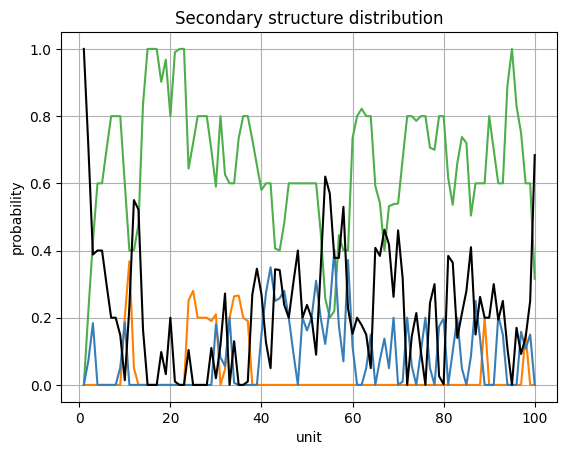

In [61]:
fig, ax = plt.subplots()
plt.plot(ah_distr, color='#4daf4a')
plt.plot(tth_distr, color='#ff7f00')
plt.plot(bs_distr, color='#377eb8')
plt.plot(iss_distr, color='black')

ax.set(xlabel='unit', ylabel='probability',
       title='Secondary structure distribution')
ax.grid()

plt.show()

In [ ]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']